##2D NCA Grayscale##
3/4/24

Imports:

In [ ]:
# Imports for loading / displaying image
import io
import PIL.Image, PIL.ImageDraw
import requests
from IPython.display import Image, HTML, clear_output

# Standard imports
import numpy as np
import random
from tqdm.auto import tqdm

# TF / Keras
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D
from keras.layers import DepthwiseConv2D
from keras.layers import concatenate
from keras import Model
from keras import Input
from keras import backend as K
from keras.layers import MaxPooling2D
from keras.layers import Conv3D

Set the target emoji and parameters:

In [ ]:
# First select the target emoji (any Google emoji)
target_emoji = "🦎"
code = hex(ord(target_emoji))[2:].lower()
target_url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code

image_size = 64
target_size = 40
target_padding = (image_size - target_size) // 2

# num_channels is the vector length in each cell
num_channels = 16

Load and display functions: (now using loadimage_grayscale)

In [ ]:
def loadimage_grayscale(url, max_size = target_size):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  gray_img=img.convert("L")
  gray_img=np.array(gray_img)
  nimg=np.zeros((gray_img.shape[0],gray_img.shape[1],4))
  nimg[...,0]=gray_img/255.0
  img=np.array(img)
  nimg[...,3]=img[...,3]/255.0 #copy in alpha
  nimg[..., 0] *= nimg[..., 3]
  #print(nimg[20:23,20:23,:])
  return nimg

def loadimage_bw(url, max_size = target_size):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  gray_img=img.convert("L")
  gray_img=np.array(gray_img)/255
  gray_img=np.where(gray_img>0,1,0)
  nimg=np.zeros((gray_img.shape[0],gray_img.shape[1],4))
  nimg[...,0]=gray_img
  nimg[...,3]=1
  return nimg

def load_image_old(url, max_size = target_size):
  """load_image loads an image and pixelizes it

  Args:
    url of the image and the target size to return
  Returns:
    a normalized np array with values between 0 - 1 that stores the image data
  """
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img) / 255.0
  img[..., :3] *= img[..., 3:4]
  print(img.shape)
  return img

def load_emoji(emoji):
  """load_emoji calls load_image on a passed in emoji

  Args:
    a string that contains a Google emoji
  Returns:
    a normalized np array that stores the emoji data
  """
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)

def to_rgb(x):
  """Converts an image with RGB values multiplied by alpha to standard RGB format.

  Args:
      x: A NumPy array representing the image with premultiplied RGBA.
  Returns:
      A NumPy array representing the image in RGB format.
  """
  rgb, a = x[..., :3], x[...,3:4]
  return (1.0 - a) + rgb #scaler + array of triples to offsett every RGB

def gray_to_rgb(x):
  """Converts an image with RGB values multiplied by alpha to standard RGB format.

  Args:
      x: A NumPy array representing the image with premultiplied RGBA.
  Returns:
      A NumPy array representing the image in RGB format.
  """
  rgb=np.zeros((x.shape[0],x.shape[1], 3))
  #print(x.shape)
  rgb[...,:1] = x[..., :1]
  rgb[...,1:2] = x[..., :1]
  rgb[...,2:3] = x[..., :1]
  a = x[...,3:4]
  return 1.0 - a + rgb

def bw_to_rgb(x):
  """Converts an image with RGB values multiplied by alpha to standard RGB format.

  Args:
      x: A NumPy array representing the image with premultiplied RGBA.
  Returns:
      A NumPy array representing the image in RGB format.
  """
  rgb=np.zeros((x.shape[0],x.shape[1], 3))
  #print(x.shape)
  rgb[...,:1] = x[..., :1]
  rgb[...,1:2] = x[..., :1]
  rgb[...,2:3] = x[..., :1]
  #a = x[...,3:4]
  return 1 - rgb

def np2pil(a):
  """Converts a NumPy array to a PIL image.

  Args:
      a: The NumPy array representing the image data.
  Returns:
      A PIL Image object.
  """
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1) * 255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  """Saves a NumPy array as an image file.

  Args:
      f: File object or filename to save the image to.
      a: NumPy array representing image data.
      fmt: Optional. Specifies the desired output format.
  """
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  """Encodes a NumPy array into a image format in memory, represented as bytes.

  Args:
      a: NumPy array representing the image data.
      fmt: Specifies the image format (default 'jpeg').
  Returns:
      Bytes object containing the encoded image.
  """
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def imshow(a, fmt='jpeg'):
  """Displays a NumPy array as an image.

  Args:
      a: NumPy array representing the image data.
      fmt: Specifies the image format (default 'jpeg').
  """
  display(Image(data = imencode(a, fmt)))

def zoom(img, scale=4):
  """Zooms an image by a specified scale factor, repeating pixels for enlargement.

  Args:
      img: The NumPy array representing the image to zoom.
      scale: The zoom factor (default 4).
  Returns:
      A NumPy array representing the zoomed image.
  """
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

Display the target image

<ipython-input-3-1f77955b05c5>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)


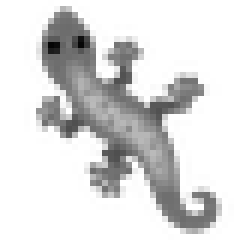

In [ ]:
gray_target_img = loadimage_grayscale(target_url, target_size)
imshow(zoom(gray_to_rgb(gray_target_img),6),fmt='png')

(40, 40, 4)


<ipython-input-3-1f77955b05c5>:37: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)


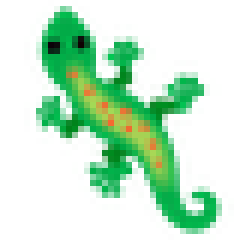

In [ ]:
color_target_img = load_image_old(target_url, target_size)
imshow(zoom(to_rgb(color_target_img),6),fmt='png')

<ipython-input-3-1f77955b05c5>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)


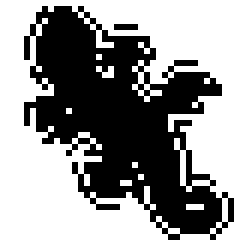

In [ ]:
bw_target_img = loadimage_bw(target_url, target_size)
imshow(zoom(bw_to_rgb(bw_target_img),6),fmt='png')

We use MSE as our loss function

In [ ]:
def calc_loss(y_true, y_pred):
  """MSE between the 1st (grayscale) and 4th (alpha) channels of the current and target state,
     letting channels 2 and 3 be hidden channels.

  Args:
    y_true, y_pred: TF tensors that contain the channel values for each pixel
  Returns:
    MSE Loss
  """
  loss = tf.reduce_mean(tf.square(y_true[...,0] - y_pred[...,0]))
  loss += tf.reduce_mean(tf.square(y_true[...,3] - y_pred[...,3]))
  return loss

In [ ]:
class CA():

  def __init__(self, target_img, seed_type = 'seed'):
    print("Seed and target initialized")
    self.update_count = 0
    self.padded_target = self.pad_target(target_img)
    self.model = model_step
    self.opt = opt
    self.seed_type = seed_type
    self.set_seed()
    # dummy evaluation so model is completely initialized
    self.apply_model_step(self.state_grid)

  def set_seed(self):
    """initializes what starting seed to grow from. Defaults to 'seed'.
    The lizard model can also be initialized with 'diagonal' for quicker training.
    """
    self.state_grid = np.zeros((1, image_size, image_size, num_channels),np.float32)
    if self.seed_type == 'seed':
      self.state_grid[0, image_size // 2, image_size // 2, 0:] = 1.0
      #self.state_grid[0, image_size // 2, image_size // 2, 0]= 1.0

  def pad_target(self, target):
    p = target_padding
    padded = np.pad(target, [(p,p), (p,p), (0,0)])
    return np.array([padded])

  @tf.function
  def get_living_mask(self, x):
    """Determines living state of a cell given state of neighbors

    Args:
      x: the current state for all the cells
    Returns:
      boolean array indicating if a cell should be considered alive or dead
    """
    alpha = x[:, :, :, 3:4]
    alive = MaxPooling2D(pool_size=3,strides=1,padding='same')(alpha)
    return K.cast(alive > 0.1,dtype='int32')
    #return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

  def display_current_state(self, current_grid):
    imshow(zoom(bw_to_rgb(current_grid[0]), 6), fmt = 'png')

  def grow(self, nsteps):
    """Display growth from seed to target

    Args:
      nsteps: grow for this many steps
    """
    self.set_seed()
    x = self.state_grid
    step = 1
    self.display_current_state(x)
    for i in range(nsteps):
      print("Time step ", step)
      x = self.apply_model_step(x)
      self.display_current_state(x)
      step += 1
    loss = tf.reduce_mean(calc_loss(self.padded_target, x))
    print("Current Loss: ", tf.get_static_value(loss))

  @tf.function
  def apply_model_step(self, input_img):
    """apply_model_step takes one time step forward in the RNN by calling the
     Sobel filters and passes the concatenated output into the Conv2D layers.
     The delta produced by the model is added to the state_grid if that specific
     cell is alive both before and after the update.

    Args:
      input_img: current state of the grid
    Returns:
      The updated state_grid
    """
    alive_before_update = self.get_living_mask(input_img)
    delta = self.model(input_img)
    new_img = input_img + delta
    still_living = self.get_living_mask(new_img)
    live = K.cast(alive_before_update&still_living, tf.float32)
    #live = tf.cast(alive_before_update&still_living, tf.float32)
    return new_img * live

  @tf.function
  def train_step(self, input_img):
    """train_step calculates the gradients for an RNN of length RNN_length.
    train_step is called by train to be repeated ntimes. tf.Gradient tape watches all the weights
    and treats them as variables for backpropagation. g.gradient calculates the gradient vectors after
    the end of the RNN loop. The gradients are then normalized before the weights are updated.

    Args:
      input_img: current state of the grid
    Returns:
      The new state_grid and the loss
    """
    RNN_length = 100
    x = input_img
    with tf.GradientTape() as g:
      for i in range(RNN_length):
        x = self.apply_model_step(x)
      loss = calc_loss(self.padded_target, x)
    grads = g.gradient(loss, self.model.trainable_weights)
    grads = [grad / (tf.norm(grad) + 1e-8) for grad in grads]
    self.opt.apply_gradients(zip(grads, self.model.trainable_weights))
    return x, loss

  def train(self, ntimes):
    """trains an emoji model's weights ntimes by calling train_step on the starting seed.
    Displays the current training step, loss, and training time.

    Args:
      ntimes: trains the model n times
    """
    print("Training Steps Completed: " + str(self.update_count))
    for i in tqdm(range(ntimes)):
      self.set_seed()
      new_grid,loss = self.train_step(self.state_grid)
      self.update_count += 1
      self.state_grid = new_grid
      print("Training Steps Completed: " + str(self.update_count))
      print("Loss:"), tf.print(loss)
      self.display_current_state(self.state_grid)
    return

1. Create new model:

In [ ]:
from keras.optimizers.schedules import PiecewiseConstantDecay
from keras.optimizers.schedules import ExponentialDecay

# Sobel filters in x direction

sobelx_kernel = np.zeros((3,3, num_channels))

for i in range(num_channels):
  sobelx_kernel[:,:,i] = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
  #sobelx_kernel[:,:,i] = np.array([[0,1,0], [1,0,1], [0,1,0]])


sobelx_kernel = sobelx_kernel.reshape((3, 3, num_channels, 1))

def Sobelx_init(shape, dtype=None):
  return sobelx_kernel

Sobelx_layer = DepthwiseConv2D(kernel_size = 3, depthwise_initializer = Sobelx_init, use_bias = False, padding = "same")
Sobelx_layer.trainable = False

# Sobel filters in y direction

sobely_kernel = np.zeros((3,3, num_channels))

for i in range(num_channels):
  sobely_kernel[:,:,i] = np.array([[-1,0,1], [-2,0,2], [-1,0,1]]).T
  #sobely_kernel[:,:,i] = np.array([[1,0,1], [0,0,0], [1,0,1]]).T


sobely_kernel = sobely_kernel.reshape((3, 3, num_channels, 1))

def Sobely_init(shape, dtype=None):
  return sobely_kernel

Sobely_layer = DepthwiseConv2D(kernel_size = 3, depthwise_initializer = Sobely_init, use_bias = False, padding = "same")
Sobely_layer.trainable = False

# Model concatenates output of sobel layers with the current state and passes through two Conv2D layers

image = Input(shape = (image_size, image_size, num_channels))
Sobel_x = Sobelx_layer(image)
Sobel_y = Sobely_layer(image)
concat = concatenate([Sobel_x, Sobel_y, image])
print(concat.shape)
dense1 = Conv2D(128, 3, activation = 'relu', bias_initializer = 'zeros', padding = 'same')(concat)
dense2=Conv2D(16, 1, activation = None, kernel_initializer = 'zeros', bias_initializer = 'zeros')(dense1)
model_step = Model(image, dense2)
model_step.summary()

lr = 1e-3
lr_sched = tf.keras.optimizers.schedules.ExponentialDecay(lr, 100, 0.9)
#lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000], [lr,lr*.01])
opt = tf.keras.optimizers.Adam(lr_sched)

(None, 64, 64, 48)
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 64, 64, 16)]         0         []                            
                                                                                                  
 depthwise_conv2d_20 (Depth  (None, 64, 64, 16)           144       ['input_11[0][0]']            
 wiseConv2D)                                                                                      
                                                                                                  
 depthwise_conv2d_21 (Depth  (None, 64, 64, 16)           144       ['input_11[0][0]']            
 wiseConv2D)                                                                                      
                                                                        

Visualize model:

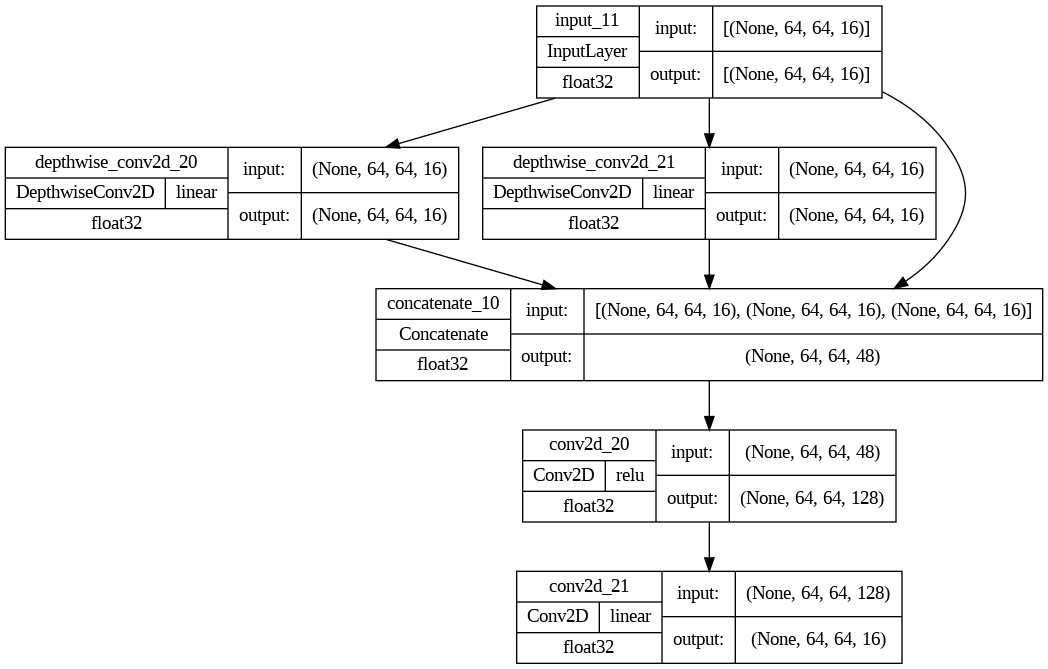

In [ ]:
keras.utils.plot_model(model_step,show_shapes=True,show_dtype=True,show_layer_activations=True)

2. Initialize:

In [ ]:
grid = CA(bw_target_img)

Seed and target initialized


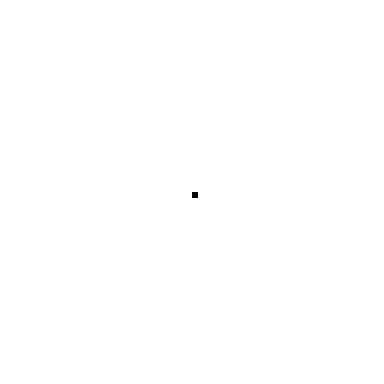

Time step  1


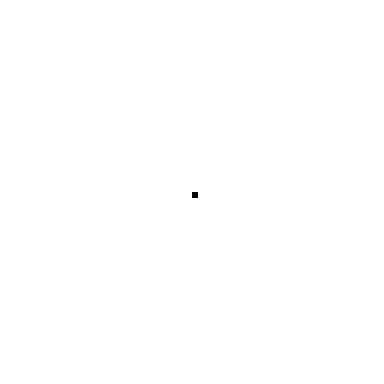

Current Loss:  0.55737305


In [ ]:
grid.grow(1)

3. Train:

Training Steps Completed: 0


  0%|          | 0/10 [00:00<?, ?it/s]

Training Steps Completed: 1
Loss:
0.557373047


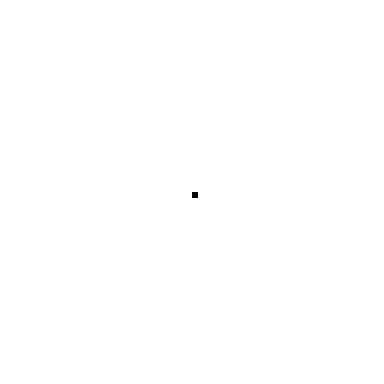

Training Steps Completed: 2
Loss:
0.630358875


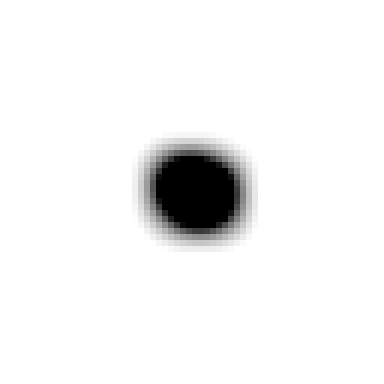

Training Steps Completed: 3
Loss:
0.450805783


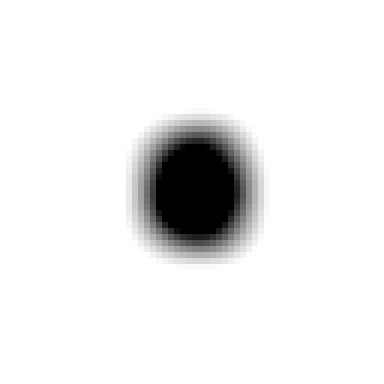

Training Steps Completed: 4
Loss:
0.379446387


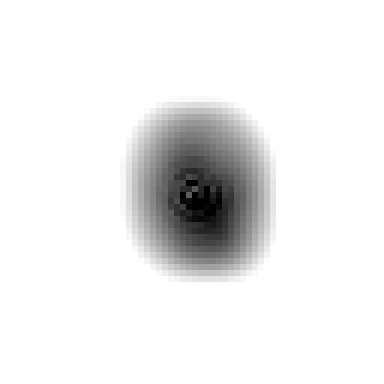

Training Steps Completed: 5
Loss:
0.227620035


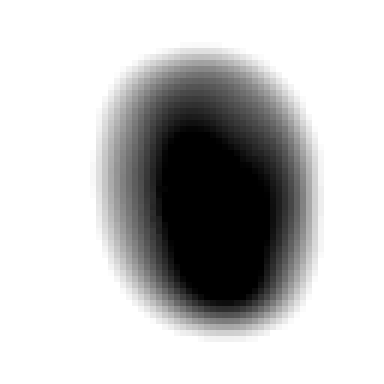

Training Steps Completed: 6
Loss:
0.202052057


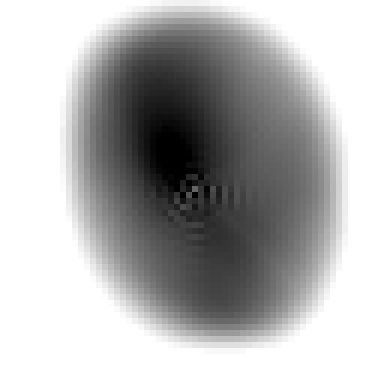

Training Steps Completed: 7
Loss:
0.166010797


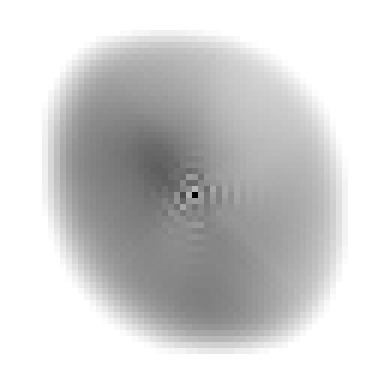

Training Steps Completed: 8
Loss:
0.167273194


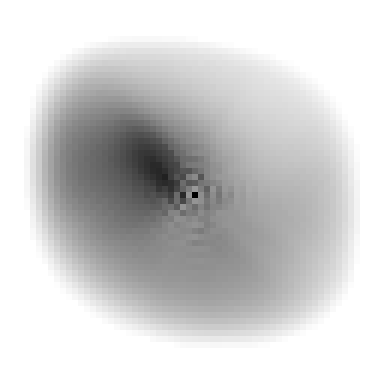

Training Steps Completed: 9
Loss:
0.152254239


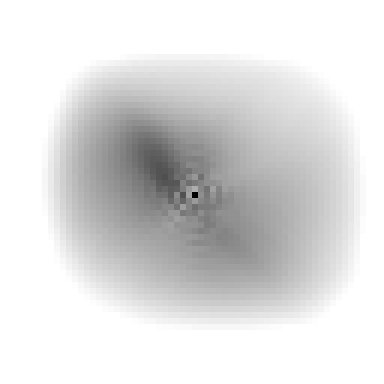

Training Steps Completed: 10
Loss:
0.128906861


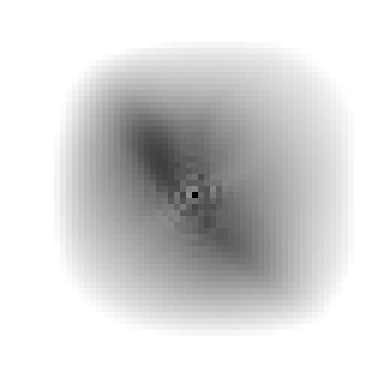

In [ ]:
grid.train(10)

Training Steps Completed: 0


  0%|          | 0/500 [00:00<?, ?it/s]

Training Steps Completed: 1
Loss:
0.116791427
(64, 64, 16)


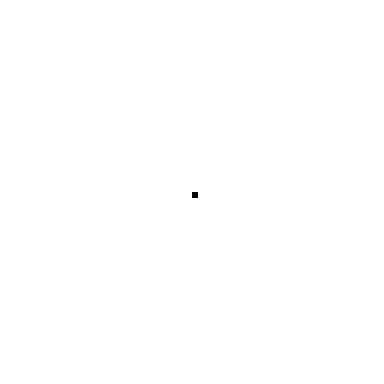

Training Steps Completed: 2
Loss:
0.281896532
(64, 64, 16)


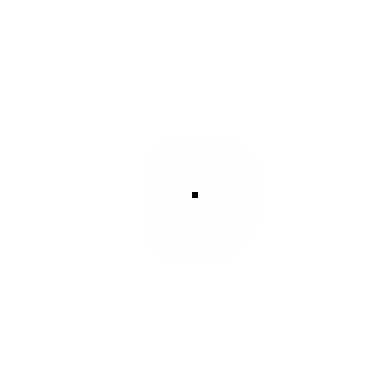

Training Steps Completed: 3
Loss:
0.0935833305
(64, 64, 16)


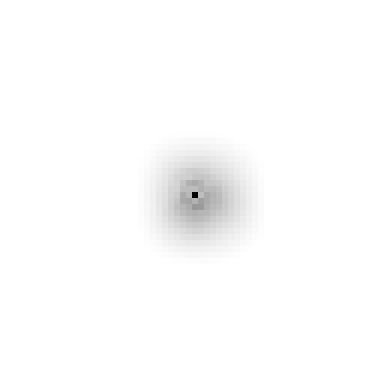

Training Steps Completed: 4
Loss:
0.0798122659
(64, 64, 16)


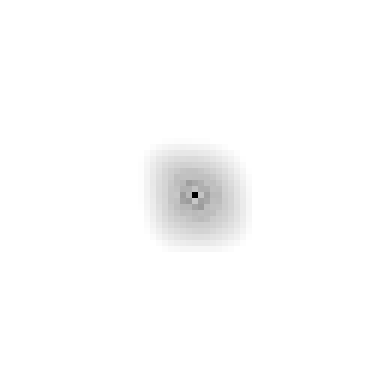

Training Steps Completed: 5
Loss:
0.0534252189
(64, 64, 16)


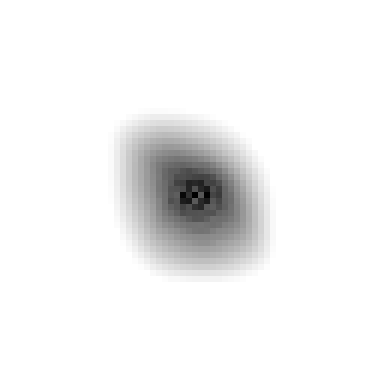

Training Steps Completed: 6
Loss:
0.0429633223
(64, 64, 16)


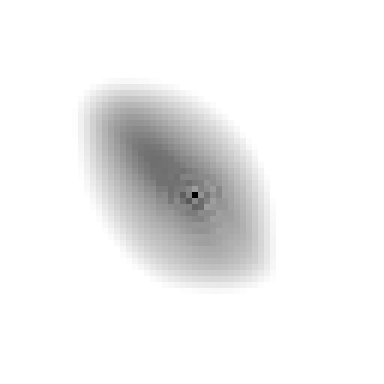

Training Steps Completed: 7
Loss:
0.0417602584
(64, 64, 16)


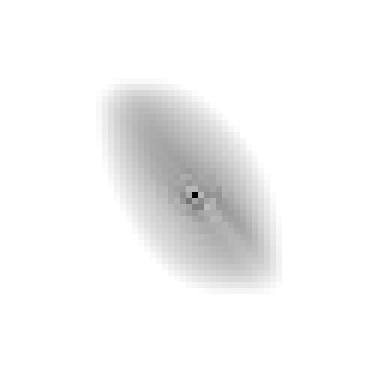

Training Steps Completed: 8
Loss:
0.0593846887
(64, 64, 16)


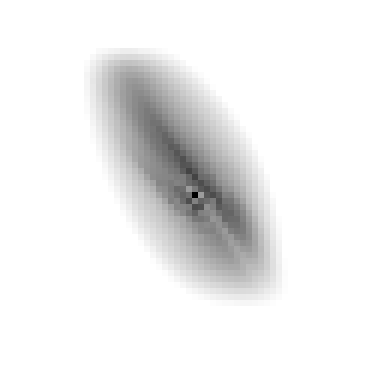

Training Steps Completed: 9
Loss:
0.0483880974
(64, 64, 16)


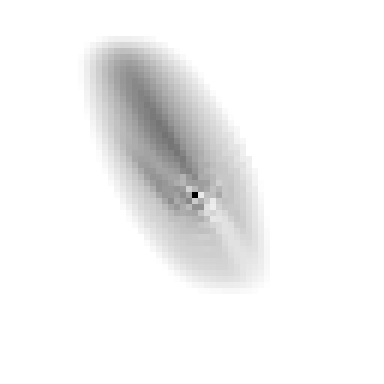

Training Steps Completed: 10
Loss:
0.0452818349
(64, 64, 16)


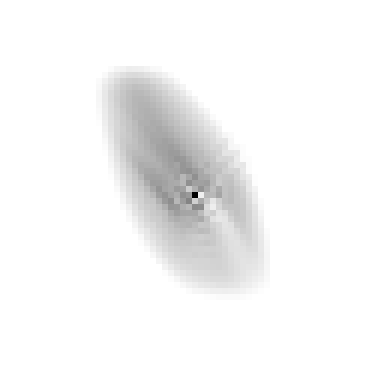

Training Steps Completed: 11
Loss:
0.0379876755
(64, 64, 16)


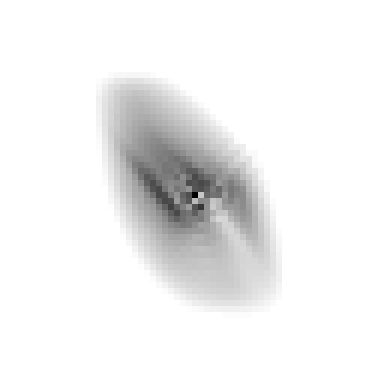

Training Steps Completed: 12
Loss:
0.0353221297
(64, 64, 16)


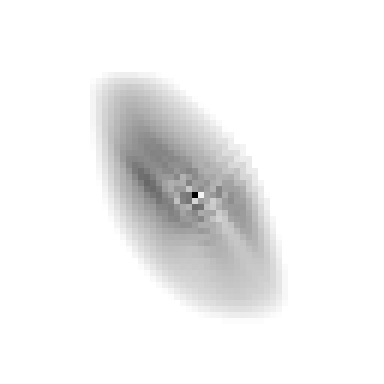

Training Steps Completed: 13
Loss:
0.0314466618
(64, 64, 16)


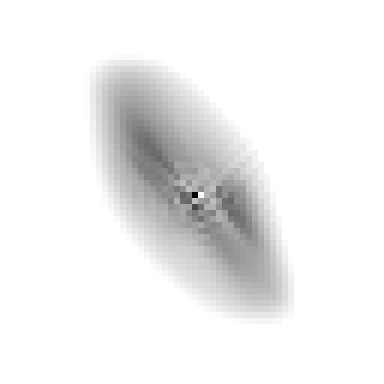

Training Steps Completed: 14
Loss:
0.0344895832
(64, 64, 16)


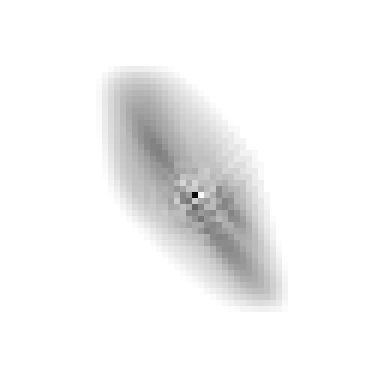

Training Steps Completed: 15
Loss:
0.0313861296
(64, 64, 16)


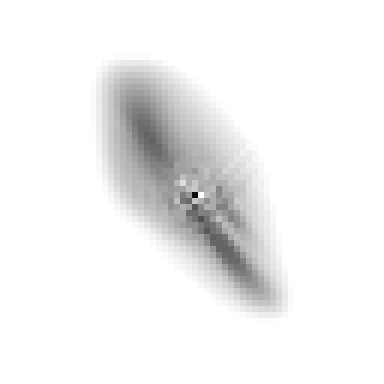

Training Steps Completed: 16
Loss:
0.0285170805
(64, 64, 16)


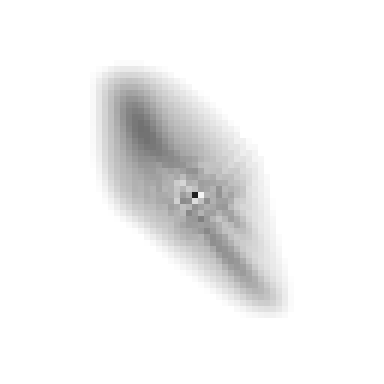

Training Steps Completed: 17
Loss:
0.0312842652
(64, 64, 16)


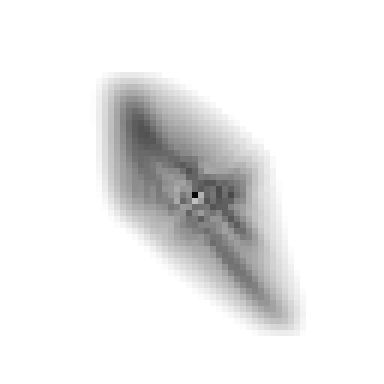

Training Steps Completed: 18
Loss:
0.0293658637
(64, 64, 16)


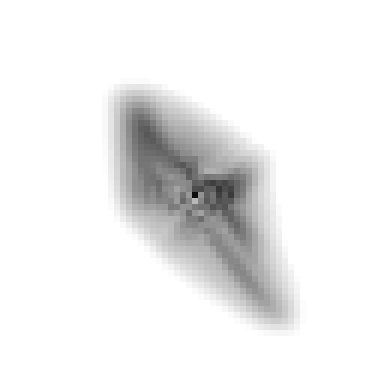

Training Steps Completed: 19
Loss:
0.029108122
(64, 64, 16)


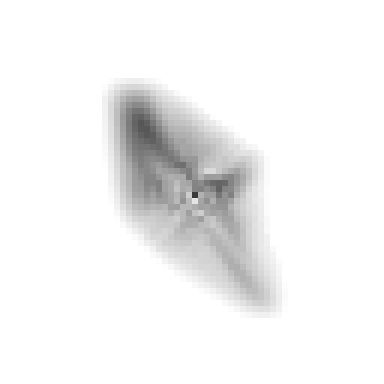

Training Steps Completed: 20
Loss:
0.0293290671
(64, 64, 16)


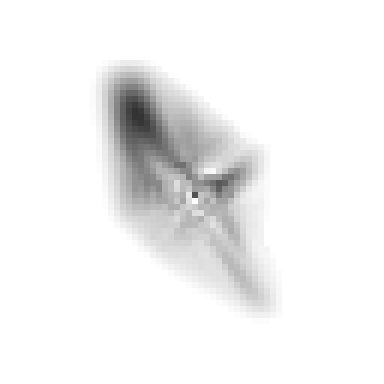

Training Steps Completed: 21
Loss:
0.0249523409
(64, 64, 16)


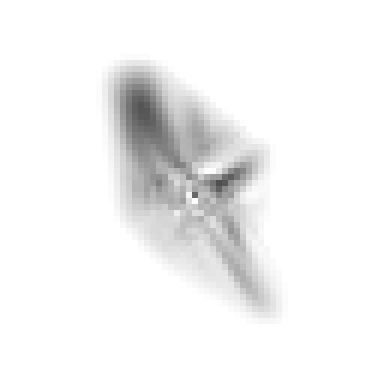

Training Steps Completed: 22
Loss:
0.026535714
(64, 64, 16)


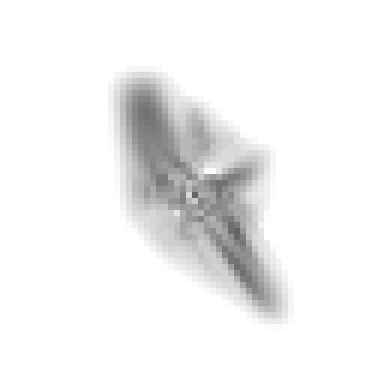

Training Steps Completed: 23
Loss:
0.0248750709
(64, 64, 16)


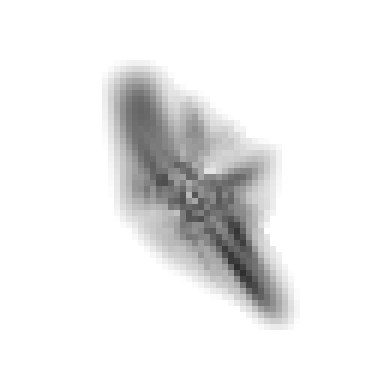

Training Steps Completed: 24
Loss:
0.0248777363
(64, 64, 16)


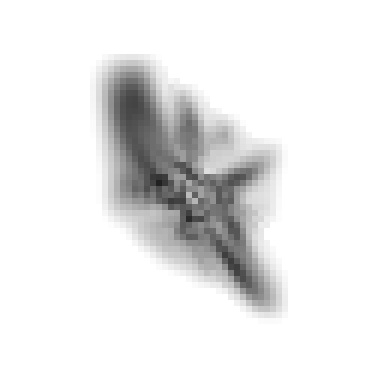

Training Steps Completed: 25
Loss:
0.0227123853
(64, 64, 16)


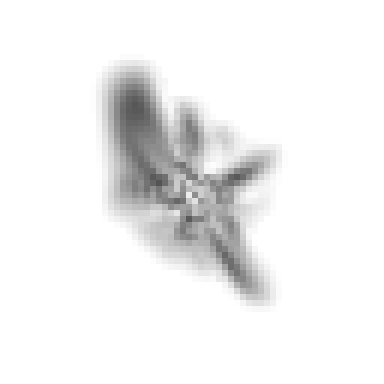

Training Steps Completed: 26
Loss:
0.0234560631
(64, 64, 16)


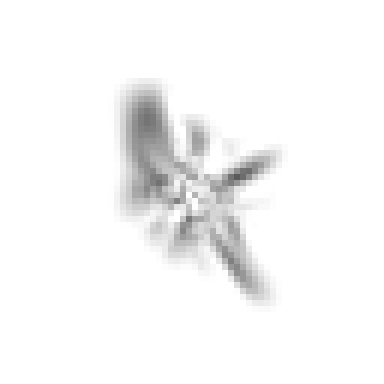

Training Steps Completed: 27
Loss:
0.0241930299
(64, 64, 16)


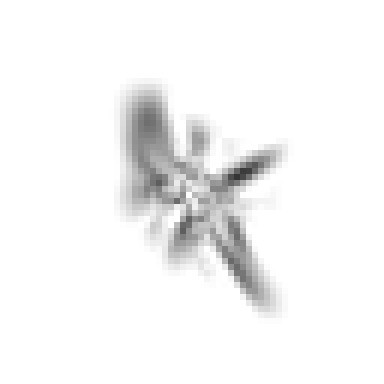

Training Steps Completed: 28
Loss:
0.0184874237
(64, 64, 16)


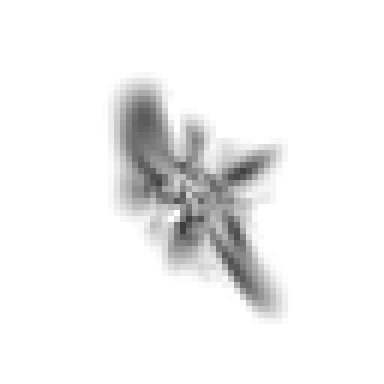

Training Steps Completed: 29
Loss:
0.0220847428
(64, 64, 16)


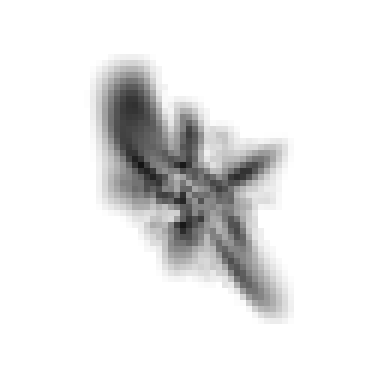

Training Steps Completed: 30
Loss:
0.0220121145
(64, 64, 16)


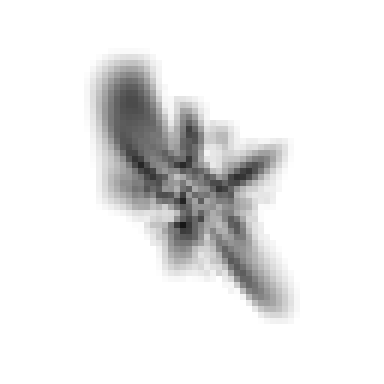

Training Steps Completed: 31
Loss:
0.016558405
(64, 64, 16)


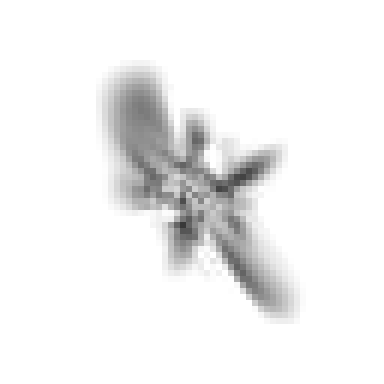

Training Steps Completed: 32
Loss:
0.0228993185
(64, 64, 16)


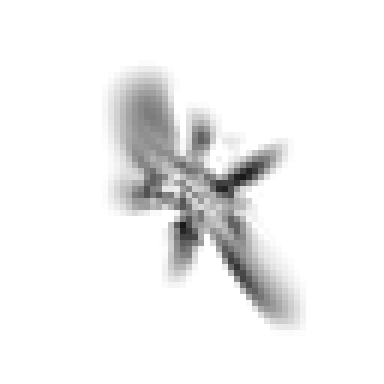

Training Steps Completed: 33
Loss:
0.0201681461
(64, 64, 16)


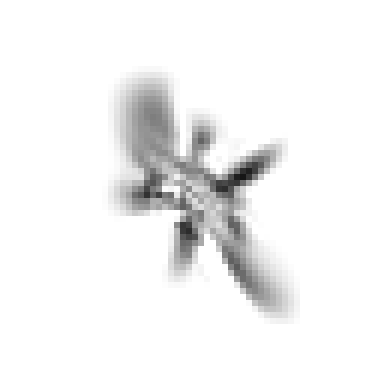

Training Steps Completed: 34
Loss:
0.023747962
(64, 64, 16)


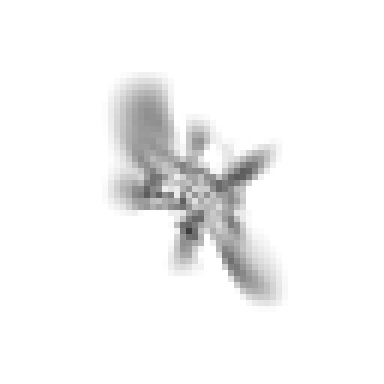

Training Steps Completed: 35
Loss:
0.0212791432
(64, 64, 16)


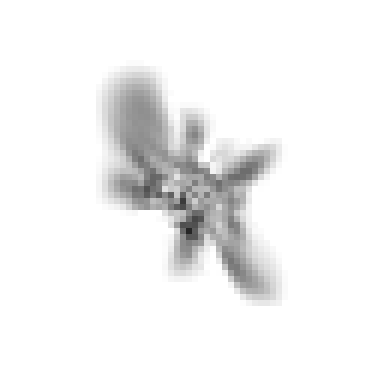

Training Steps Completed: 36
Loss:
0.0207932405
(64, 64, 16)


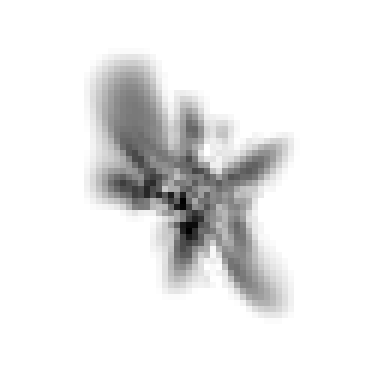

Training Steps Completed: 37
Loss:
0.0205273852
(64, 64, 16)


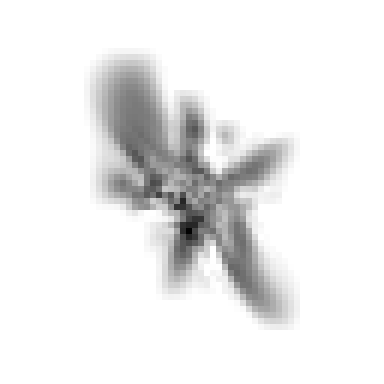

Training Steps Completed: 38
Loss:
0.0152609274
(64, 64, 16)


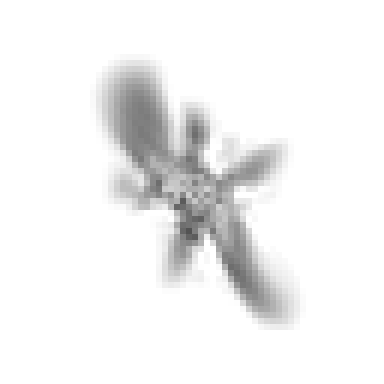

Training Steps Completed: 39
Loss:
0.0148019986
(64, 64, 16)


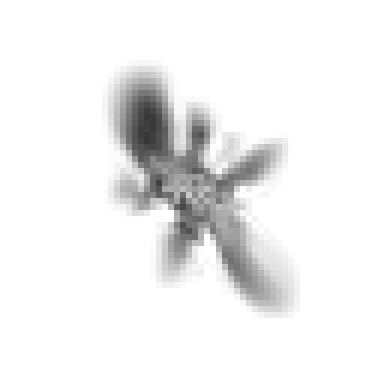

Training Steps Completed: 40
Loss:
0.0141439987
(64, 64, 16)


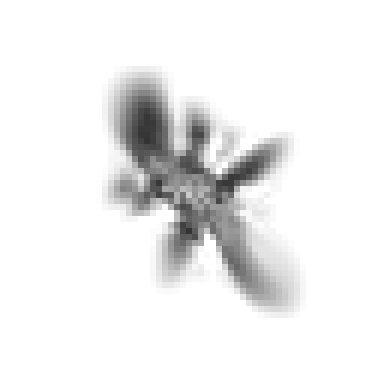

Training Steps Completed: 41
Loss:
0.0127479387
(64, 64, 16)


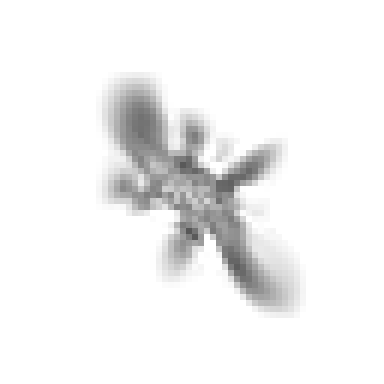

Training Steps Completed: 42
Loss:
0.0137194591
(64, 64, 16)


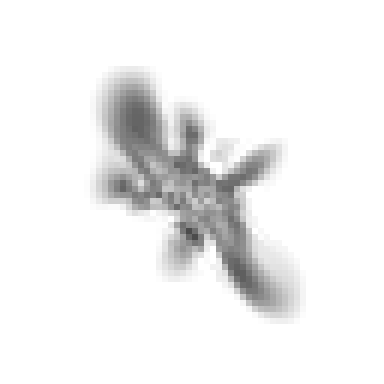

Training Steps Completed: 43
Loss:
0.0114886649
(64, 64, 16)


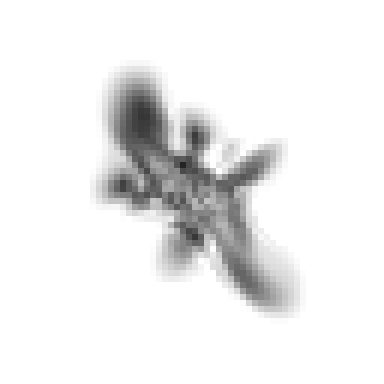

Training Steps Completed: 44
Loss:
0.0114318179
(64, 64, 16)


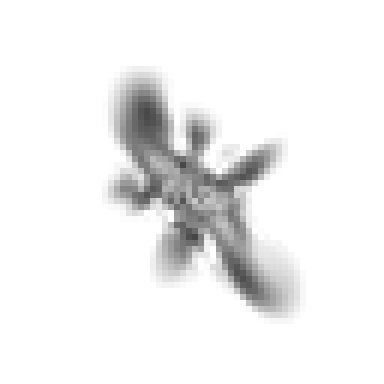

Training Steps Completed: 45
Loss:
0.0113234548
(64, 64, 16)


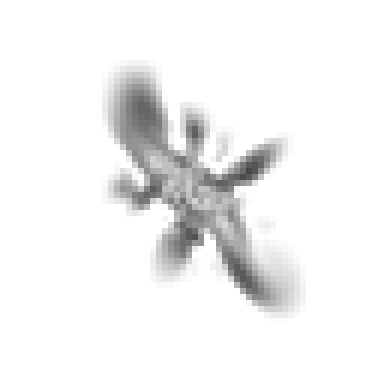

Training Steps Completed: 46
Loss:
0.0123816477
(64, 64, 16)


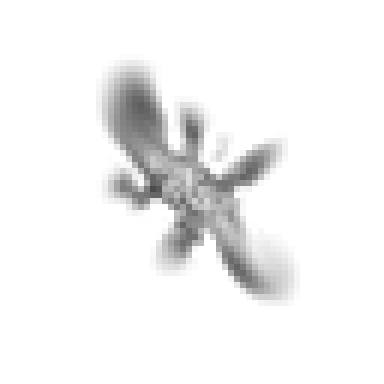

Training Steps Completed: 47
Loss:
0.01009857
(64, 64, 16)


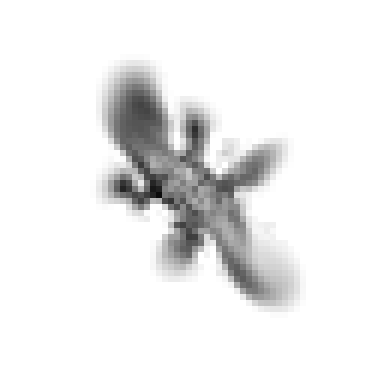

Training Steps Completed: 48
Loss:
0.0109344665
(64, 64, 16)


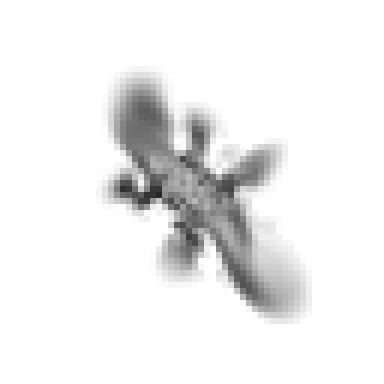

Training Steps Completed: 49
Loss:
0.00908256788
(64, 64, 16)


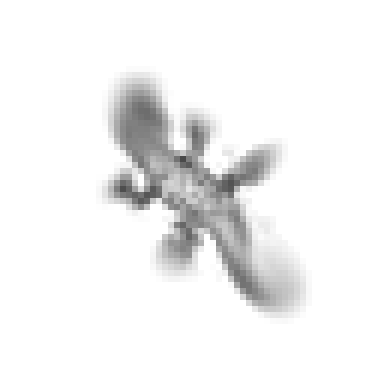

Training Steps Completed: 50
Loss:
0.0125791784
(64, 64, 16)


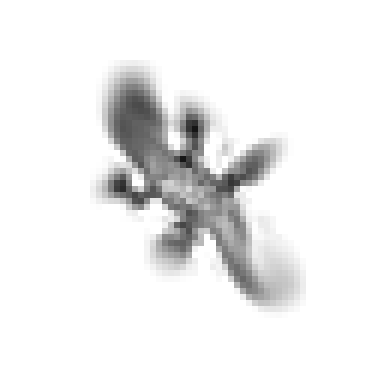

Training Steps Completed: 51
Loss:
0.0114943916
(64, 64, 16)


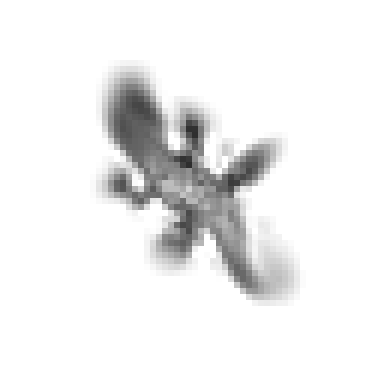

Training Steps Completed: 52
Loss:
0.0105619337
(64, 64, 16)


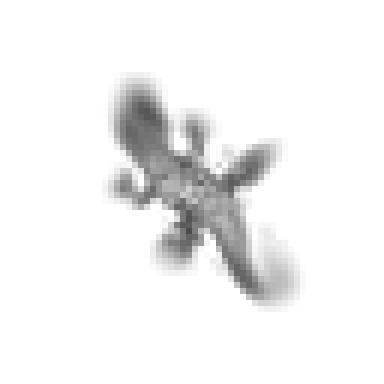

Training Steps Completed: 53
Loss:
0.0128099117
(64, 64, 16)


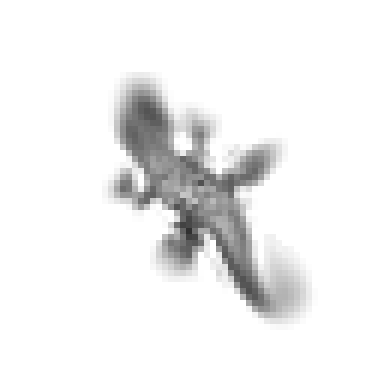

Training Steps Completed: 54
Loss:
0.00914282724
(64, 64, 16)


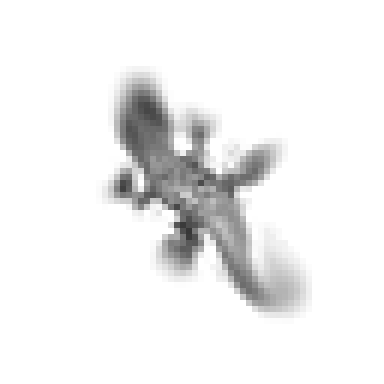

Training Steps Completed: 55
Loss:
0.00987337157
(64, 64, 16)


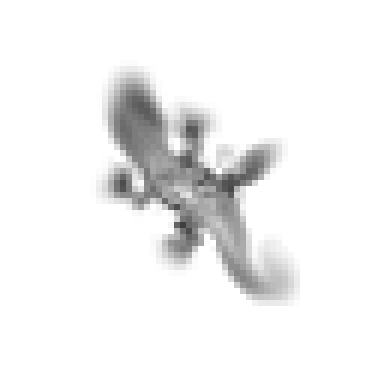

Training Steps Completed: 56
Loss:
0.0121879419
(64, 64, 16)


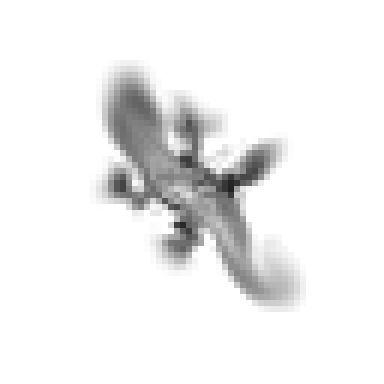

Training Steps Completed: 57
Loss:
0.00829615258
(64, 64, 16)


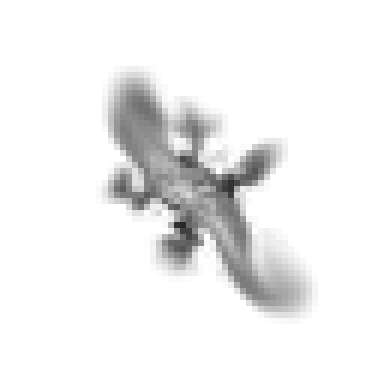

Training Steps Completed: 58
Loss:
0.00961973891
(64, 64, 16)


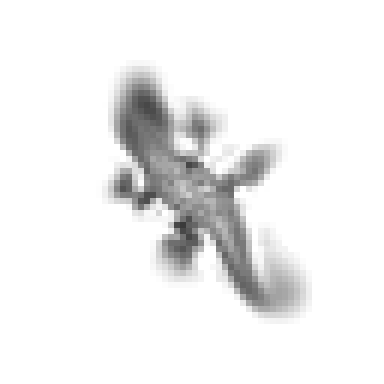

Training Steps Completed: 59
Loss:
0.00952888839
(64, 64, 16)


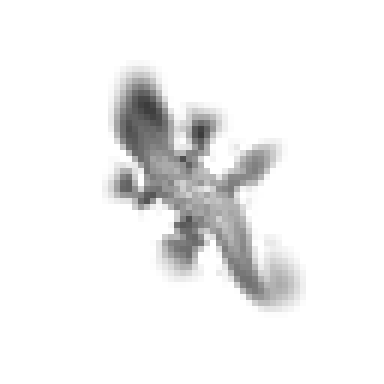

Training Steps Completed: 60
Loss:
0.00748863397
(64, 64, 16)


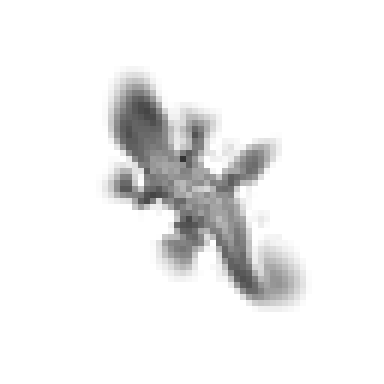

Training Steps Completed: 61
Loss:
0.00976158865
(64, 64, 16)


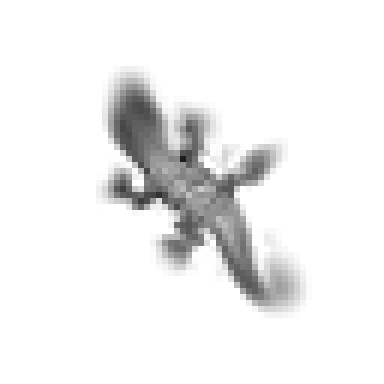

Training Steps Completed: 62
Loss:
0.0100497492
(64, 64, 16)


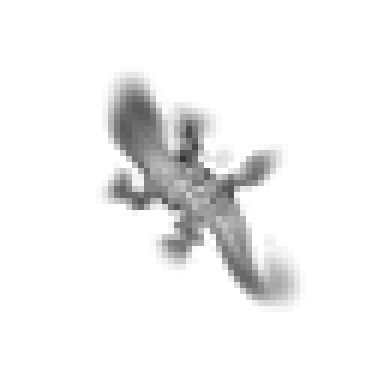

Training Steps Completed: 63
Loss:
0.00791549683
(64, 64, 16)


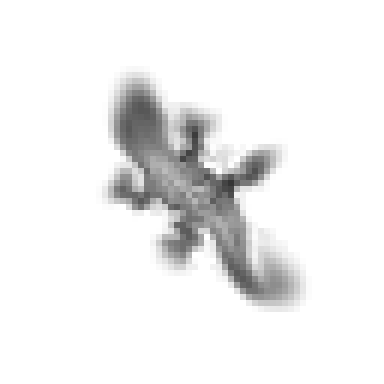

Training Steps Completed: 64
Loss:
0.0103956796
(64, 64, 16)


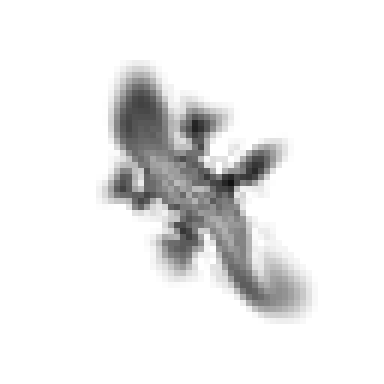

Training Steps Completed: 65
Loss:
0.00861193892
(64, 64, 16)


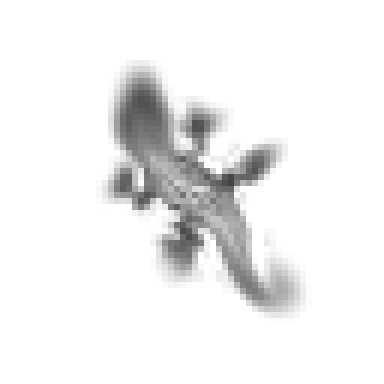

Training Steps Completed: 66
Loss:
0.0103637623
(64, 64, 16)


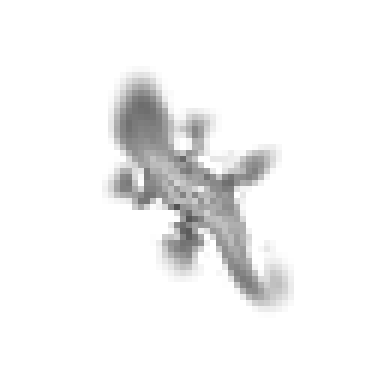

Training Steps Completed: 67
Loss:
0.00728415651
(64, 64, 16)


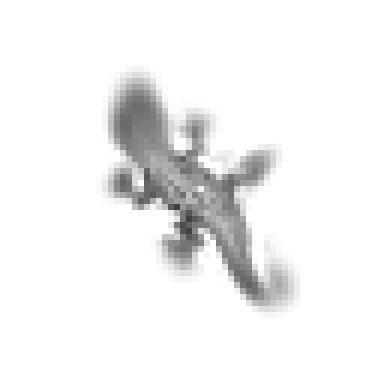

Training Steps Completed: 68
Loss:
0.0192376506
(64, 64, 16)


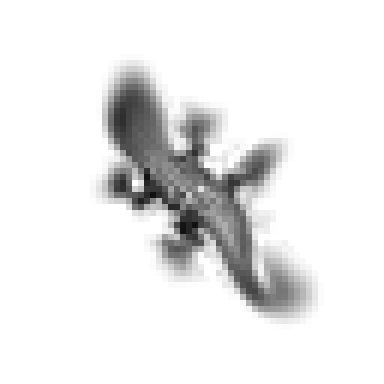

Training Steps Completed: 69
Loss:
0.0214172527
(64, 64, 16)


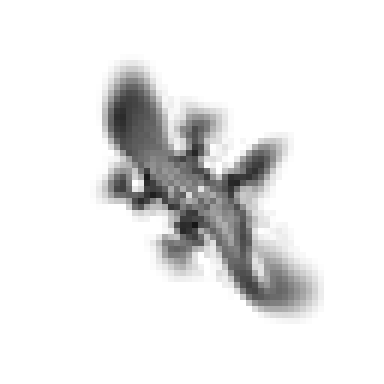

Training Steps Completed: 70
Loss:
0.00963775069
(64, 64, 16)


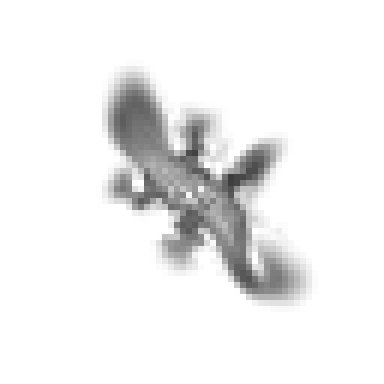

Training Steps Completed: 71
Loss:
0.0161611531
(64, 64, 16)


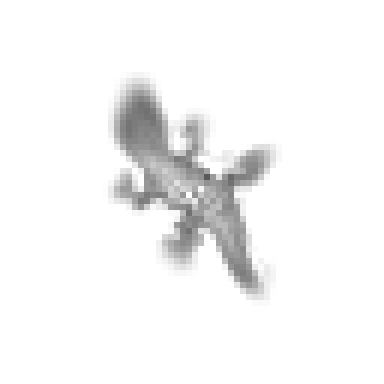

Training Steps Completed: 72
Loss:
0.0149031868
(64, 64, 16)


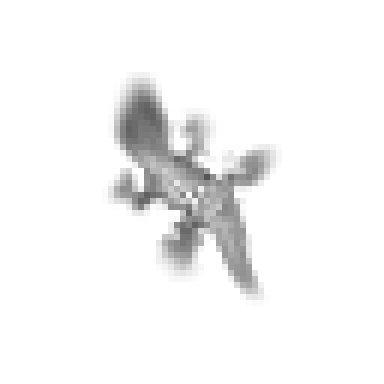

Training Steps Completed: 73
Loss:
0.0151860472
(64, 64, 16)


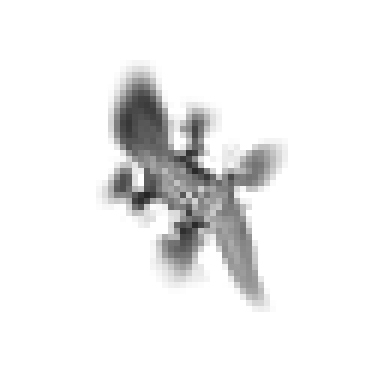

Training Steps Completed: 74
Loss:
0.0145586776
(64, 64, 16)


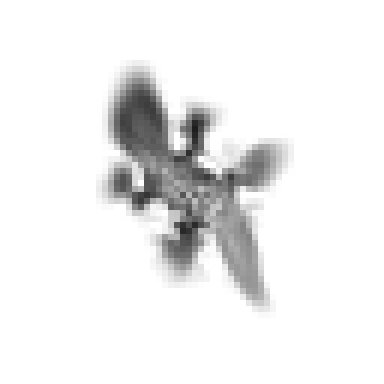

Training Steps Completed: 75
Loss:
0.0134671722
(64, 64, 16)


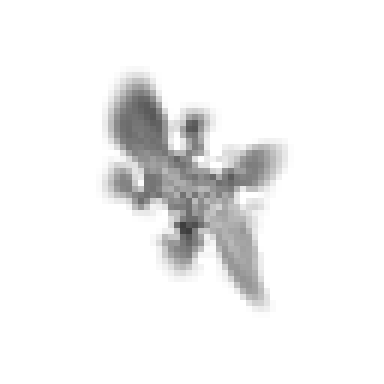

Training Steps Completed: 76
Loss:
0.0128879258
(64, 64, 16)


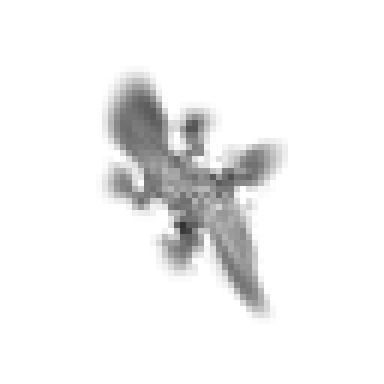

Training Steps Completed: 77
Loss:
0.0152983749
(64, 64, 16)


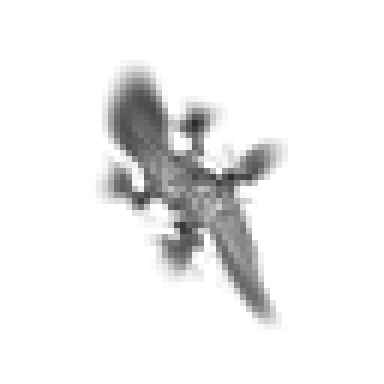

Training Steps Completed: 78
Loss:
0.012680443
(64, 64, 16)


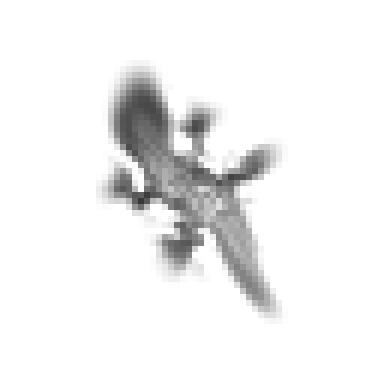

Training Steps Completed: 79
Loss:
0.0128895761
(64, 64, 16)


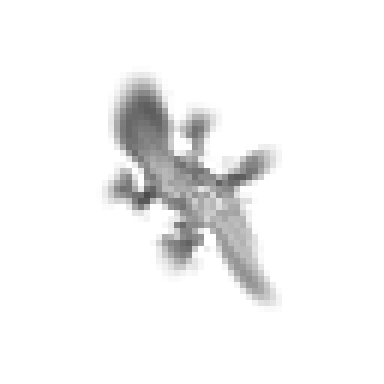

Training Steps Completed: 80
Loss:
0.011276884
(64, 64, 16)


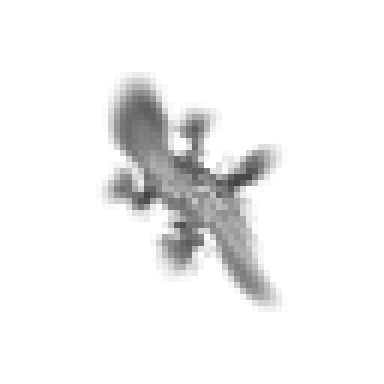

Training Steps Completed: 81
Loss:
0.0122061651
(64, 64, 16)


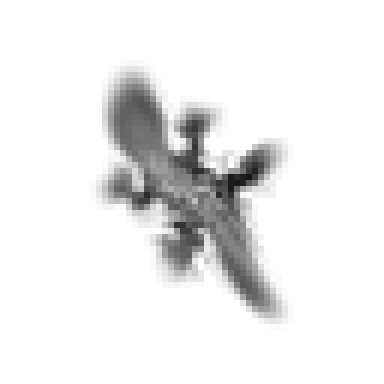

Training Steps Completed: 82
Loss:
0.0113412365
(64, 64, 16)


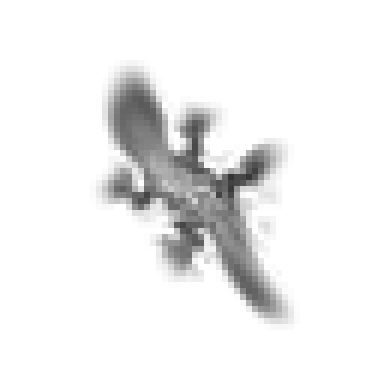

Training Steps Completed: 83
Loss:
0.00985989626
(64, 64, 16)


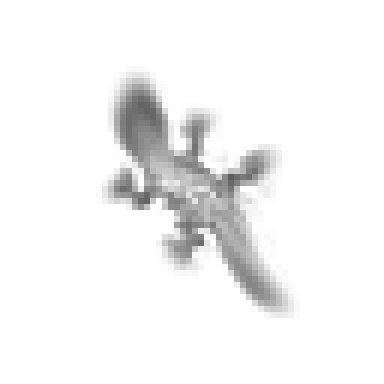

Training Steps Completed: 84
Loss:
0.00910923723
(64, 64, 16)


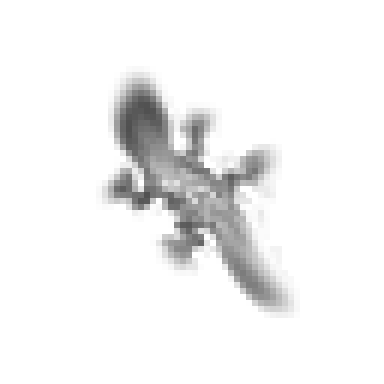

Training Steps Completed: 85
Loss:
0.0120095033
(64, 64, 16)


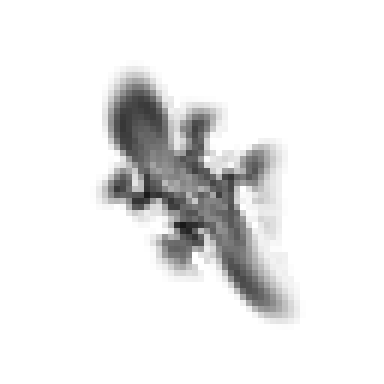

Training Steps Completed: 86
Loss:
0.0110241417
(64, 64, 16)


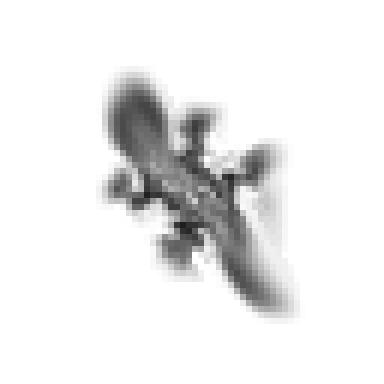

Training Steps Completed: 87
Loss:
0.008806495
(64, 64, 16)


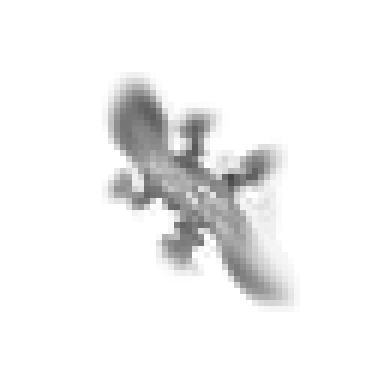

Training Steps Completed: 88
Loss:
0.00817608554
(64, 64, 16)


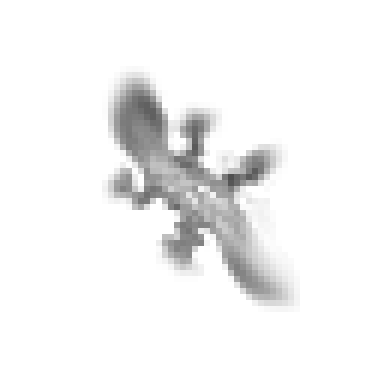

Training Steps Completed: 89
Loss:
0.00907861069
(64, 64, 16)


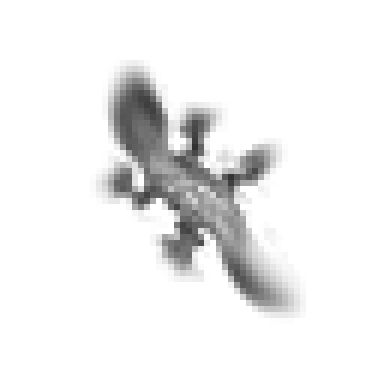

Training Steps Completed: 90
Loss:
0.00950885192
(64, 64, 16)


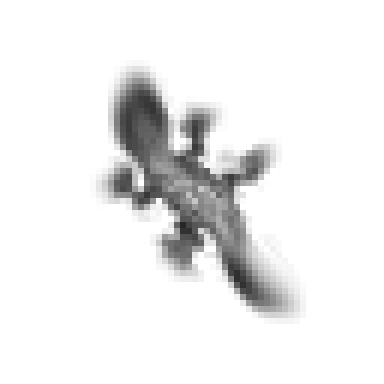

Training Steps Completed: 91
Loss:
0.00864894688
(64, 64, 16)


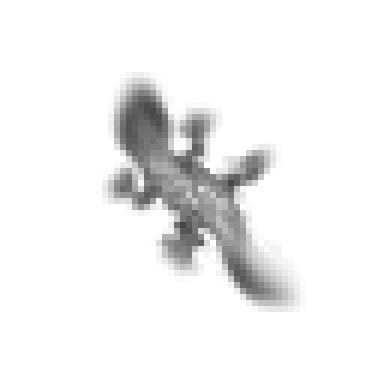

Training Steps Completed: 92
Loss:
0.00742732594
(64, 64, 16)


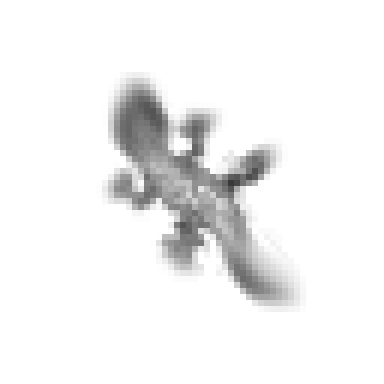

Training Steps Completed: 93
Loss:
0.0108266883
(64, 64, 16)


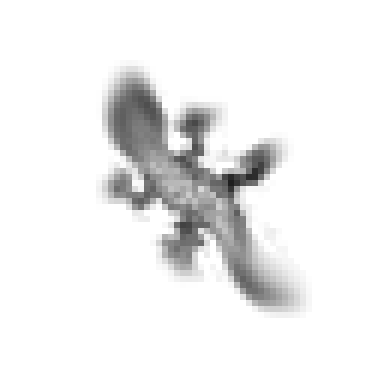

Training Steps Completed: 94
Loss:
0.0100883488
(64, 64, 16)


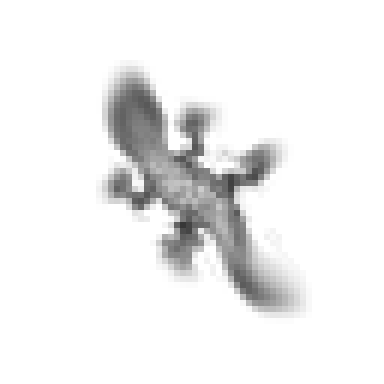

Training Steps Completed: 95
Loss:
0.00685642473
(64, 64, 16)


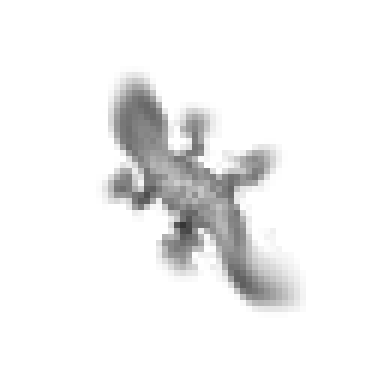

Training Steps Completed: 96
Loss:
0.00654068822
(64, 64, 16)


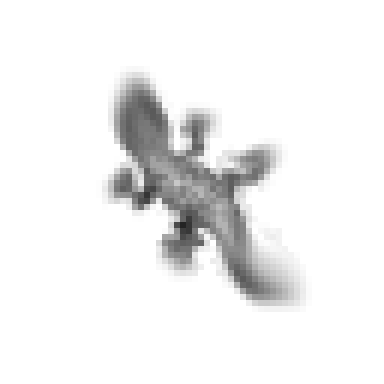

Training Steps Completed: 97
Loss:
0.0083081862
(64, 64, 16)


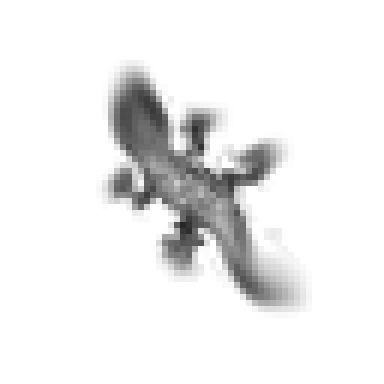

Training Steps Completed: 98
Loss:
0.0065873526
(64, 64, 16)


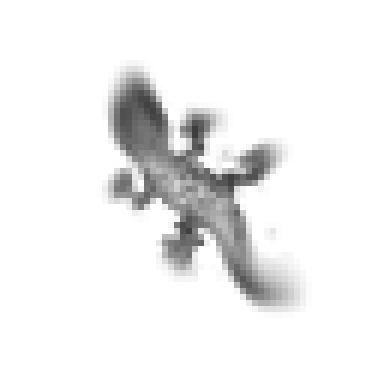

Training Steps Completed: 99
Loss:
0.00875543
(64, 64, 16)


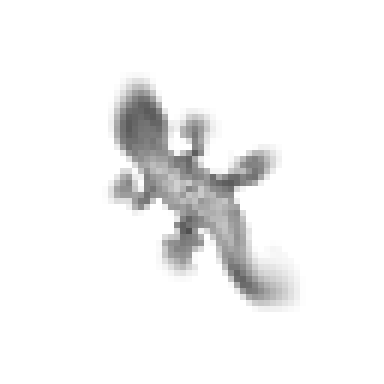

Training Steps Completed: 100
Loss:
0.00844699796
(64, 64, 16)


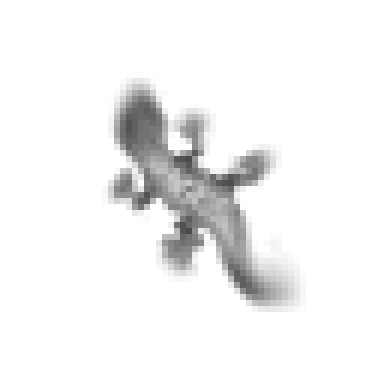

Training Steps Completed: 101
Loss:
0.00727746543
(64, 64, 16)


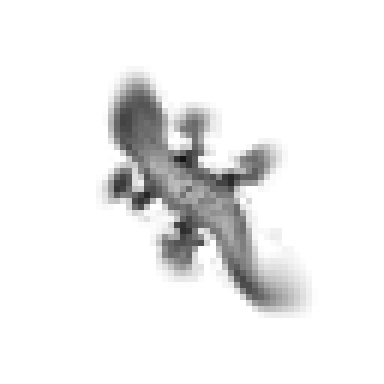

Training Steps Completed: 102
Loss:
0.00621703593
(64, 64, 16)


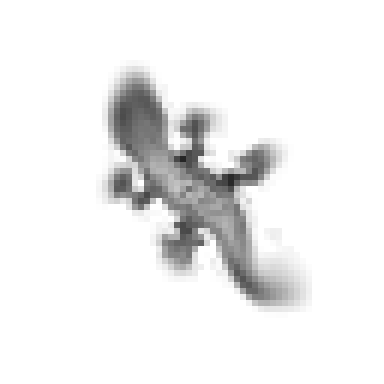

Training Steps Completed: 103
Loss:
0.00669394713
(64, 64, 16)


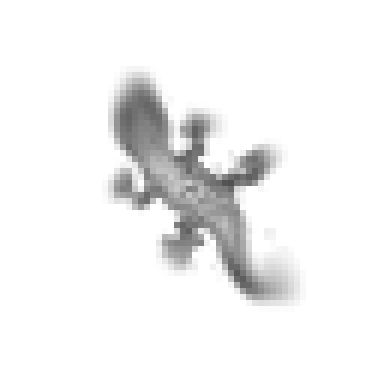

Training Steps Completed: 104
Loss:
0.00612758659
(64, 64, 16)


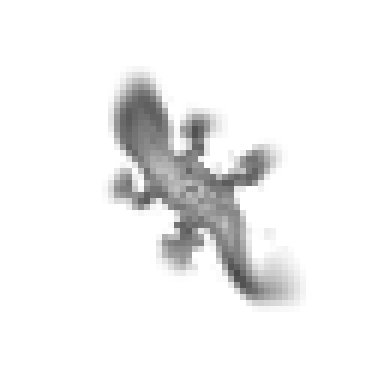

Training Steps Completed: 105
Loss:
0.0078834556
(64, 64, 16)


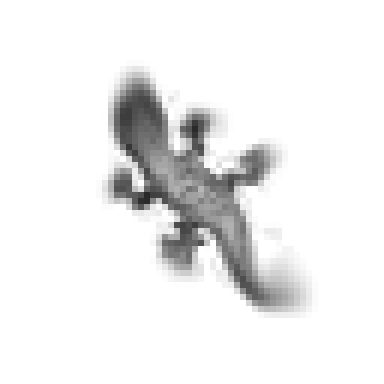

Training Steps Completed: 106
Loss:
0.00764392596
(64, 64, 16)


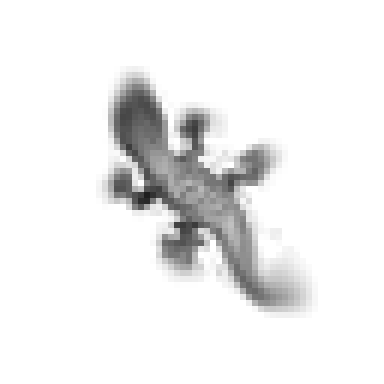

Training Steps Completed: 107
Loss:
0.00693291
(64, 64, 16)


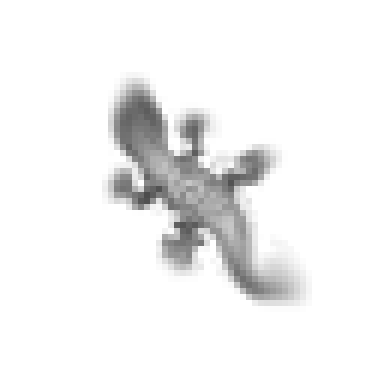

Training Steps Completed: 108
Loss:
0.00643187
(64, 64, 16)


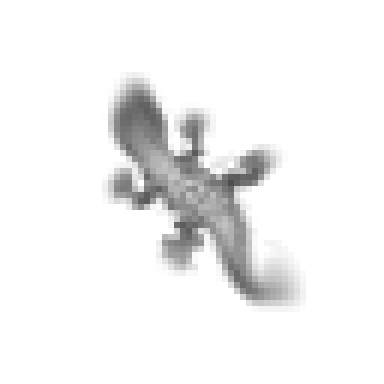

Training Steps Completed: 109
Loss:
0.00734955538
(64, 64, 16)


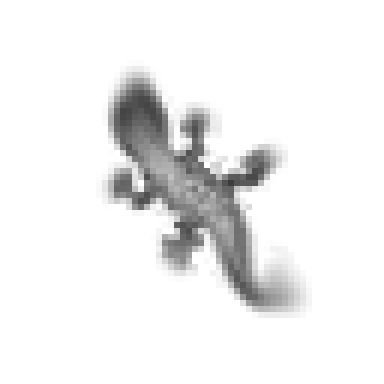

Training Steps Completed: 110
Loss:
0.00598040596
(64, 64, 16)


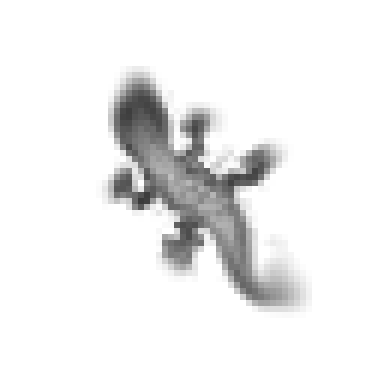

Training Steps Completed: 111
Loss:
0.00629784726
(64, 64, 16)


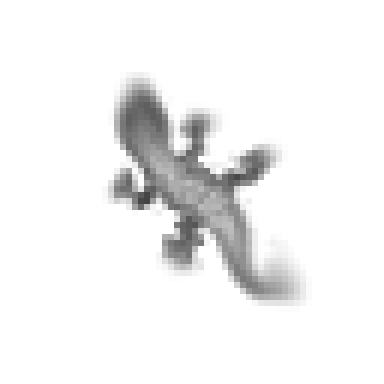

Training Steps Completed: 112
Loss:
0.00572519191
(64, 64, 16)


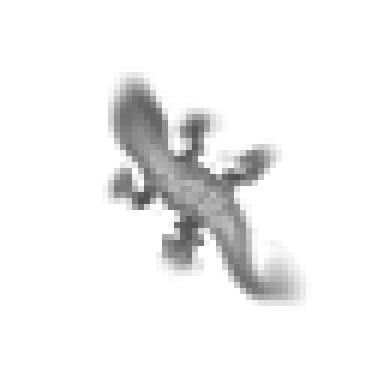

Training Steps Completed: 113
Loss:
0.00823071878
(64, 64, 16)


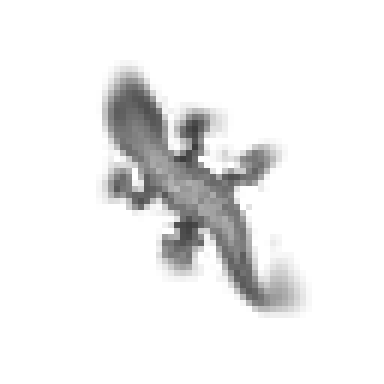

Training Steps Completed: 114
Loss:
0.00742879463
(64, 64, 16)


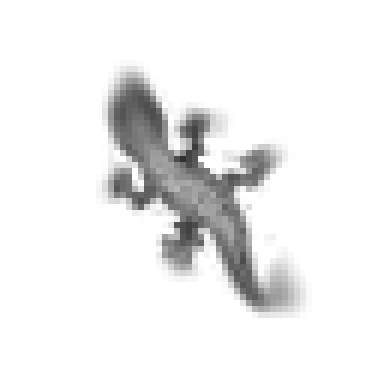

Training Steps Completed: 115
Loss:
0.00476413406
(64, 64, 16)


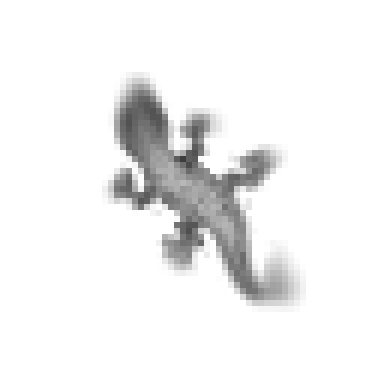

Training Steps Completed: 116
Loss:
0.00458975136
(64, 64, 16)


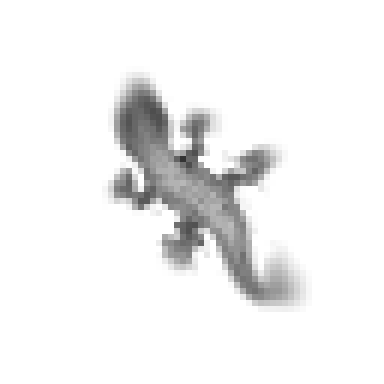

Training Steps Completed: 117
Loss:
0.00615076767
(64, 64, 16)


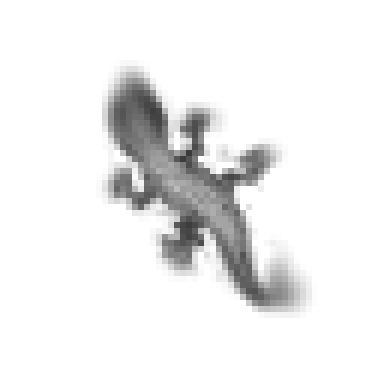

Training Steps Completed: 118
Loss:
0.00542071927
(64, 64, 16)


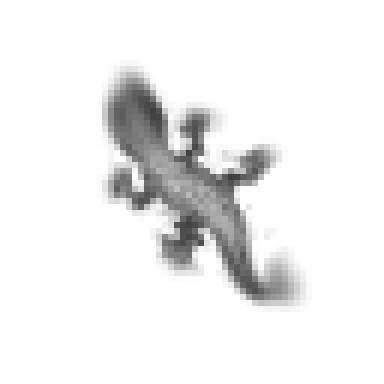

Training Steps Completed: 119
Loss:
0.00636649132
(64, 64, 16)


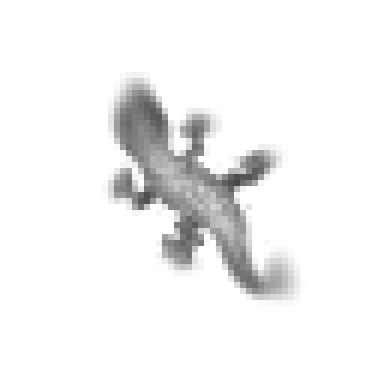

Training Steps Completed: 120
Loss:
0.00625707069
(64, 64, 16)


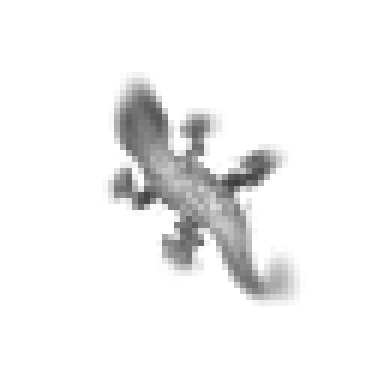

Training Steps Completed: 121
Loss:
0.00496004242
(64, 64, 16)


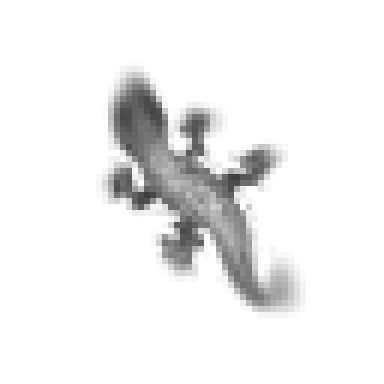

Training Steps Completed: 122
Loss:
0.00564037124
(64, 64, 16)


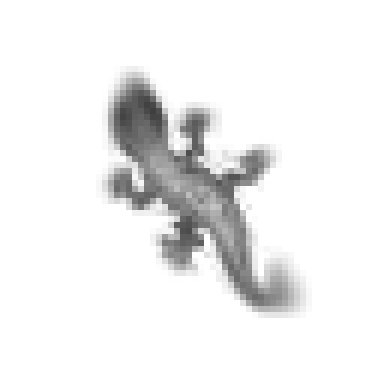

Training Steps Completed: 123
Loss:
0.00429681269
(64, 64, 16)


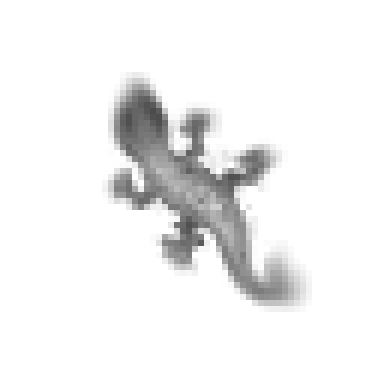

Training Steps Completed: 124
Loss:
0.00429119542
(64, 64, 16)


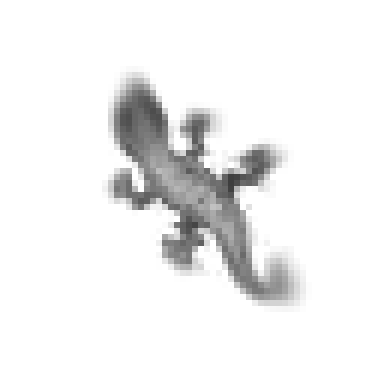

Training Steps Completed: 125
Loss:
0.00482217968
(64, 64, 16)


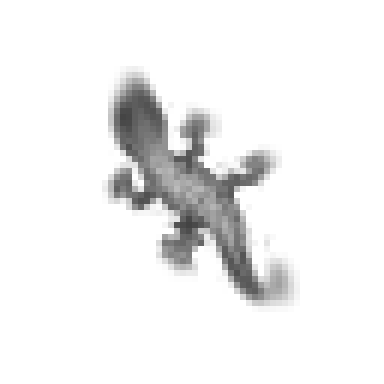

Training Steps Completed: 126
Loss:
0.00453946553
(64, 64, 16)


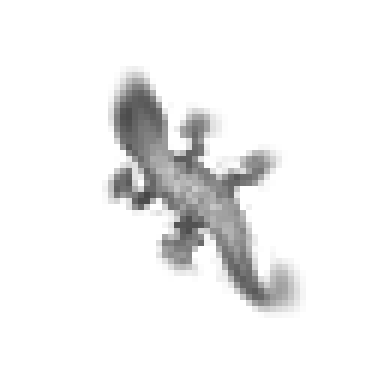

Training Steps Completed: 127
Loss:
0.00508509111
(64, 64, 16)


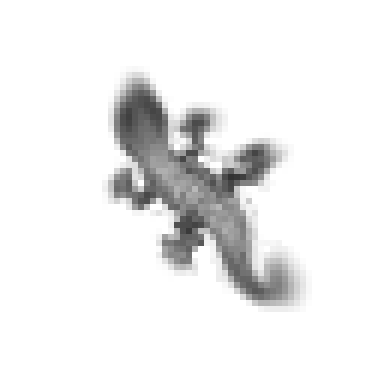

Training Steps Completed: 128
Loss:
0.00440804427
(64, 64, 16)


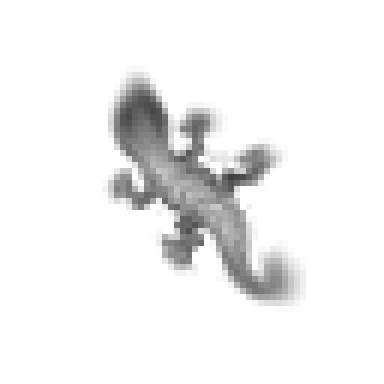

Training Steps Completed: 129
Loss:
0.00432239147
(64, 64, 16)


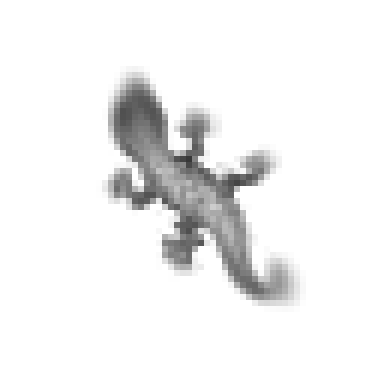

Training Steps Completed: 130
Loss:
0.00527295331
(64, 64, 16)


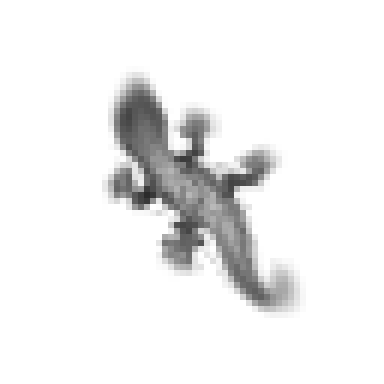

Training Steps Completed: 131
Loss:
0.00514003821
(64, 64, 16)


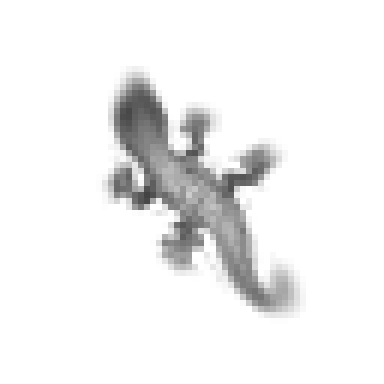

Training Steps Completed: 132
Loss:
0.00549316313
(64, 64, 16)


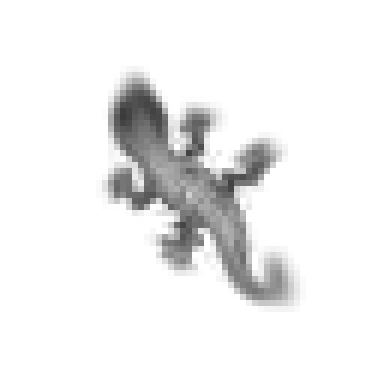

Training Steps Completed: 133
Loss:
0.0057914732
(64, 64, 16)


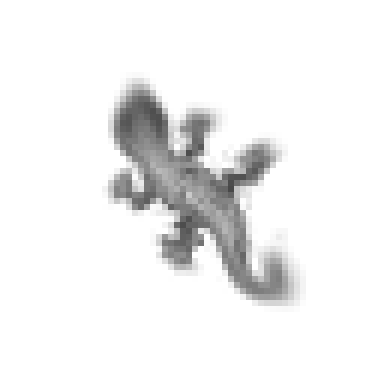

Training Steps Completed: 134
Loss:
0.00503462832
(64, 64, 16)


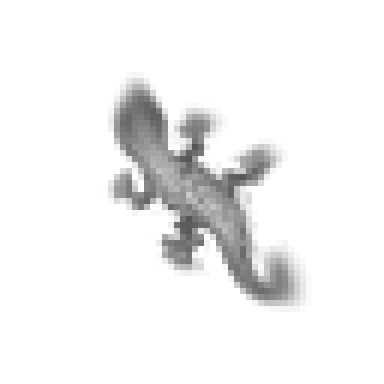

Training Steps Completed: 135
Loss:
0.00454153353
(64, 64, 16)


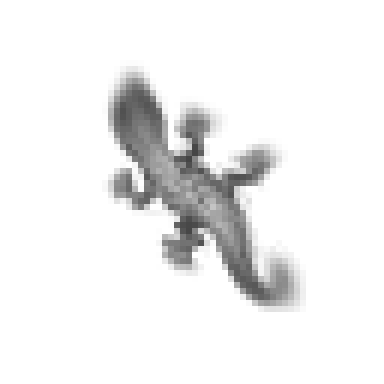

Training Steps Completed: 136
Loss:
0.00495655276
(64, 64, 16)


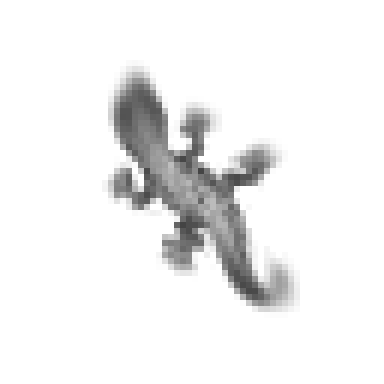

Training Steps Completed: 137
Loss:
0.00453350414
(64, 64, 16)


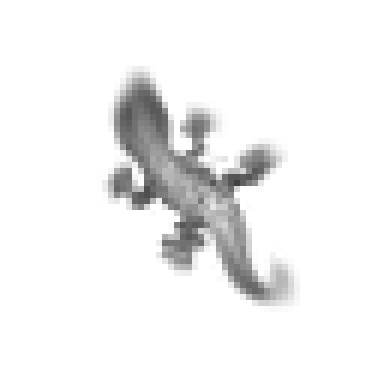

Training Steps Completed: 138
Loss:
0.00476880698
(64, 64, 16)


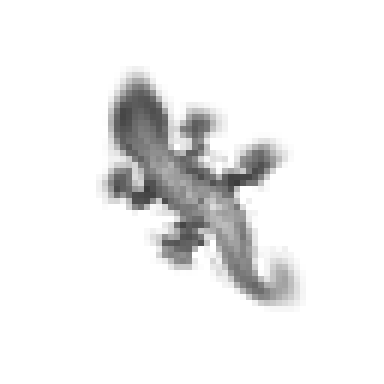

Training Steps Completed: 139
Loss:
0.0037875697
(64, 64, 16)


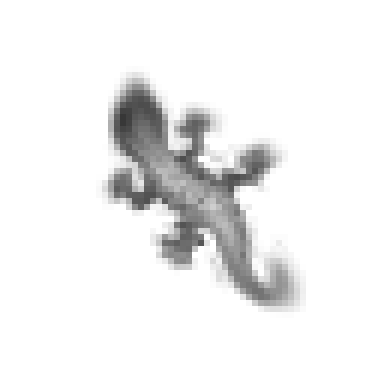

Training Steps Completed: 140
Loss:
0.00538444752
(64, 64, 16)


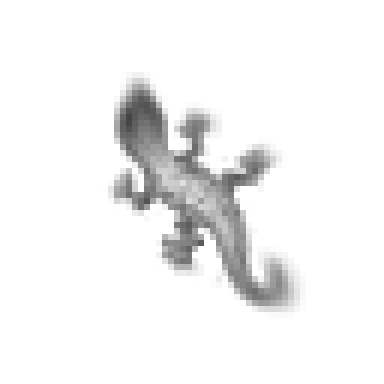

Training Steps Completed: 141
Loss:
0.00444697542
(64, 64, 16)


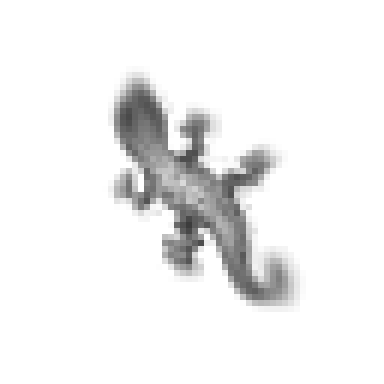

Training Steps Completed: 142
Loss:
0.00557221472
(64, 64, 16)


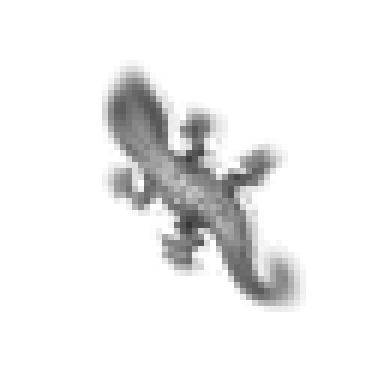

Training Steps Completed: 143
Loss:
0.00487329578
(64, 64, 16)


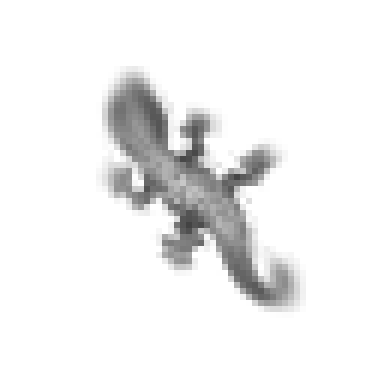

Training Steps Completed: 144
Loss:
0.00511510577
(64, 64, 16)


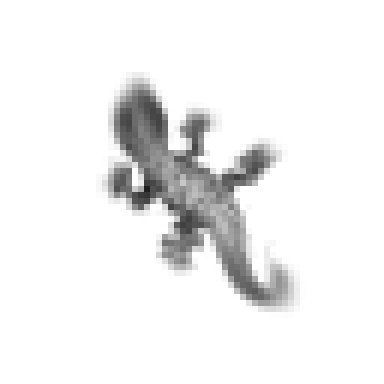

Training Steps Completed: 145
Loss:
0.00523556676
(64, 64, 16)


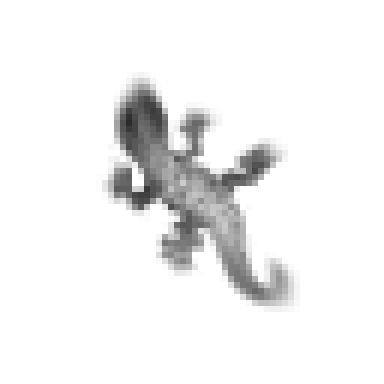

Training Steps Completed: 146
Loss:
0.00398646481
(64, 64, 16)


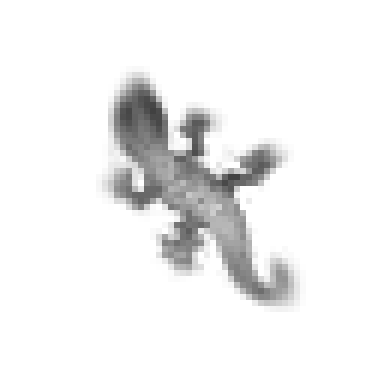

Training Steps Completed: 147
Loss:
0.00506532
(64, 64, 16)


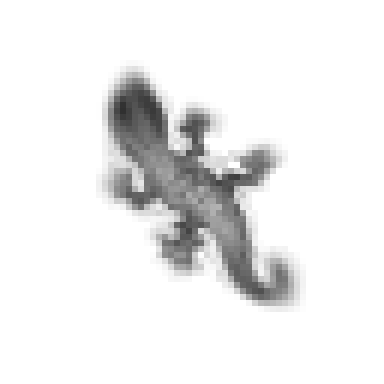

Training Steps Completed: 148
Loss:
0.00402967725
(64, 64, 16)


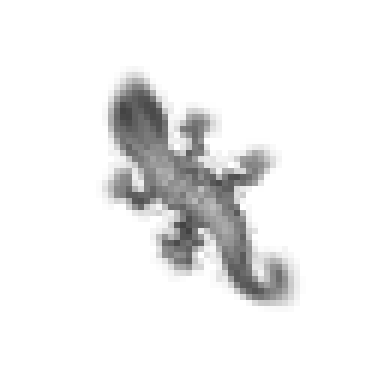

Training Steps Completed: 149
Loss:
0.00514460448
(64, 64, 16)


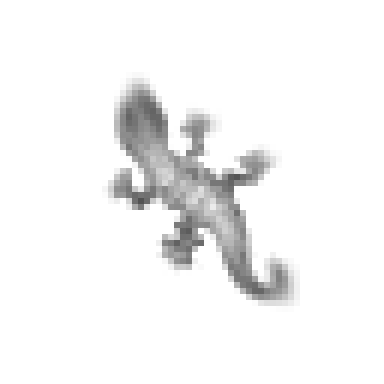

Training Steps Completed: 150
Loss:
0.00473842677
(64, 64, 16)


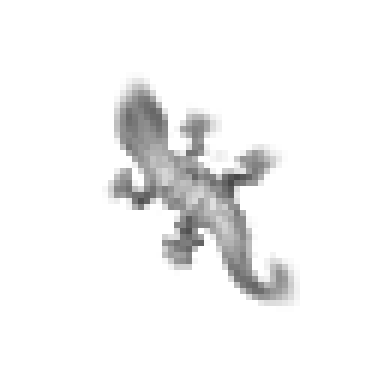

Training Steps Completed: 151
Loss:
0.00436816039
(64, 64, 16)


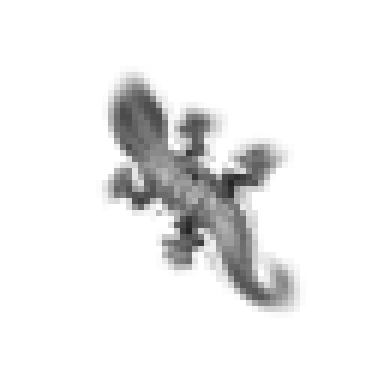

Training Steps Completed: 152
Loss:
0.00599171221
(64, 64, 16)


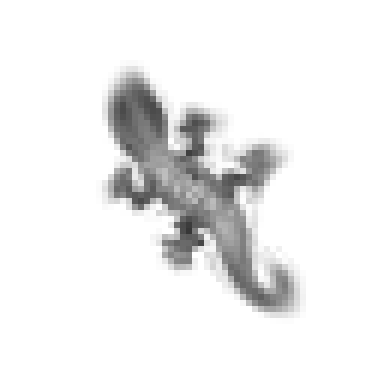

Training Steps Completed: 153
Loss:
0.00342589
(64, 64, 16)


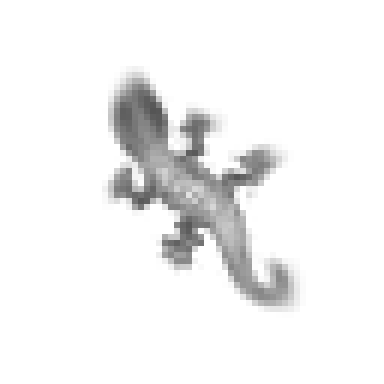

Training Steps Completed: 154
Loss:
0.00342326751
(64, 64, 16)


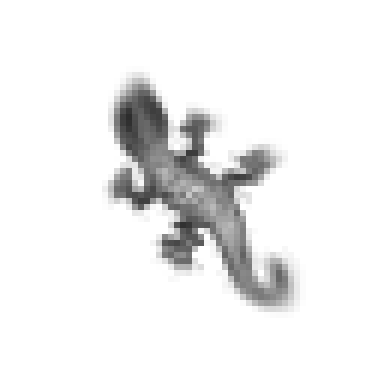

Training Steps Completed: 155
Loss:
0.00456696888
(64, 64, 16)


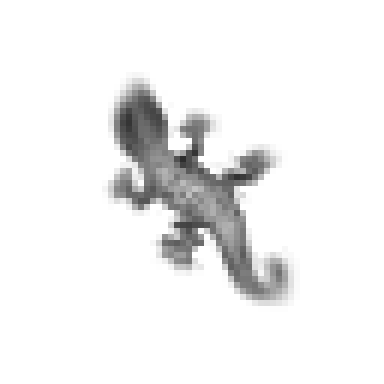

Training Steps Completed: 156
Loss:
0.00532436371
(64, 64, 16)


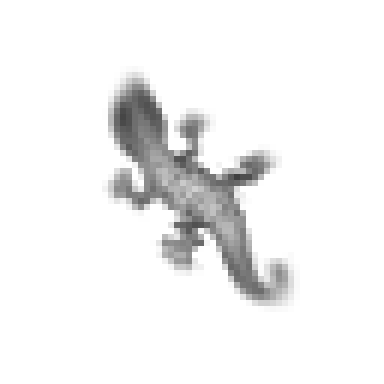

Training Steps Completed: 157
Loss:
0.00471892767
(64, 64, 16)


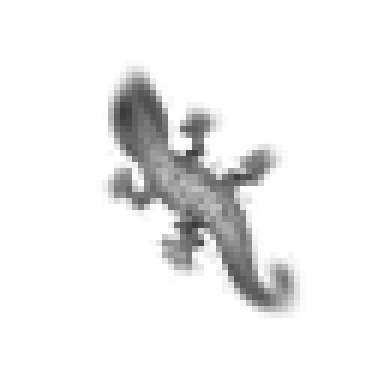

Training Steps Completed: 158
Loss:
0.0039391364
(64, 64, 16)


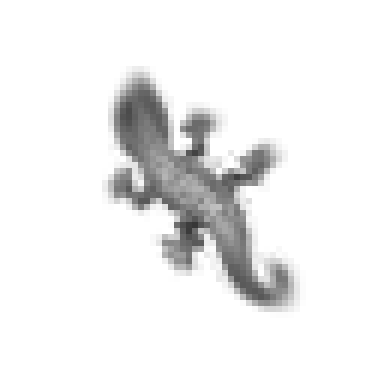

Training Steps Completed: 159
Loss:
0.00421824399
(64, 64, 16)


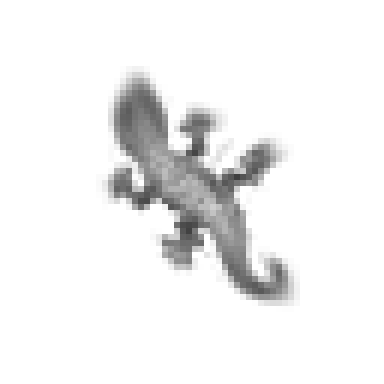

Training Steps Completed: 160
Loss:
0.00384891662
(64, 64, 16)


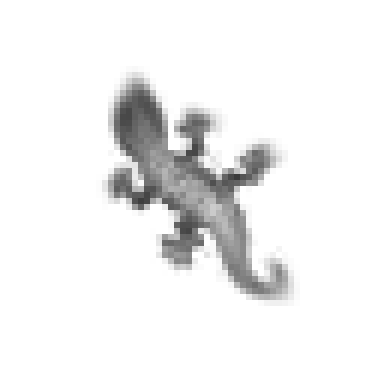

Training Steps Completed: 161
Loss:
0.00478817942
(64, 64, 16)


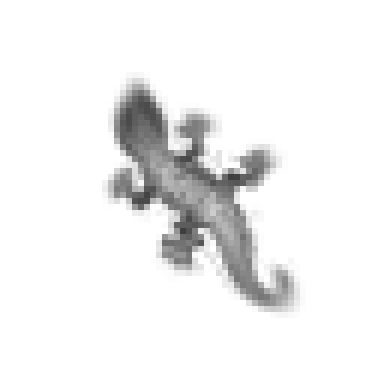

Training Steps Completed: 162
Loss:
0.00495441025
(64, 64, 16)


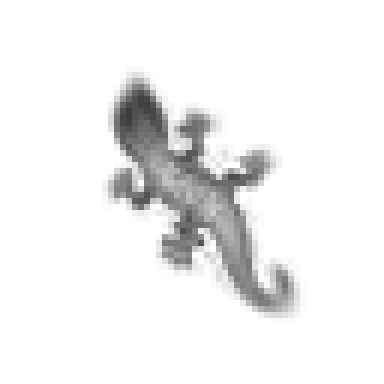

Training Steps Completed: 163
Loss:
0.00393091887
(64, 64, 16)


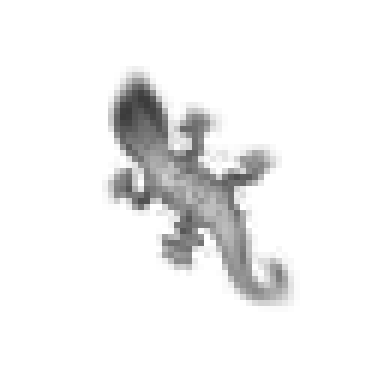

Training Steps Completed: 164
Loss:
0.00338064227
(64, 64, 16)


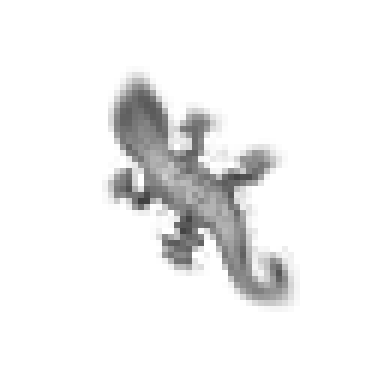

Training Steps Completed: 165
Loss:
0.00498861
(64, 64, 16)


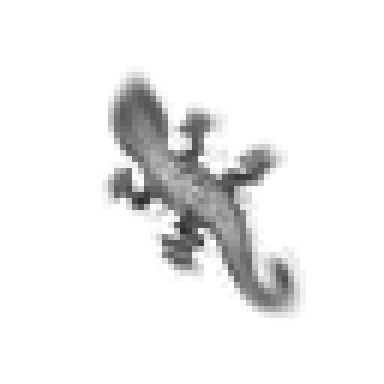

Training Steps Completed: 166
Loss:
0.00348380464
(64, 64, 16)


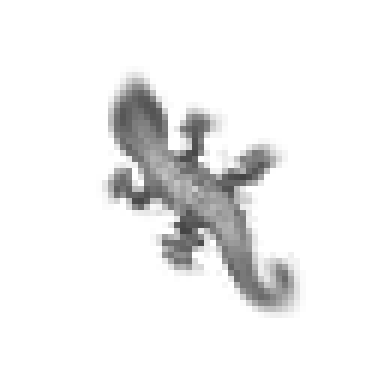

Training Steps Completed: 167
Loss:
0.00468835933
(64, 64, 16)


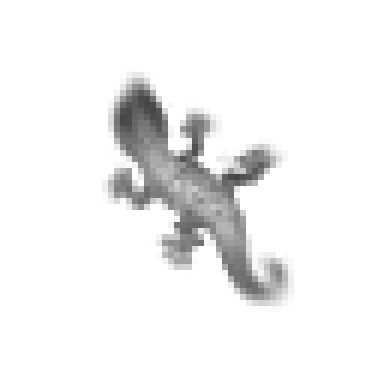

Training Steps Completed: 168
Loss:
0.00590021815
(64, 64, 16)


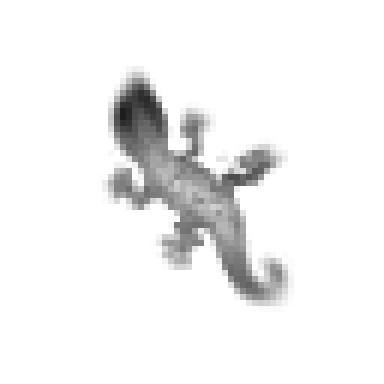

Training Steps Completed: 169
Loss:
0.00395140611
(64, 64, 16)


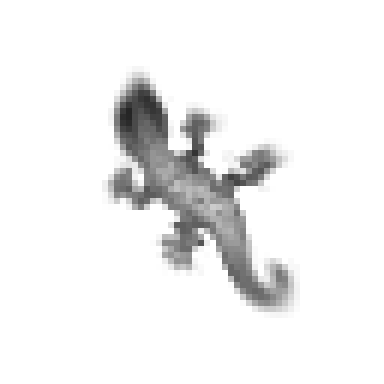

Training Steps Completed: 170
Loss:
0.00548883388
(64, 64, 16)


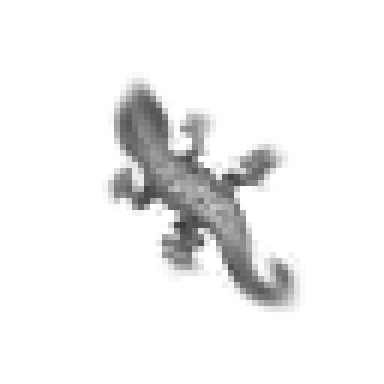

Training Steps Completed: 171
Loss:
0.00418461068
(64, 64, 16)


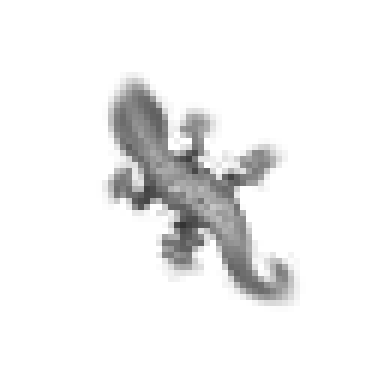

Training Steps Completed: 172
Loss:
0.00695484597
(64, 64, 16)


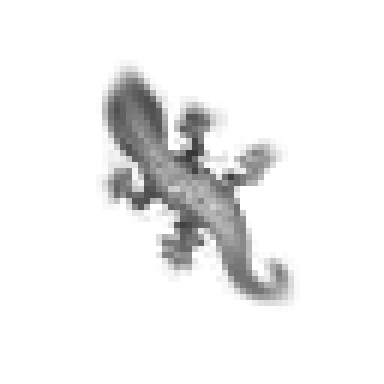

Training Steps Completed: 173
Loss:
0.00666867103
(64, 64, 16)


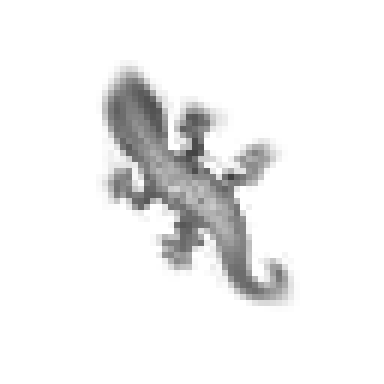

Training Steps Completed: 174
Loss:
0.00437203655
(64, 64, 16)


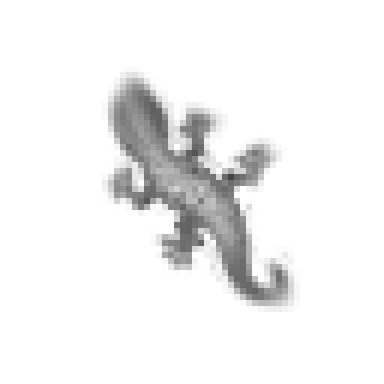

Training Steps Completed: 175
Loss:
0.00471232273
(64, 64, 16)


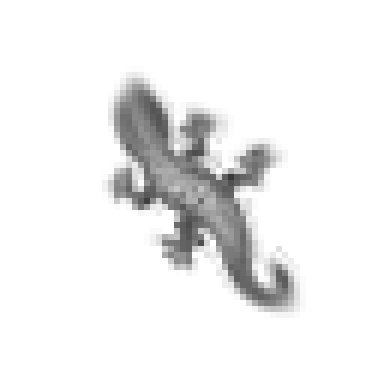

Training Steps Completed: 176
Loss:
0.00396030955
(64, 64, 16)


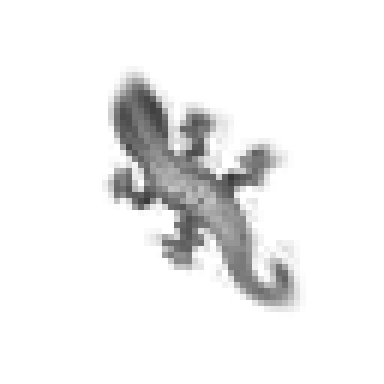

Training Steps Completed: 177
Loss:
0.00341745187
(64, 64, 16)


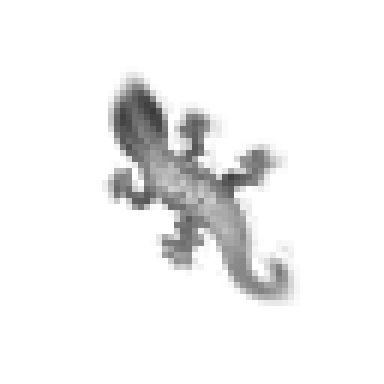

Training Steps Completed: 178
Loss:
0.0038001053
(64, 64, 16)


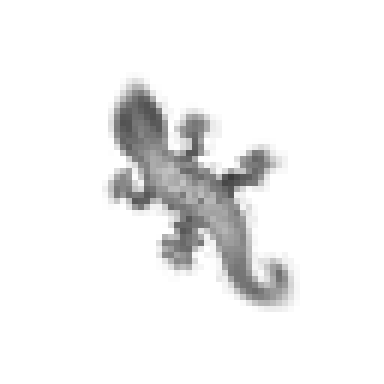

Training Steps Completed: 179
Loss:
0.00470478227
(64, 64, 16)


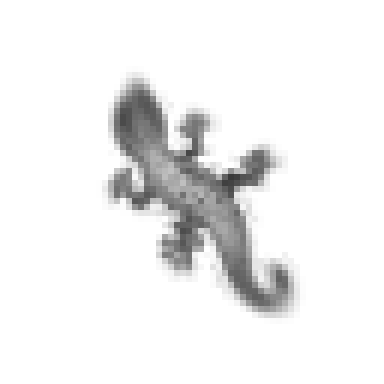

Training Steps Completed: 180
Loss:
0.00302356202
(64, 64, 16)


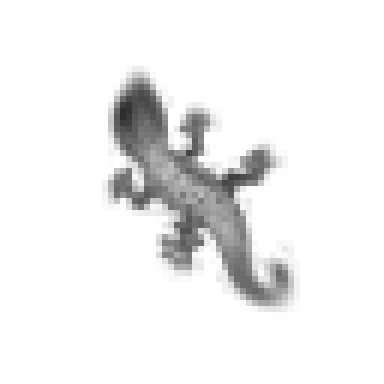

Training Steps Completed: 181
Loss:
0.00488203764
(64, 64, 16)


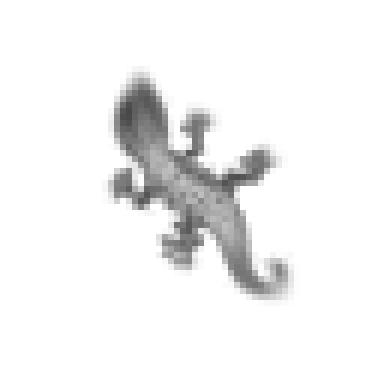

Training Steps Completed: 182
Loss:
0.00398316747
(64, 64, 16)


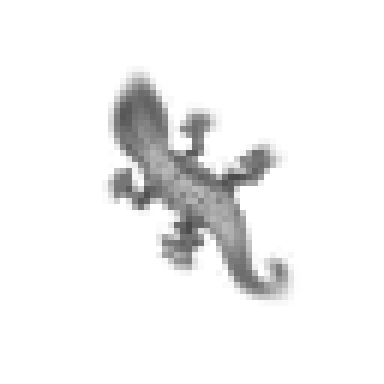

Training Steps Completed: 183
Loss:
0.00469653914
(64, 64, 16)


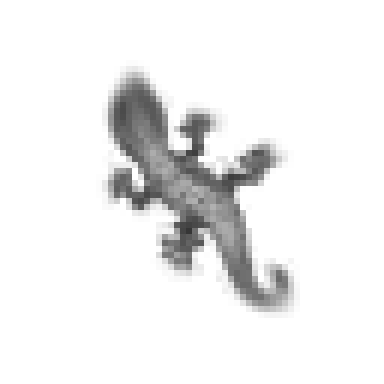

Training Steps Completed: 184
Loss:
0.0050762929
(64, 64, 16)


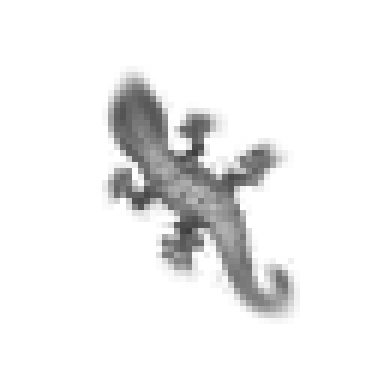

Training Steps Completed: 185
Loss:
0.00361014763
(64, 64, 16)


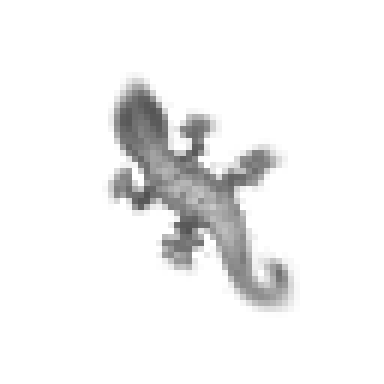

Training Steps Completed: 186
Loss:
0.00326505187
(64, 64, 16)


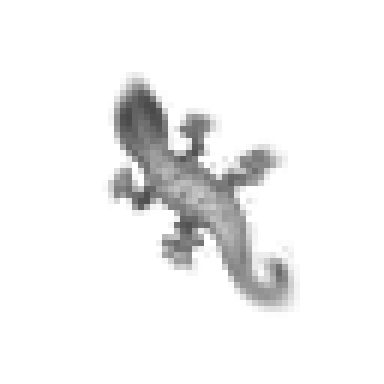

Training Steps Completed: 187
Loss:
0.00528541068
(64, 64, 16)


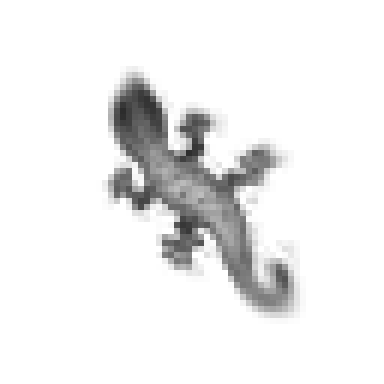

Training Steps Completed: 188
Loss:
0.00494819786
(64, 64, 16)


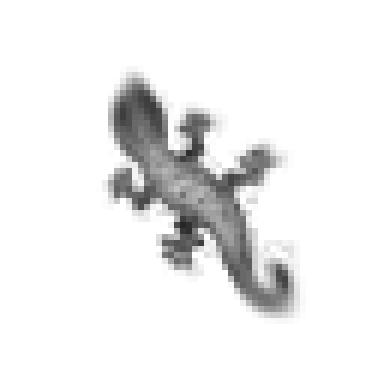

Training Steps Completed: 189
Loss:
0.00277597597
(64, 64, 16)


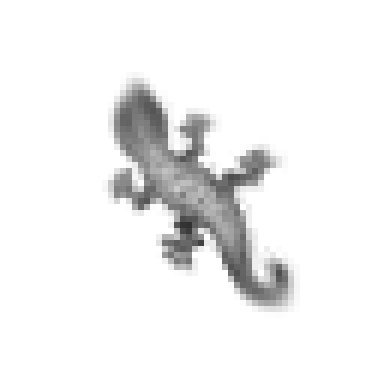

Training Steps Completed: 190
Loss:
0.00304444553
(64, 64, 16)


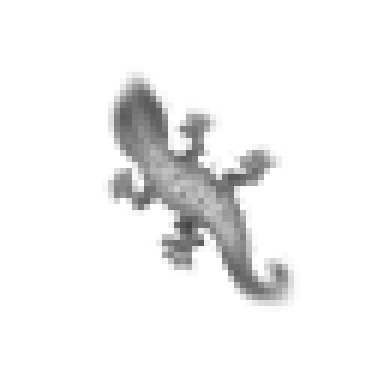

Training Steps Completed: 191
Loss:
0.0033771228
(64, 64, 16)


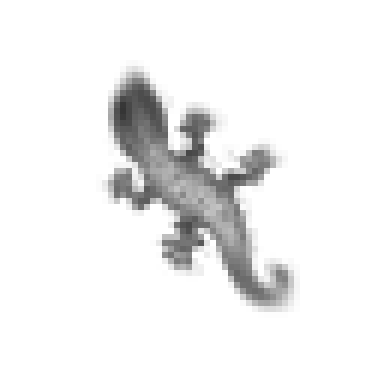

Training Steps Completed: 192
Loss:
0.00336490851
(64, 64, 16)


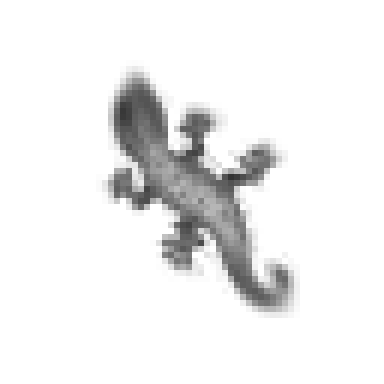

Training Steps Completed: 193
Loss:
0.0027163839
(64, 64, 16)


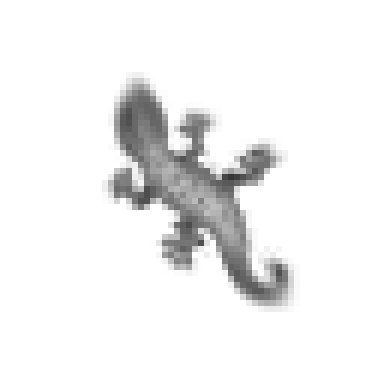

Training Steps Completed: 194
Loss:
0.00290746102
(64, 64, 16)


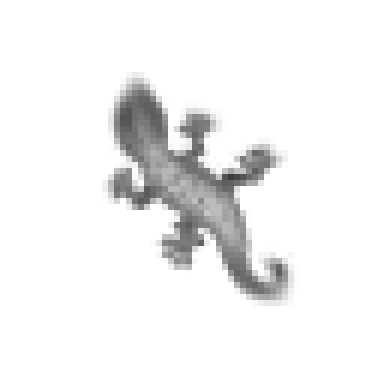

Training Steps Completed: 195
Loss:
0.00335039245
(64, 64, 16)


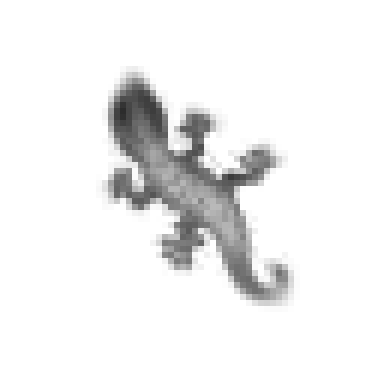

Training Steps Completed: 196
Loss:
0.00349259
(64, 64, 16)


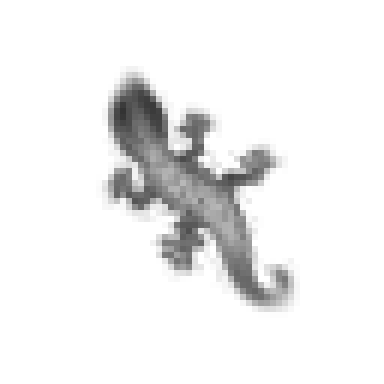

Training Steps Completed: 197
Loss:
0.00330338953
(64, 64, 16)


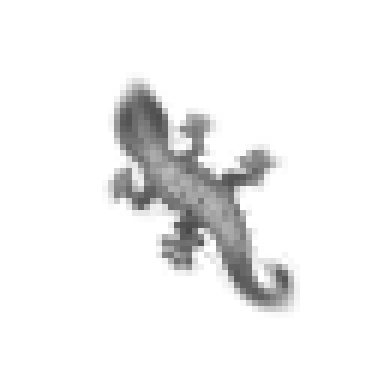

Training Steps Completed: 198
Loss:
0.00321643171
(64, 64, 16)


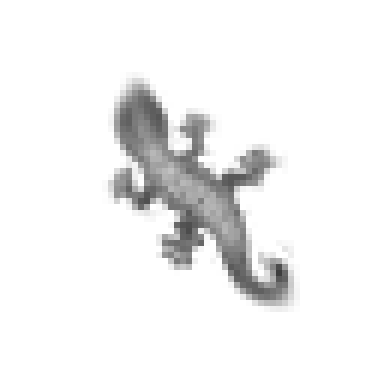

Training Steps Completed: 199
Loss:
0.00296111358
(64, 64, 16)


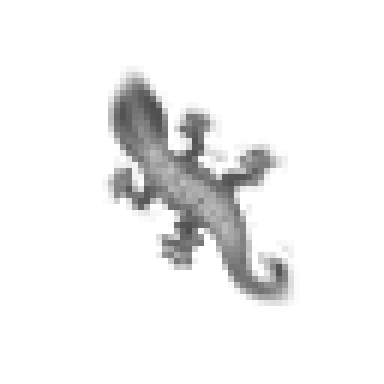

Training Steps Completed: 200
Loss:
0.00275365985
(64, 64, 16)


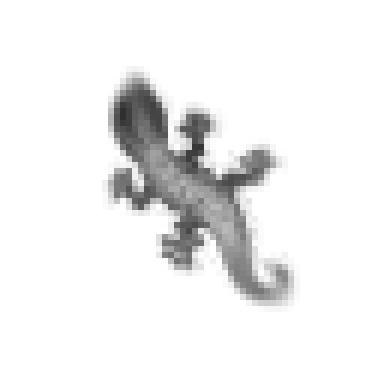

Training Steps Completed: 201
Loss:
0.00425601471
(64, 64, 16)


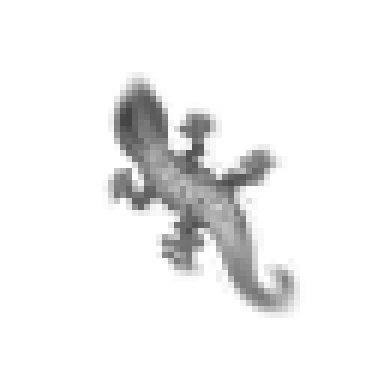

Training Steps Completed: 202
Loss:
0.00446775276
(64, 64, 16)


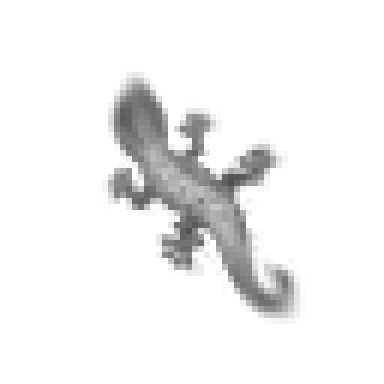

Training Steps Completed: 203
Loss:
0.00380700547
(64, 64, 16)


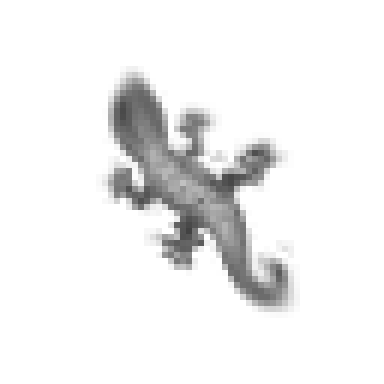

Training Steps Completed: 204
Loss:
0.00418087514
(64, 64, 16)


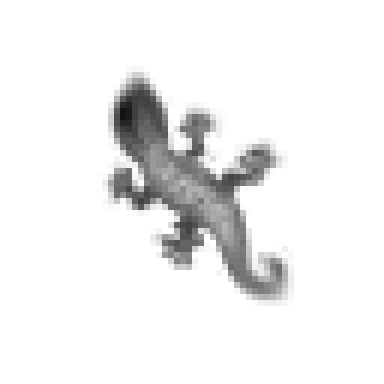

Training Steps Completed: 205
Loss:
0.00520860963
(64, 64, 16)


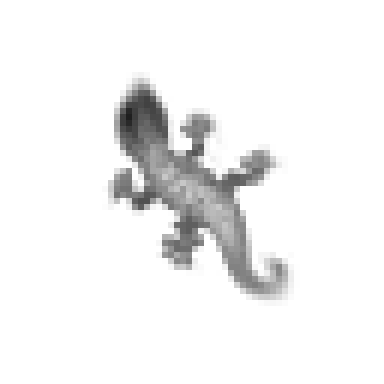

Training Steps Completed: 206
Loss:
0.00383064058
(64, 64, 16)


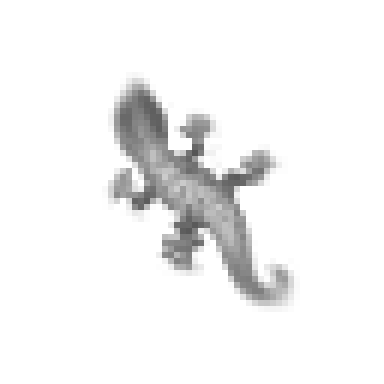

Training Steps Completed: 207
Loss:
0.00641818298
(64, 64, 16)


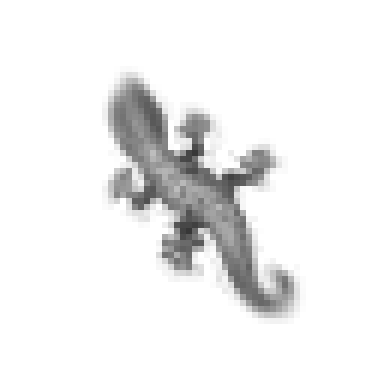

Training Steps Completed: 208
Loss:
0.00650384324
(64, 64, 16)


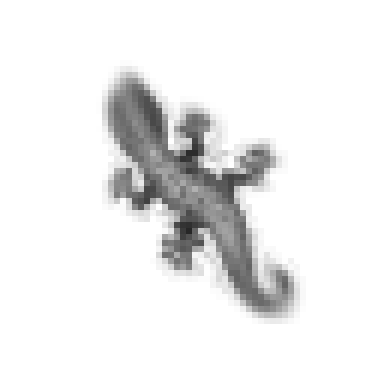

Training Steps Completed: 209
Loss:
0.00375962816
(64, 64, 16)


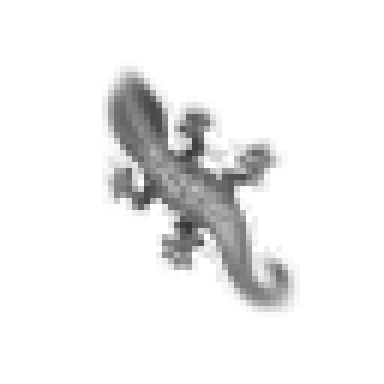

Training Steps Completed: 210
Loss:
0.00329818018
(64, 64, 16)


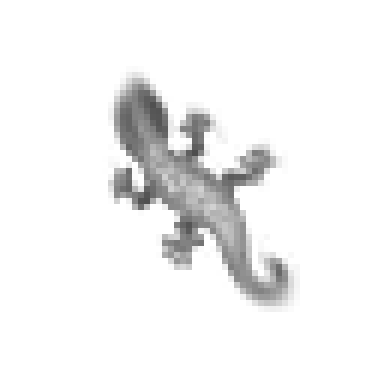

Training Steps Completed: 211
Loss:
0.00290544261
(64, 64, 16)


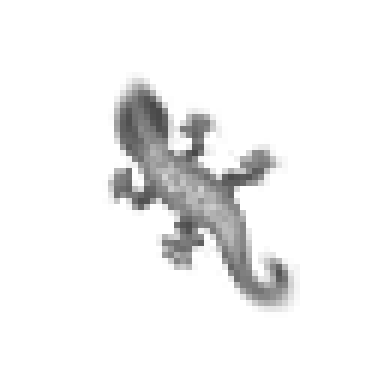

Training Steps Completed: 212
Loss:
0.00291109
(64, 64, 16)


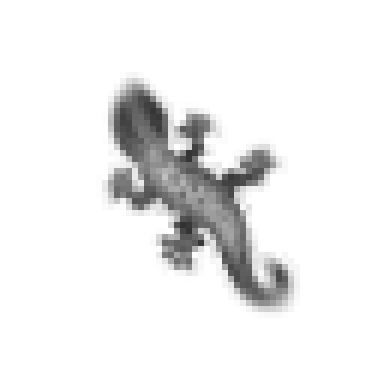

Training Steps Completed: 213
Loss:
0.00305596297
(64, 64, 16)


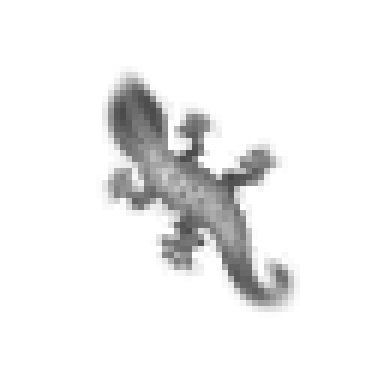

Training Steps Completed: 214
Loss:
0.00277271913
(64, 64, 16)


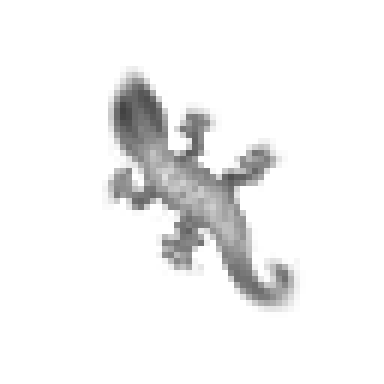

Training Steps Completed: 215
Loss:
0.0031092
(64, 64, 16)


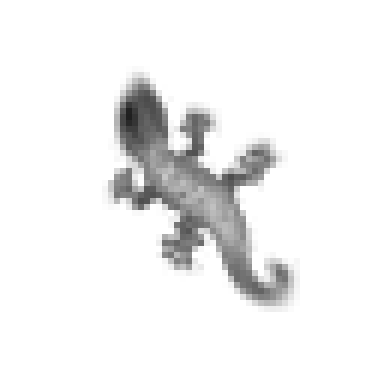

Training Steps Completed: 216
Loss:
0.00315686734
(64, 64, 16)


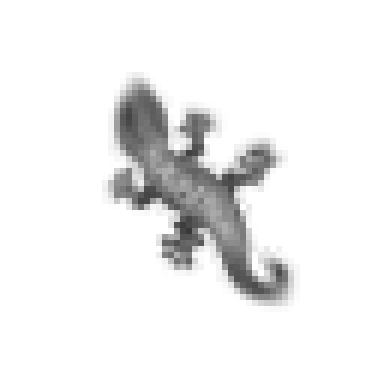

Training Steps Completed: 217
Loss:
0.00296072103
(64, 64, 16)


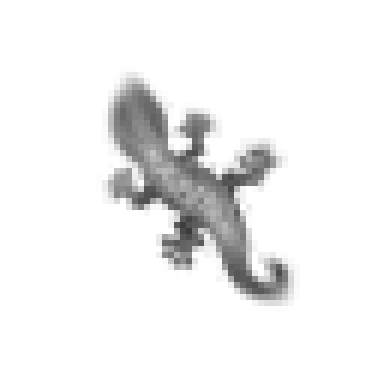

Training Steps Completed: 218
Loss:
0.00377410371
(64, 64, 16)


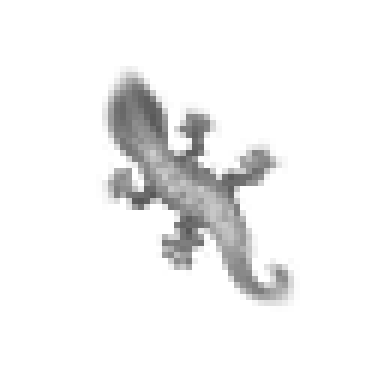

Training Steps Completed: 219
Loss:
0.00371381268
(64, 64, 16)


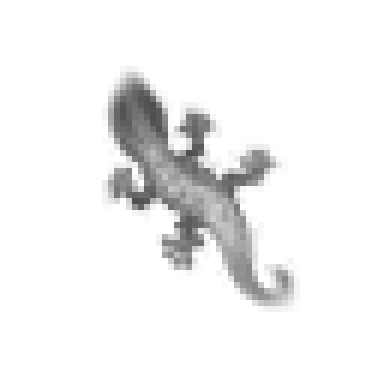

Training Steps Completed: 220
Loss:
0.00490739057
(64, 64, 16)


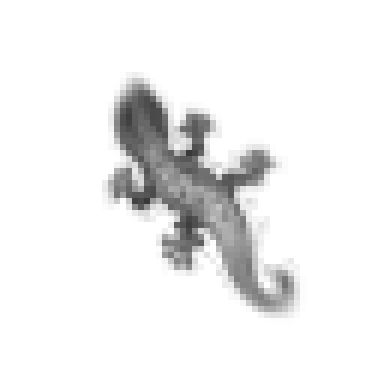

Training Steps Completed: 221
Loss:
0.0056547327
(64, 64, 16)


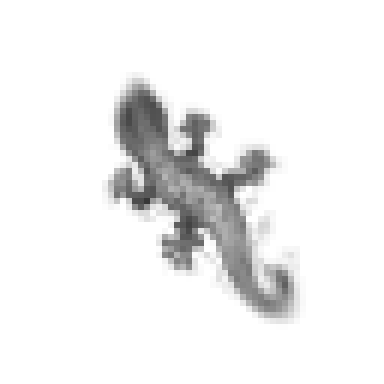

Training Steps Completed: 222
Loss:
0.00365513191
(64, 64, 16)


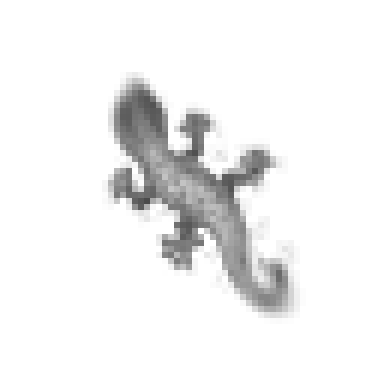

Training Steps Completed: 223
Loss:
0.00382557395
(64, 64, 16)


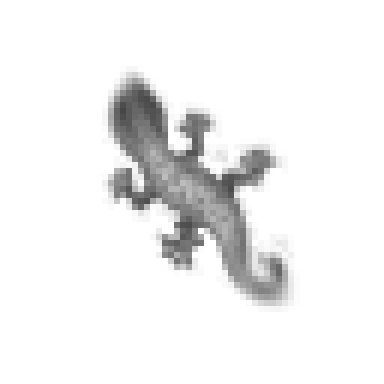

Training Steps Completed: 224
Loss:
0.00368947629
(64, 64, 16)


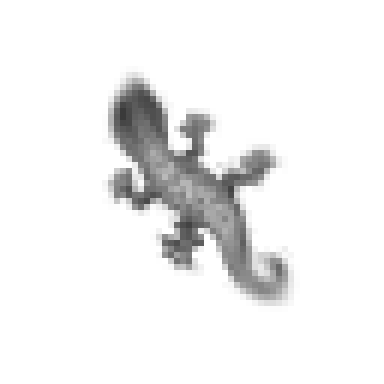

Training Steps Completed: 225
Loss:
0.00343872048
(64, 64, 16)


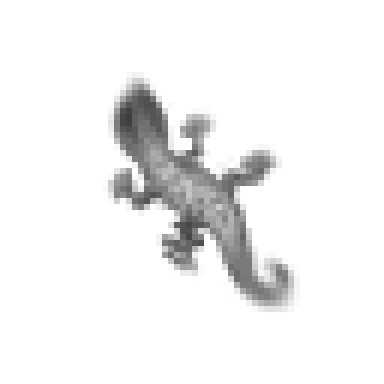

Training Steps Completed: 226
Loss:
0.00471872976
(64, 64, 16)


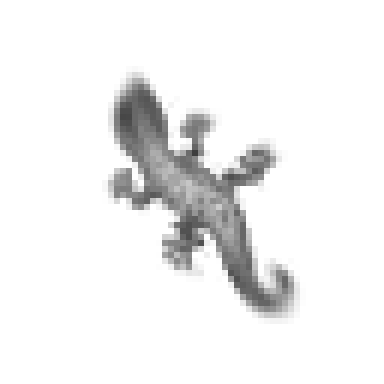

Training Steps Completed: 227
Loss:
0.00487400778
(64, 64, 16)


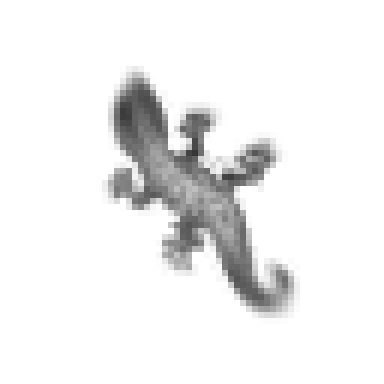

Training Steps Completed: 228
Loss:
0.00387972943
(64, 64, 16)


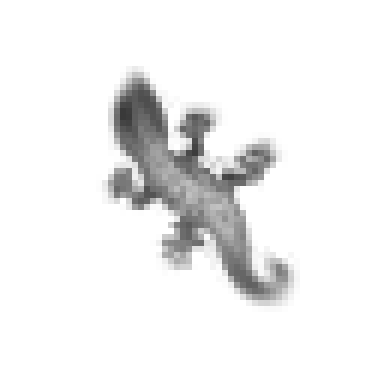

Training Steps Completed: 229
Loss:
0.00316338497
(64, 64, 16)


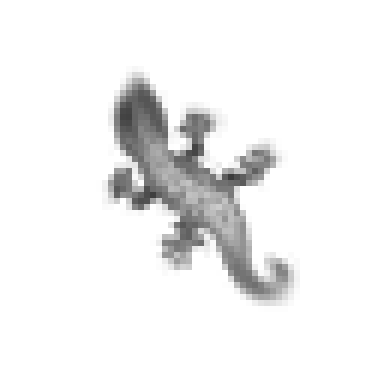

Training Steps Completed: 230
Loss:
0.00274285441
(64, 64, 16)


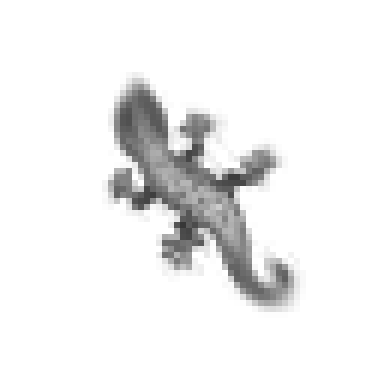

Training Steps Completed: 231
Loss:
0.00264926651
(64, 64, 16)


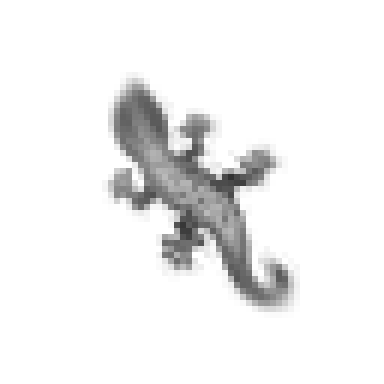

Training Steps Completed: 232
Loss:
0.00301236077
(64, 64, 16)


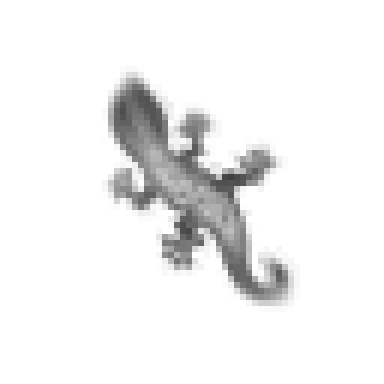

Training Steps Completed: 233
Loss:
0.00286735152
(64, 64, 16)


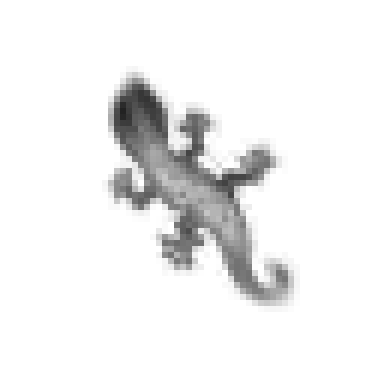

Training Steps Completed: 234
Loss:
0.00301011931
(64, 64, 16)


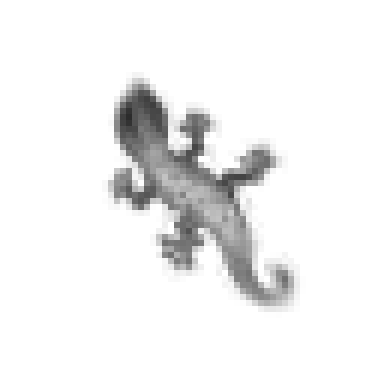

Training Steps Completed: 235
Loss:
0.00397250243
(64, 64, 16)


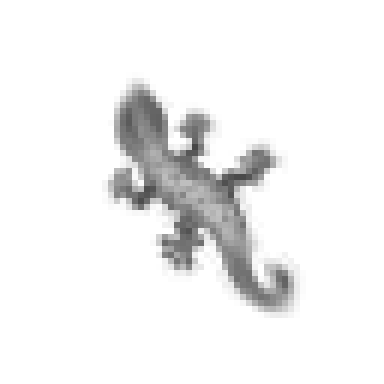

Training Steps Completed: 236
Loss:
0.00361576607
(64, 64, 16)


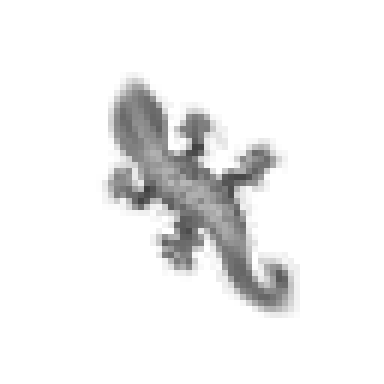

Training Steps Completed: 237
Loss:
0.00411778362
(64, 64, 16)


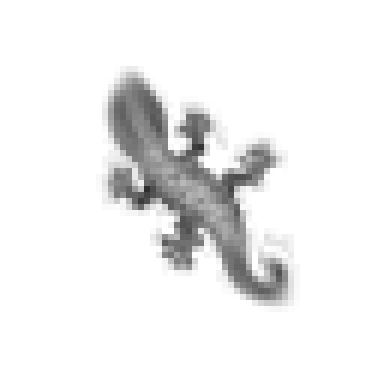

Training Steps Completed: 238
Loss:
0.0053415671
(64, 64, 16)


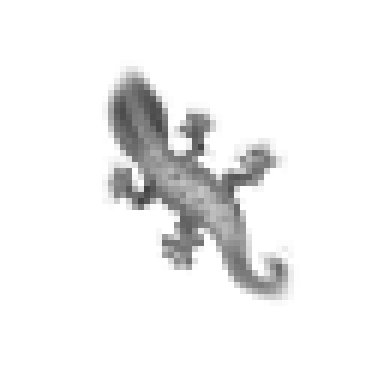

Training Steps Completed: 239
Loss:
0.00439613732
(64, 64, 16)


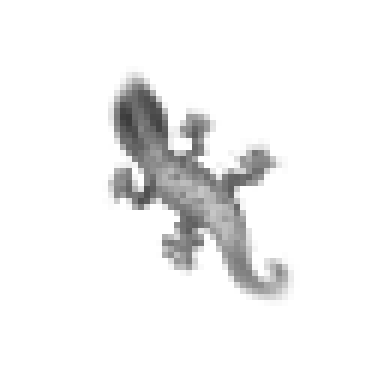

Training Steps Completed: 240
Loss:
0.00427860441
(64, 64, 16)


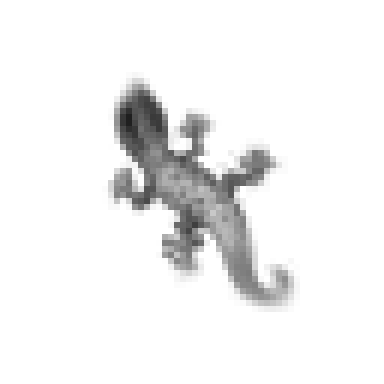

Training Steps Completed: 241
Loss:
0.00670283381
(64, 64, 16)


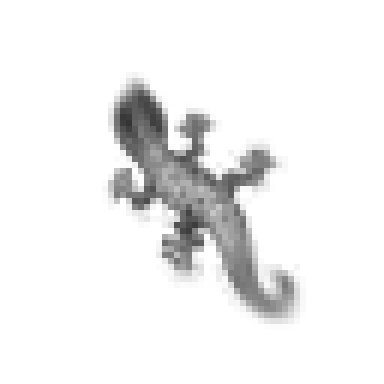

Training Steps Completed: 242
Loss:
0.00624731556
(64, 64, 16)


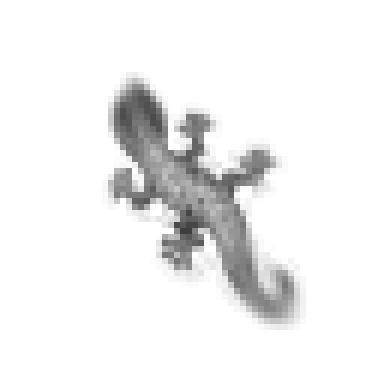

Training Steps Completed: 243
Loss:
0.00413133483
(64, 64, 16)


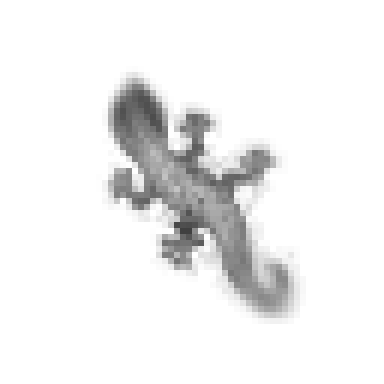

Training Steps Completed: 244
Loss:
0.00380034652
(64, 64, 16)


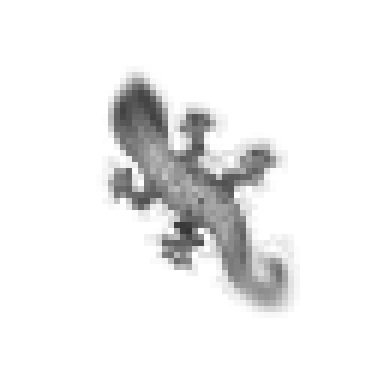

Training Steps Completed: 245
Loss:
0.00428055041
(64, 64, 16)


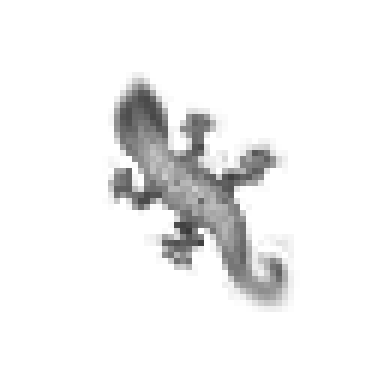

Training Steps Completed: 246
Loss:
0.00476103043
(64, 64, 16)


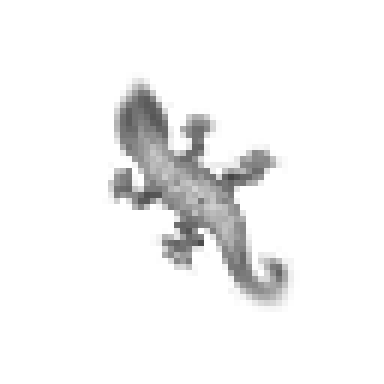

Training Steps Completed: 247
Loss:
0.00322243571
(64, 64, 16)


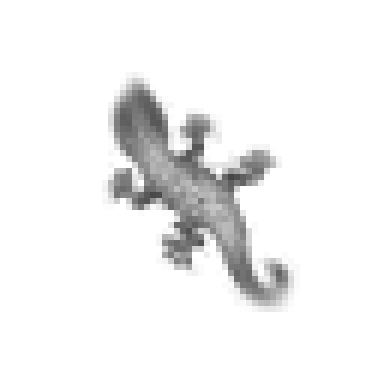

Training Steps Completed: 248
Loss:
0.00492694555
(64, 64, 16)


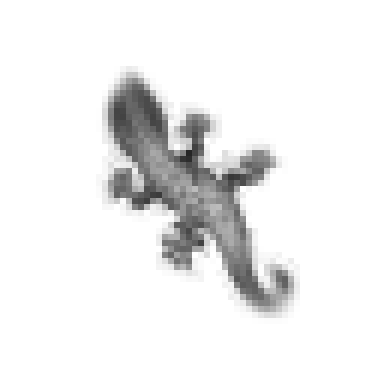

Training Steps Completed: 249
Loss:
0.00544432923
(64, 64, 16)


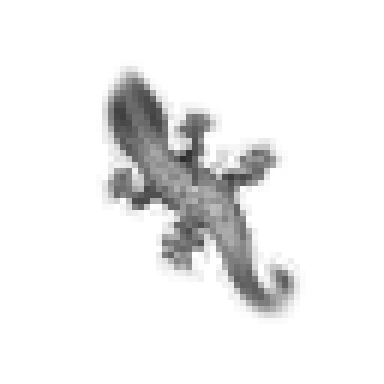

Training Steps Completed: 250
Loss:
0.00273759174
(64, 64, 16)


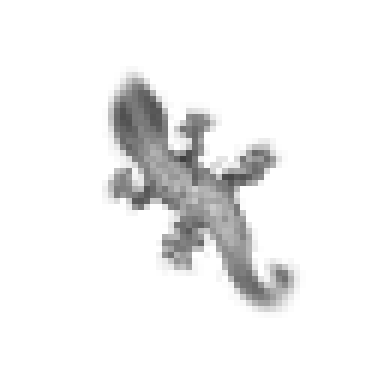

Training Steps Completed: 251
Loss:
0.00301989145
(64, 64, 16)


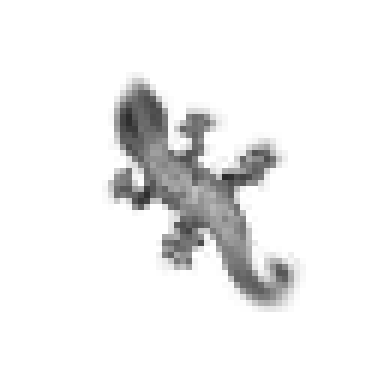

Training Steps Completed: 252
Loss:
0.00326549425
(64, 64, 16)


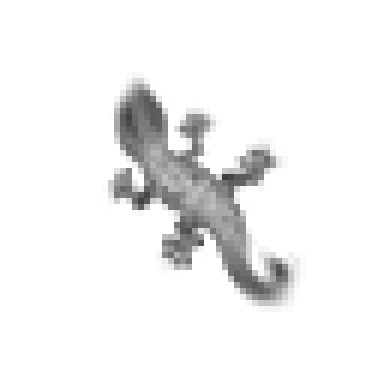

Training Steps Completed: 253
Loss:
0.00253750524
(64, 64, 16)


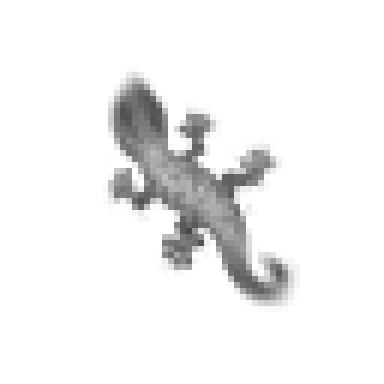

Training Steps Completed: 254
Loss:
0.00375286886
(64, 64, 16)


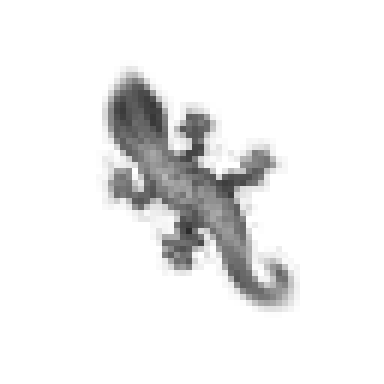

Training Steps Completed: 255
Loss:
0.00338942511
(64, 64, 16)


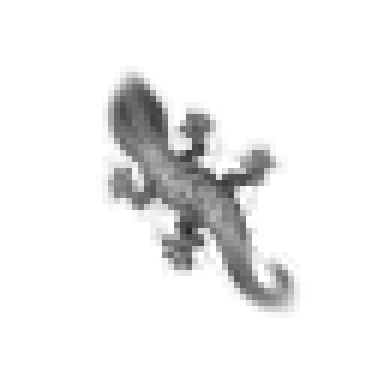

Training Steps Completed: 256
Loss:
0.0031214729
(64, 64, 16)


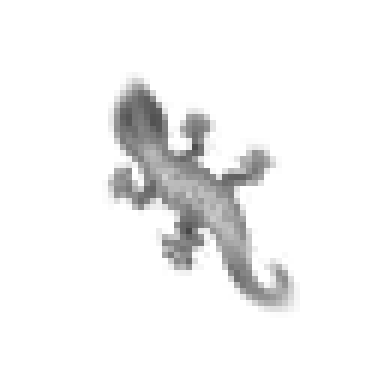

Training Steps Completed: 257
Loss:
0.00336871319
(64, 64, 16)


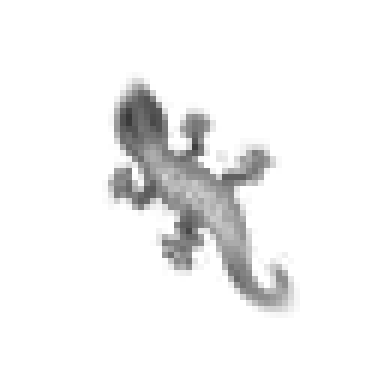

Training Steps Completed: 258
Loss:
0.00363442977
(64, 64, 16)


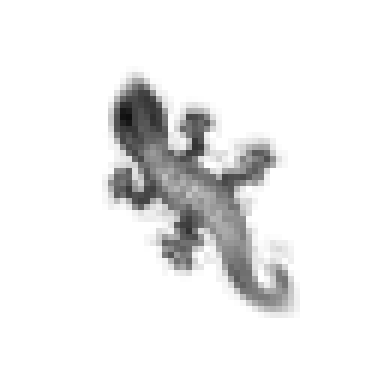

Training Steps Completed: 259
Loss:
0.0027270373
(64, 64, 16)


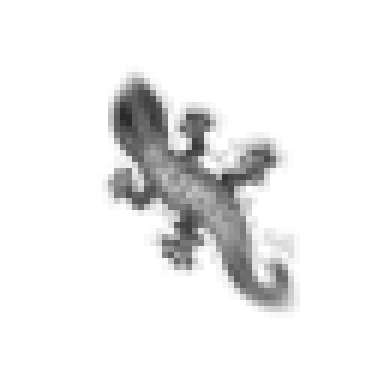

Training Steps Completed: 260
Loss:
0.00335961767
(64, 64, 16)


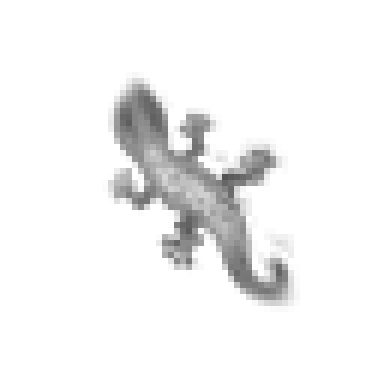

Training Steps Completed: 261
Loss:
0.00344333984
(64, 64, 16)


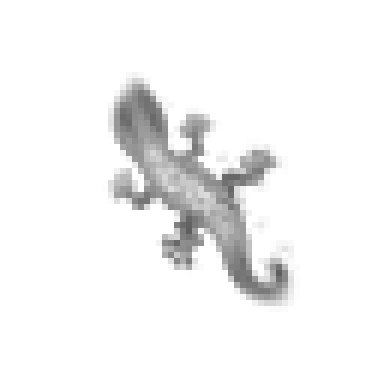

Training Steps Completed: 262
Loss:
0.00284855487
(64, 64, 16)


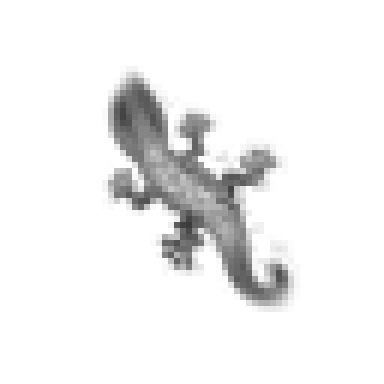

Training Steps Completed: 263
Loss:
0.00260803057
(64, 64, 16)


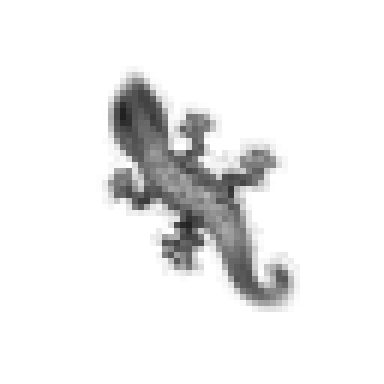

Training Steps Completed: 264
Loss:
0.00258847419
(64, 64, 16)


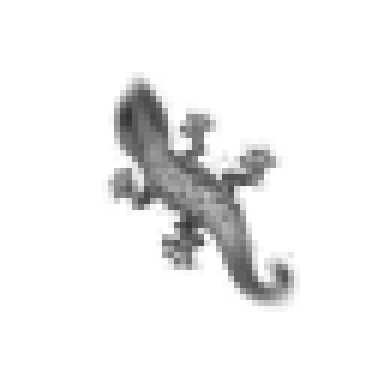

Training Steps Completed: 265
Loss:
0.00257010106
(64, 64, 16)


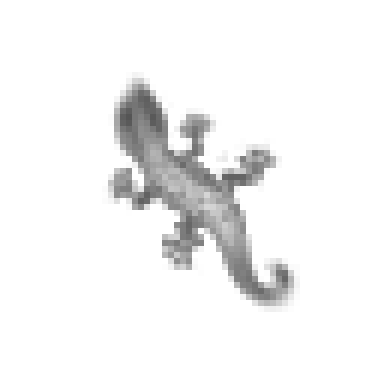

Training Steps Completed: 266
Loss:
0.00244111149
(64, 64, 16)


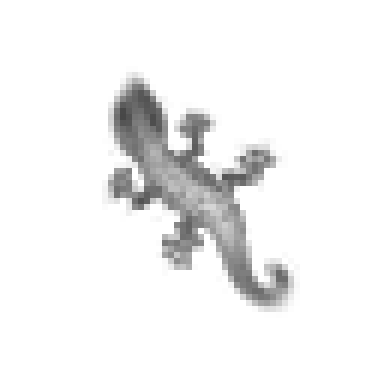

Training Steps Completed: 267
Loss:
0.00251904409
(64, 64, 16)


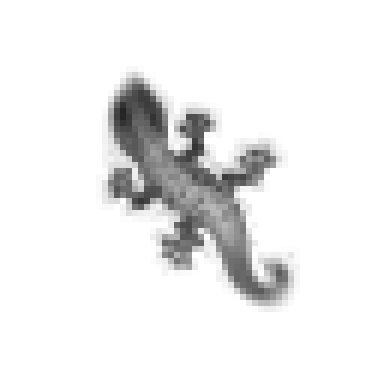

Training Steps Completed: 268
Loss:
0.00213254732
(64, 64, 16)


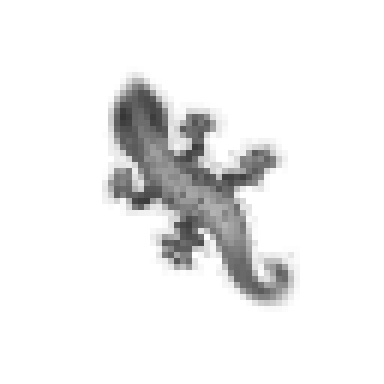

Training Steps Completed: 269
Loss:
0.00190359214
(64, 64, 16)


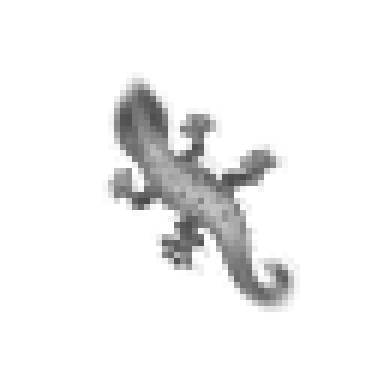

Training Steps Completed: 270
Loss:
0.00207953621
(64, 64, 16)


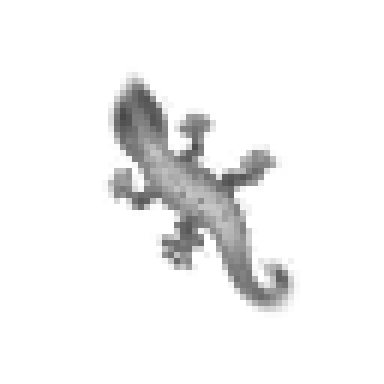

Training Steps Completed: 271
Loss:
0.00199095509
(64, 64, 16)


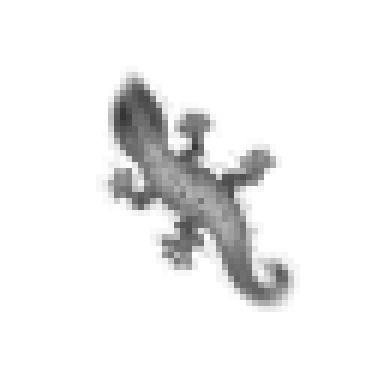

Training Steps Completed: 272
Loss:
0.00148196402
(64, 64, 16)


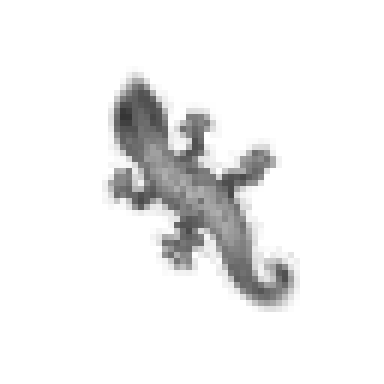

Training Steps Completed: 273
Loss:
0.00227858033
(64, 64, 16)


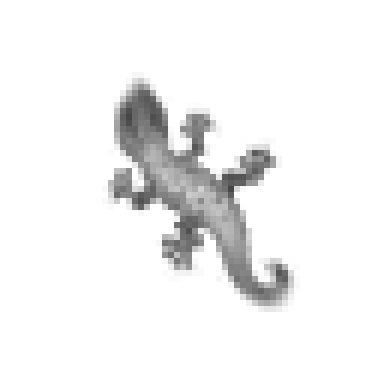

Training Steps Completed: 274
Loss:
0.0024620085
(64, 64, 16)


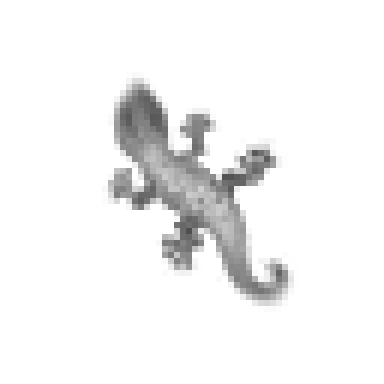

Training Steps Completed: 275
Loss:
0.00193358213
(64, 64, 16)


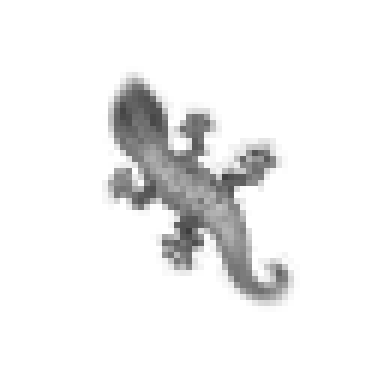

Training Steps Completed: 276
Loss:
0.00433284696
(64, 64, 16)


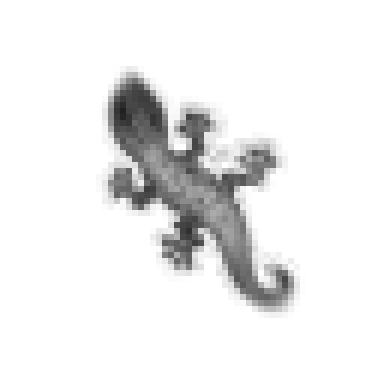

Training Steps Completed: 277
Loss:
0.00441193162
(64, 64, 16)


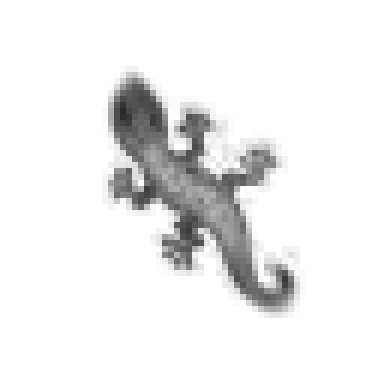

Training Steps Completed: 278
Loss:
0.00161736028
(64, 64, 16)


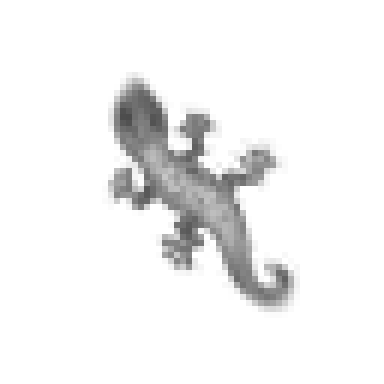

Training Steps Completed: 279
Loss:
0.00175055908
(64, 64, 16)


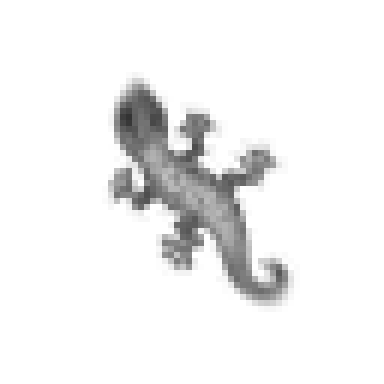

Training Steps Completed: 280
Loss:
0.00170831638
(64, 64, 16)


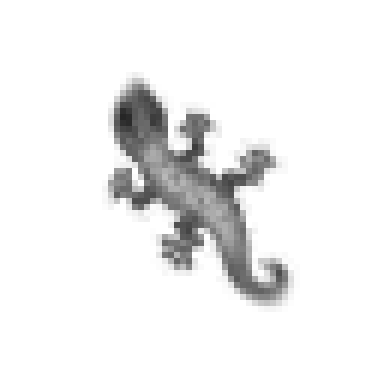

Training Steps Completed: 281
Loss:
0.00152771873
(64, 64, 16)


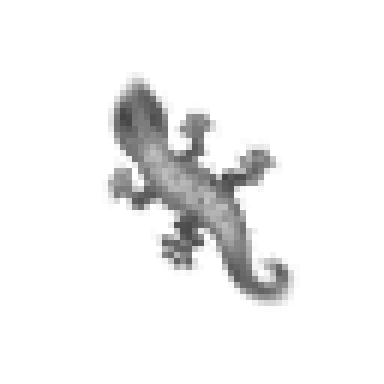

Training Steps Completed: 282
Loss:
0.00197199383
(64, 64, 16)


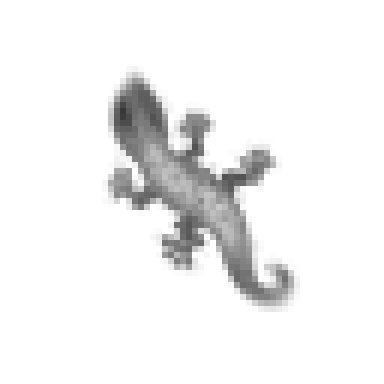

Training Steps Completed: 283
Loss:
0.0054754
(64, 64, 16)


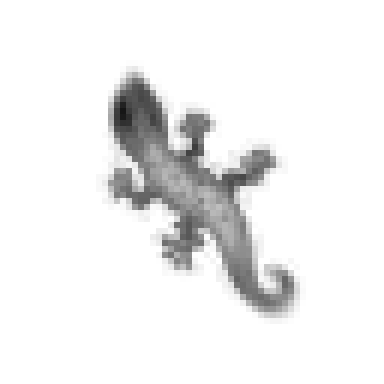

Training Steps Completed: 284
Loss:
0.00463492936
(64, 64, 16)


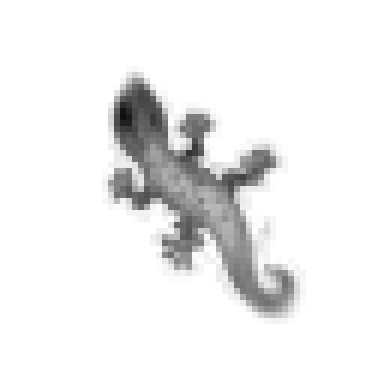

Training Steps Completed: 285
Loss:
0.0026435249
(64, 64, 16)


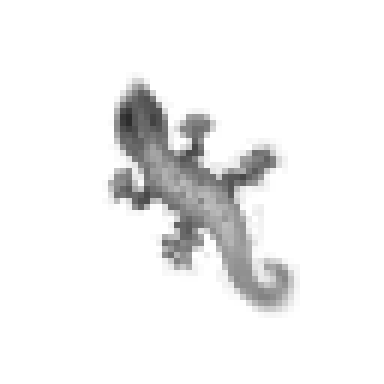

Training Steps Completed: 286
Loss:
0.00272527128
(64, 64, 16)


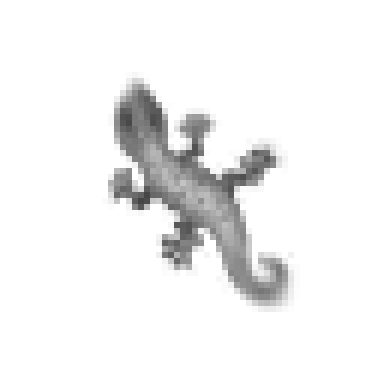

Training Steps Completed: 287
Loss:
0.00254249503
(64, 64, 16)


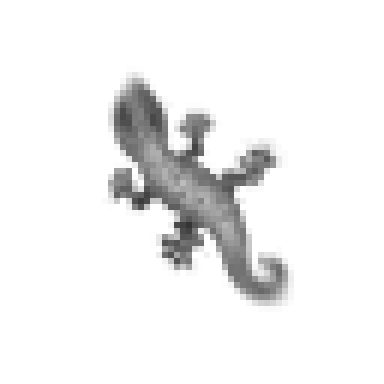

Training Steps Completed: 288
Loss:
0.00274505559
(64, 64, 16)


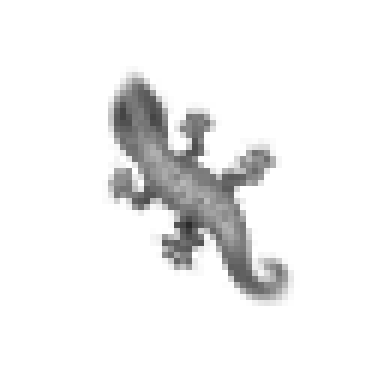

Training Steps Completed: 289
Loss:
0.00225003739
(64, 64, 16)


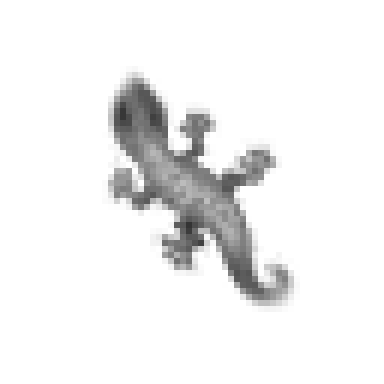

Training Steps Completed: 290
Loss:
0.00442646118
(64, 64, 16)


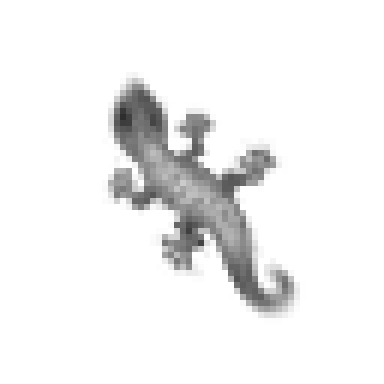

Training Steps Completed: 291
Loss:
0.00476977229
(64, 64, 16)


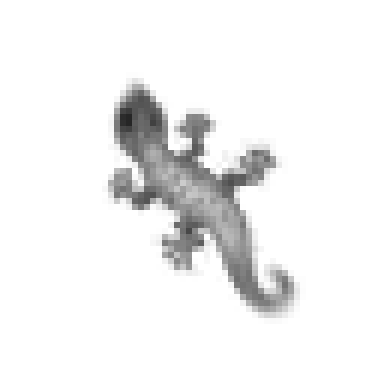

Training Steps Completed: 292
Loss:
0.00282546
(64, 64, 16)


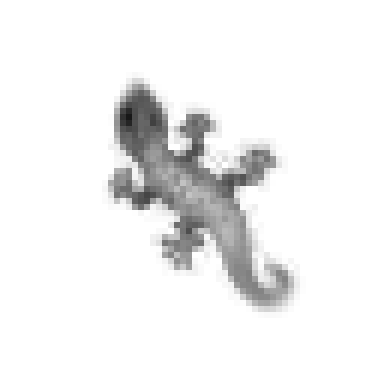

Training Steps Completed: 293
Loss:
0.00241994811
(64, 64, 16)


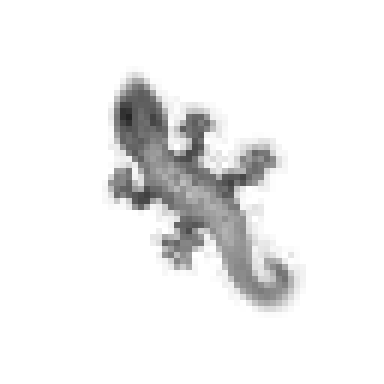

Training Steps Completed: 294
Loss:
0.00290423376
(64, 64, 16)


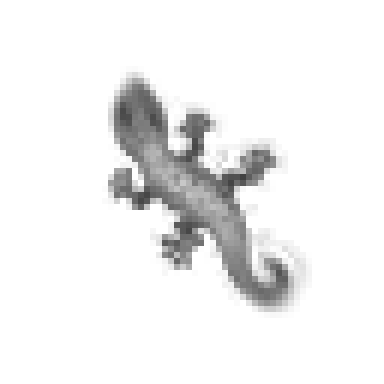

Training Steps Completed: 295
Loss:
0.00329605862
(64, 64, 16)


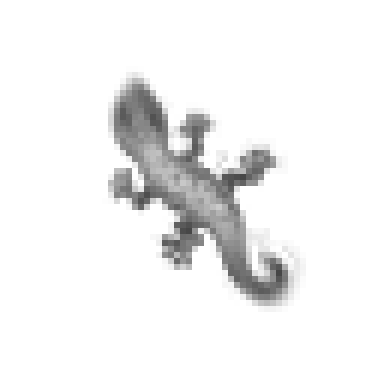

Training Steps Completed: 296
Loss:
0.00609266479
(64, 64, 16)


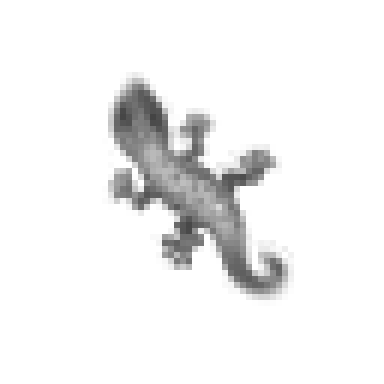

Training Steps Completed: 297
Loss:
0.00693836249
(64, 64, 16)


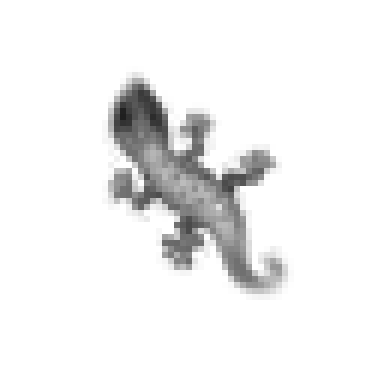

Training Steps Completed: 298
Loss:
0.00606157025
(64, 64, 16)


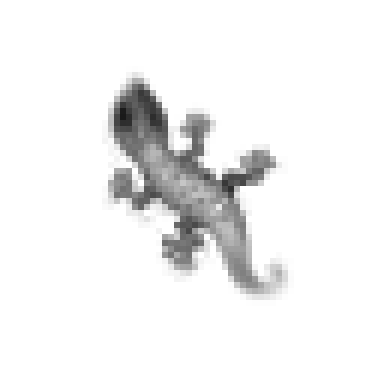

Training Steps Completed: 299
Loss:
0.00460308231
(64, 64, 16)


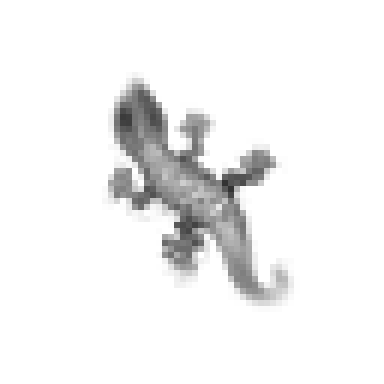

Training Steps Completed: 300
Loss:
0.00640526414
(64, 64, 16)


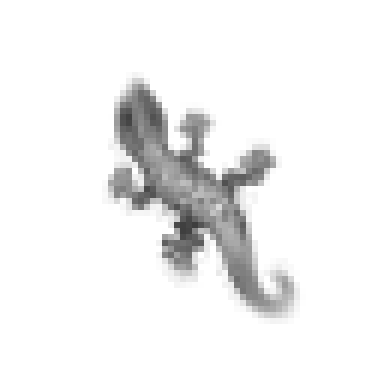

Training Steps Completed: 301
Loss:
0.00728198793
(64, 64, 16)


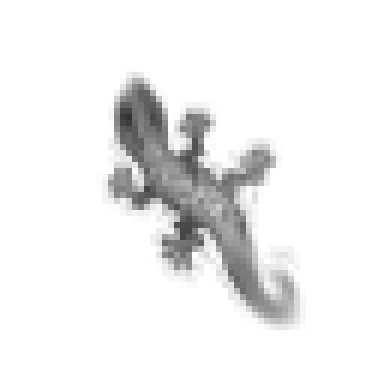

Training Steps Completed: 302
Loss:
0.00721202651
(64, 64, 16)


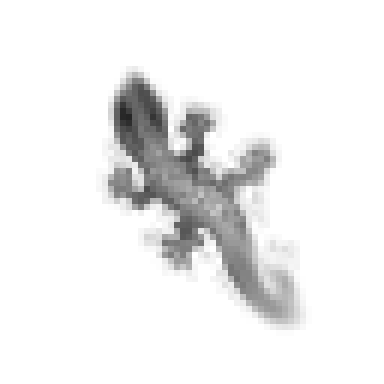

Training Steps Completed: 303
Loss:
0.00603159796
(64, 64, 16)


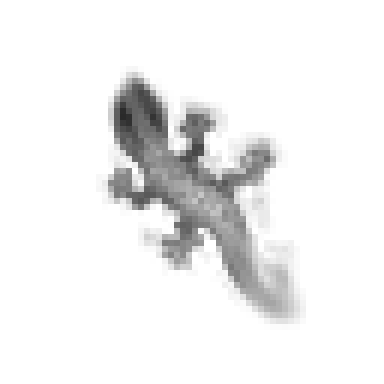

Training Steps Completed: 304
Loss:
0.00505548
(64, 64, 16)


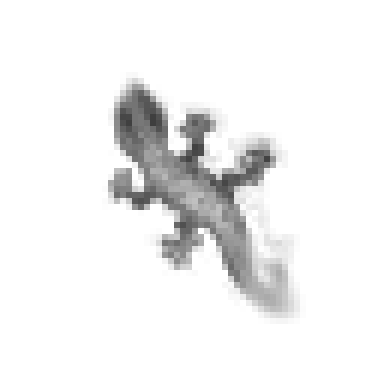

Training Steps Completed: 305
Loss:
0.00544127636
(64, 64, 16)


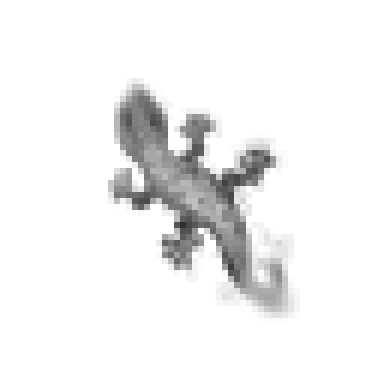

Training Steps Completed: 306
Loss:
0.00527148228
(64, 64, 16)


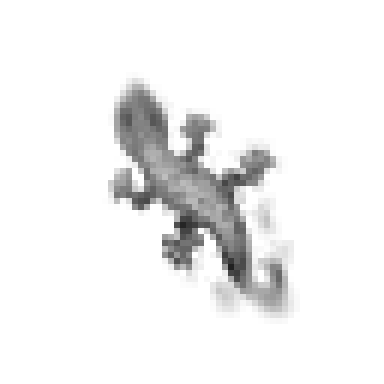

Training Steps Completed: 307
Loss:
0.00420449441
(64, 64, 16)


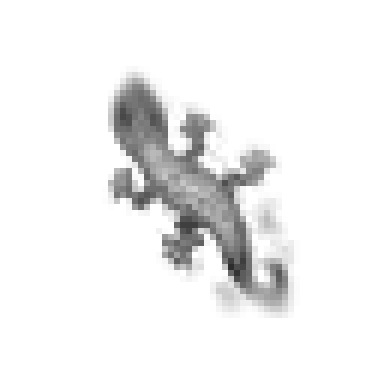

Training Steps Completed: 308
Loss:
0.00459080609
(64, 64, 16)


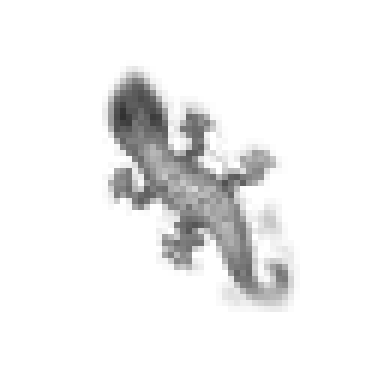

Training Steps Completed: 309
Loss:
0.00381121691
(64, 64, 16)


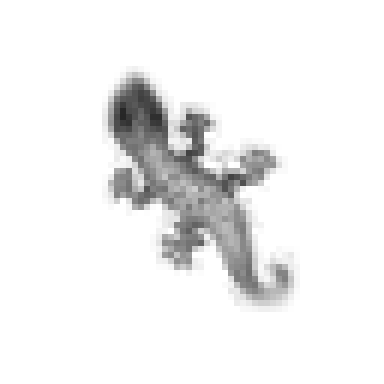

Training Steps Completed: 310
Loss:
0.00284899818
(64, 64, 16)


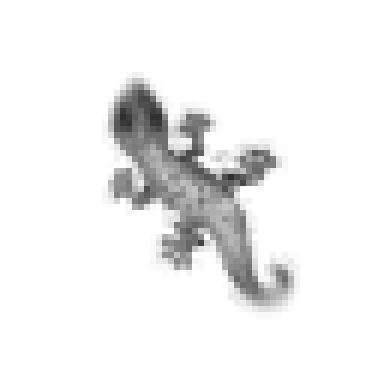

Training Steps Completed: 311
Loss:
0.00292226393
(64, 64, 16)


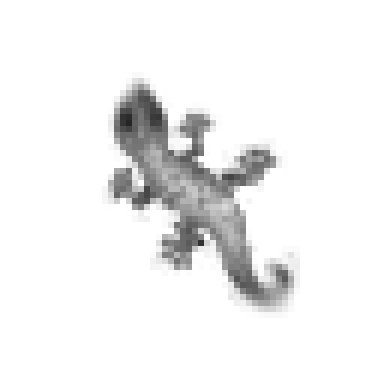

Training Steps Completed: 312
Loss:
0.00330492808
(64, 64, 16)


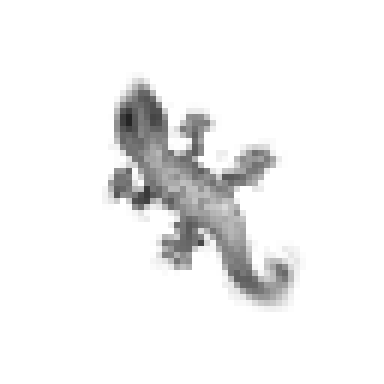

Training Steps Completed: 313
Loss:
0.00289385463
(64, 64, 16)


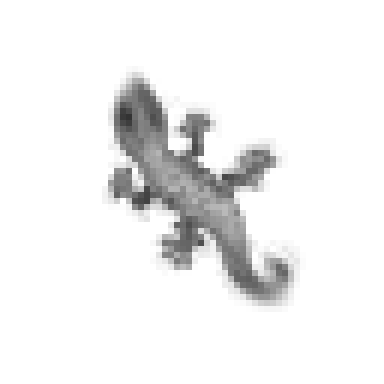

Training Steps Completed: 314
Loss:
0.00289178826
(64, 64, 16)


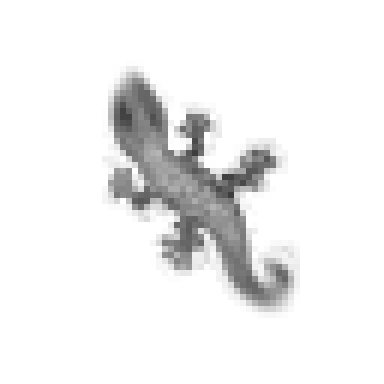

Training Steps Completed: 315
Loss:
0.00286943023
(64, 64, 16)


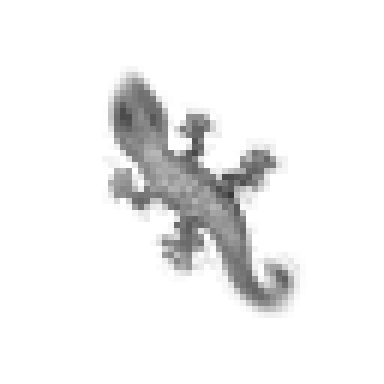

Training Steps Completed: 316
Loss:
0.0024525309
(64, 64, 16)


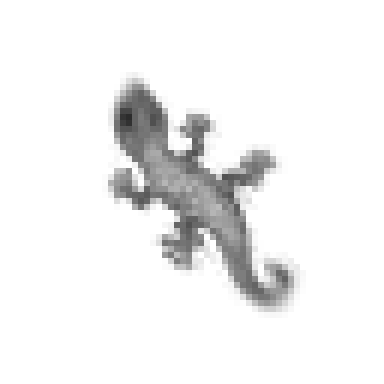

Training Steps Completed: 317
Loss:
0.00242597866
(64, 64, 16)


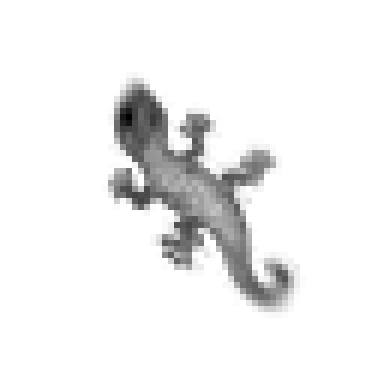

Training Steps Completed: 318
Loss:
0.00203918
(64, 64, 16)


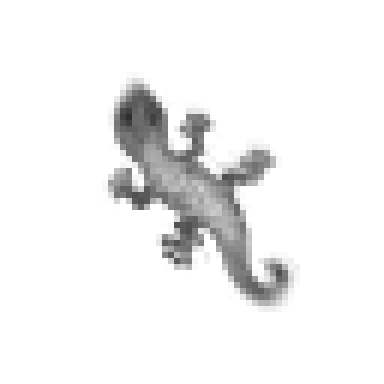

Training Steps Completed: 319
Loss:
0.00213224301
(64, 64, 16)


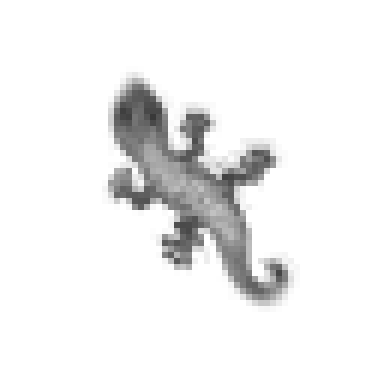

Training Steps Completed: 320
Loss:
0.00237936969
(64, 64, 16)


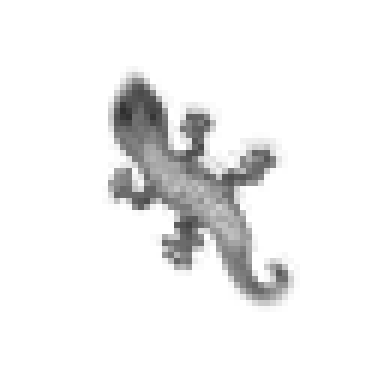

Training Steps Completed: 321
Loss:
0.00196254114
(64, 64, 16)


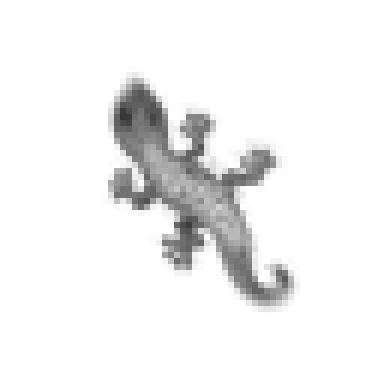

Training Steps Completed: 322
Loss:
0.0028617552
(64, 64, 16)


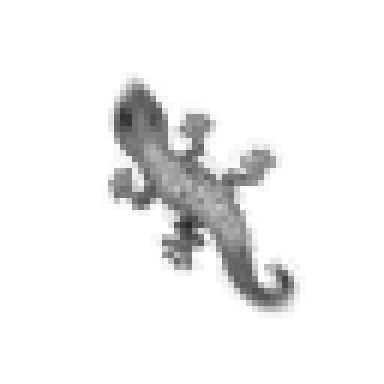

Training Steps Completed: 323
Loss:
0.00212498847
(64, 64, 16)


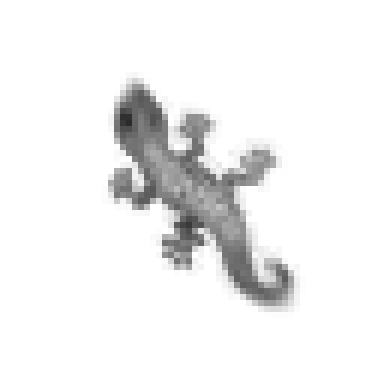

Training Steps Completed: 324
Loss:
0.0031763087
(64, 64, 16)


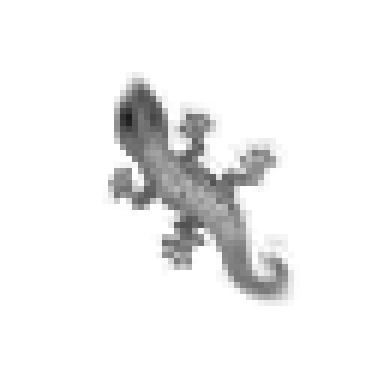

Training Steps Completed: 325
Loss:
0.00331099494
(64, 64, 16)


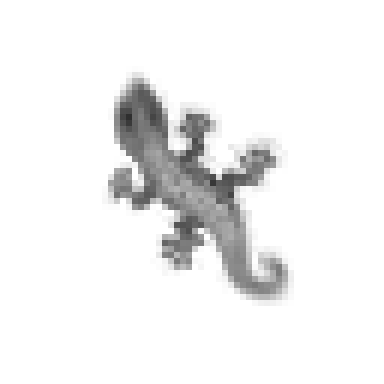

Training Steps Completed: 326
Loss:
0.00248092273
(64, 64, 16)


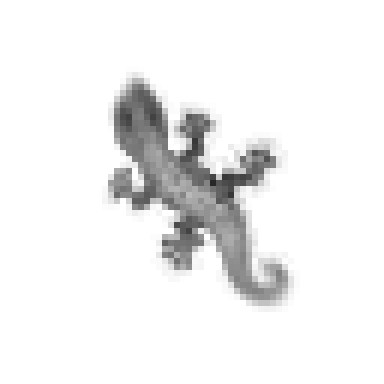

Training Steps Completed: 327
Loss:
0.00258629769
(64, 64, 16)


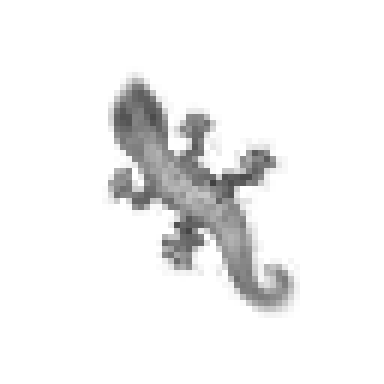

Training Steps Completed: 328
Loss:
0.00348004187
(64, 64, 16)


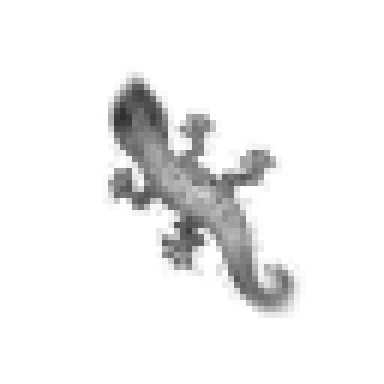

Training Steps Completed: 329
Loss:
0.00291275326
(64, 64, 16)


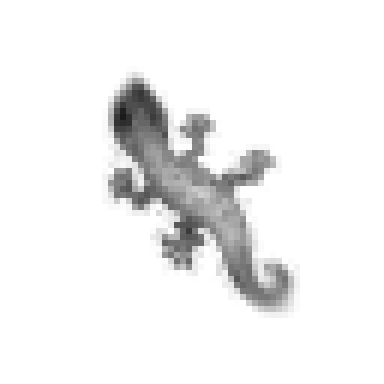

Training Steps Completed: 330
Loss:
0.00176444394
(64, 64, 16)


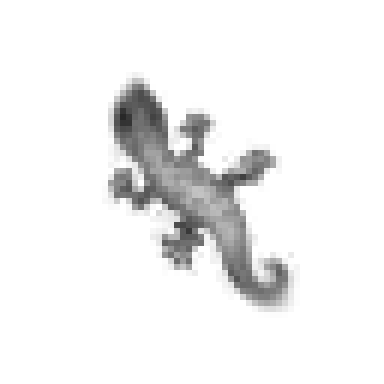

Training Steps Completed: 331
Loss:
0.00274307723
(64, 64, 16)


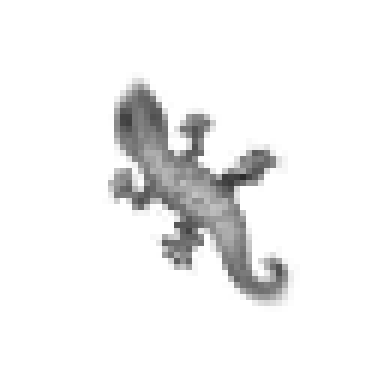

Training Steps Completed: 332
Loss:
0.00337687647
(64, 64, 16)


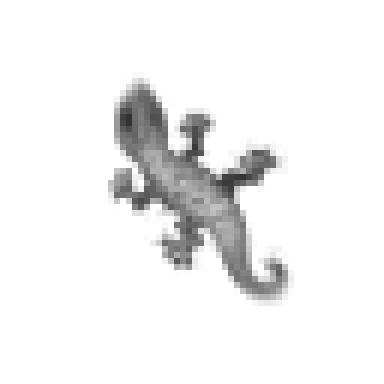

Training Steps Completed: 333
Loss:
0.0022768341
(64, 64, 16)


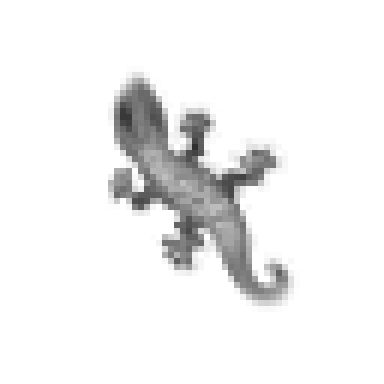

Training Steps Completed: 334
Loss:
0.00357516599
(64, 64, 16)


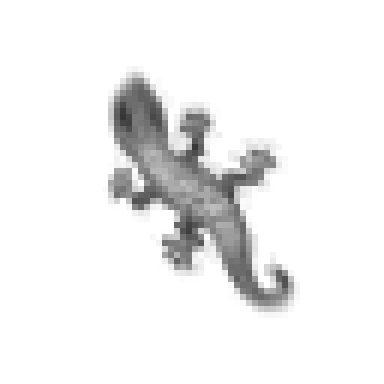

Training Steps Completed: 335
Loss:
0.00443717698
(64, 64, 16)


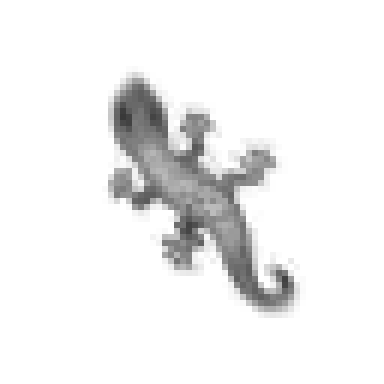

Training Steps Completed: 336
Loss:
0.00344204367
(64, 64, 16)


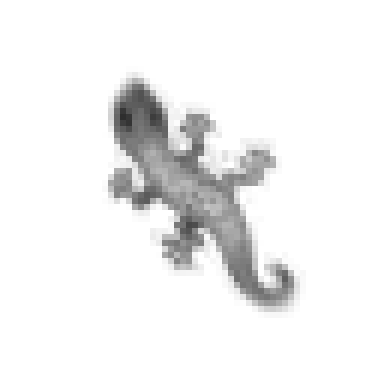

Training Steps Completed: 337
Loss:
0.00289294985
(64, 64, 16)


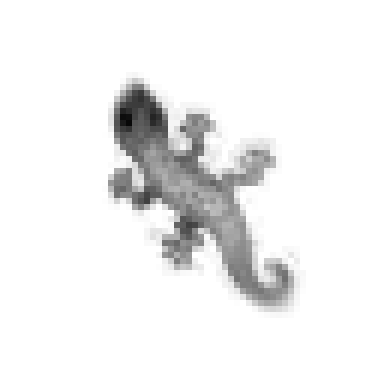

Training Steps Completed: 338
Loss:
0.00290454
(64, 64, 16)


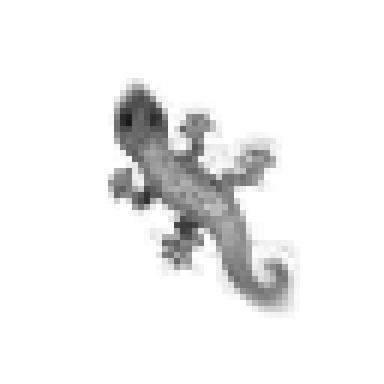

Training Steps Completed: 339
Loss:
0.0041354103
(64, 64, 16)


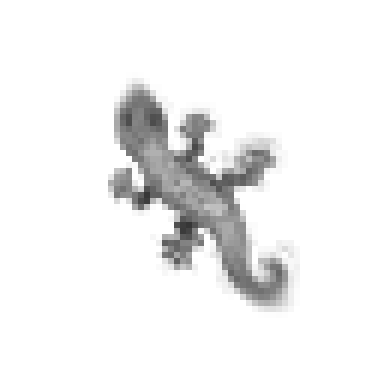

Training Steps Completed: 340
Loss:
0.00455239462
(64, 64, 16)


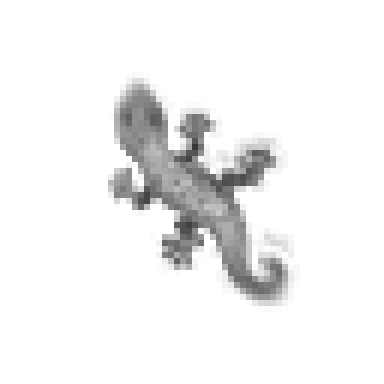

Training Steps Completed: 341
Loss:
0.00374215422
(64, 64, 16)


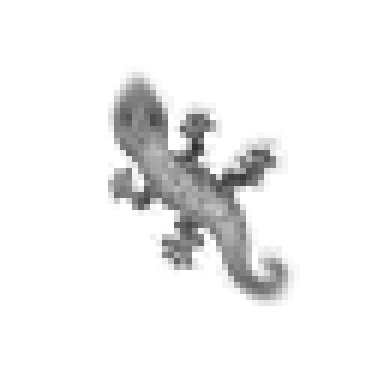

Training Steps Completed: 342
Loss:
0.00353620062
(64, 64, 16)


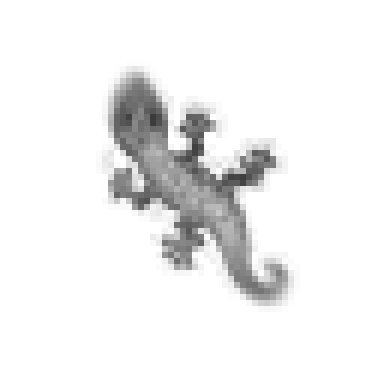

Training Steps Completed: 343
Loss:
0.0032430992
(64, 64, 16)


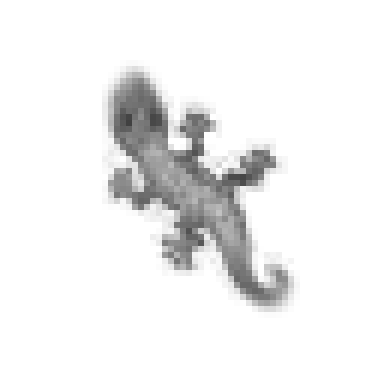

Training Steps Completed: 344
Loss:
0.00390663324
(64, 64, 16)


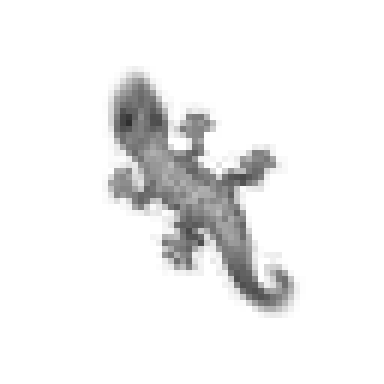

Training Steps Completed: 345
Loss:
0.00337128411
(64, 64, 16)


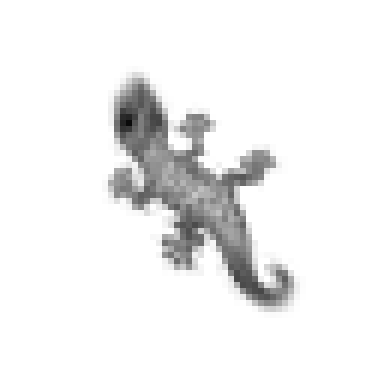

Training Steps Completed: 346
Loss:
0.00248998916
(64, 64, 16)


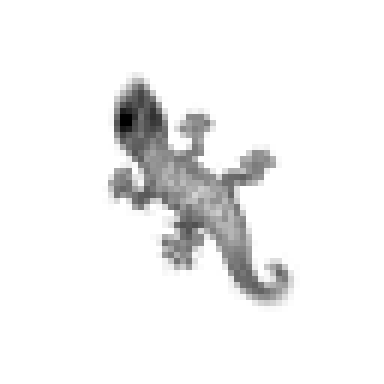

Training Steps Completed: 347
Loss:
0.00236396212
(64, 64, 16)


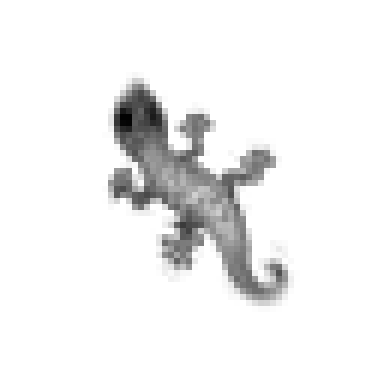

Training Steps Completed: 348
Loss:
0.00257987948
(64, 64, 16)


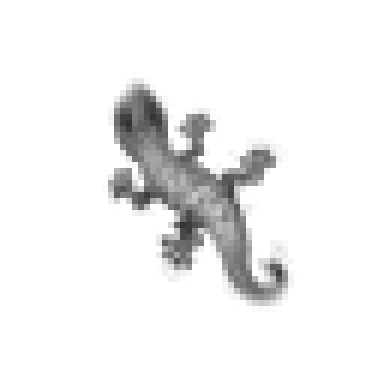

Training Steps Completed: 349
Loss:
0.00184062
(64, 64, 16)


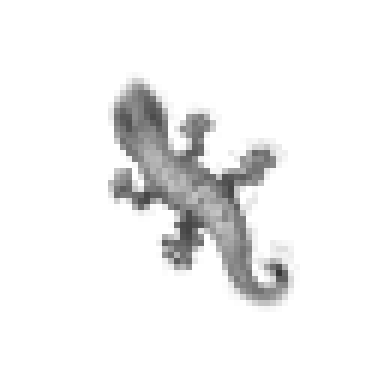

Training Steps Completed: 350
Loss:
0.00251240982
(64, 64, 16)


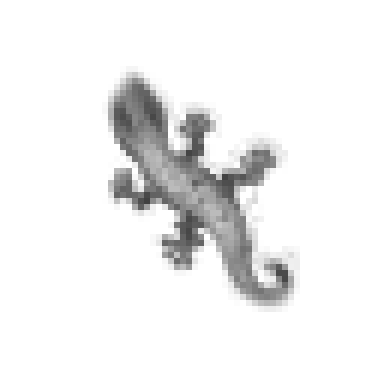

Training Steps Completed: 351
Loss:
0.00278300187
(64, 64, 16)


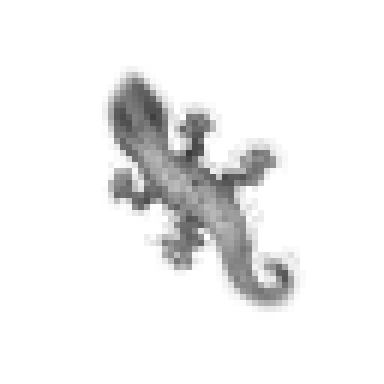

Training Steps Completed: 352
Loss:
0.00278614275
(64, 64, 16)


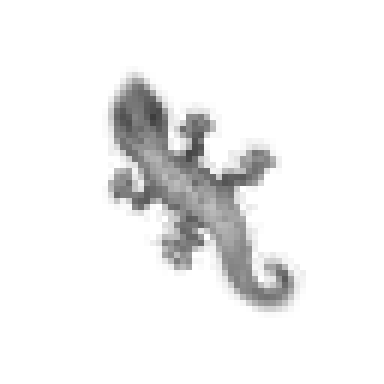

Training Steps Completed: 353
Loss:
0.00236260355
(64, 64, 16)


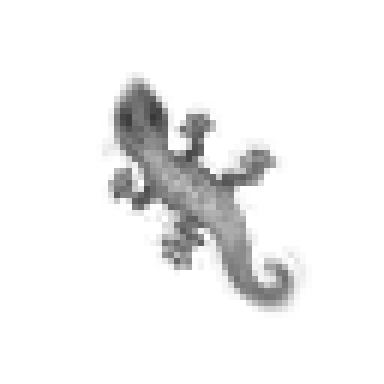

Training Steps Completed: 354
Loss:
0.00272211898
(64, 64, 16)


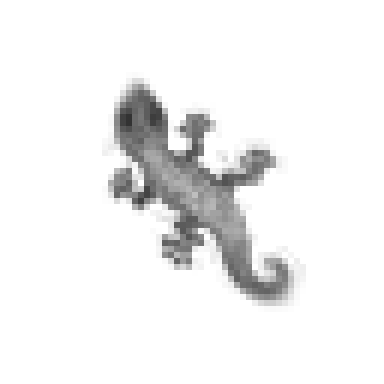

Training Steps Completed: 355
Loss:
0.00298354449
(64, 64, 16)


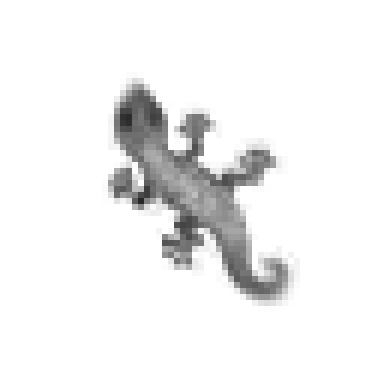

Training Steps Completed: 356
Loss:
0.00238250825
(64, 64, 16)


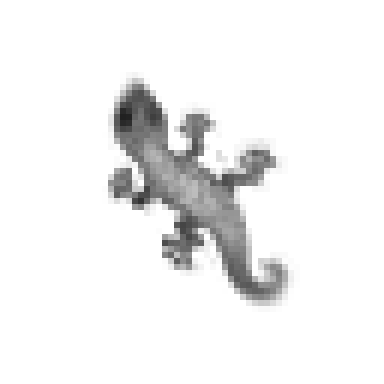

Training Steps Completed: 357
Loss:
0.00203894917
(64, 64, 16)


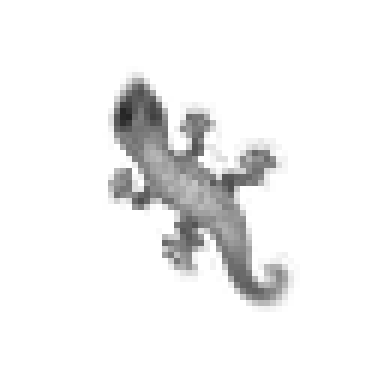

Training Steps Completed: 358
Loss:
0.00242761662
(64, 64, 16)


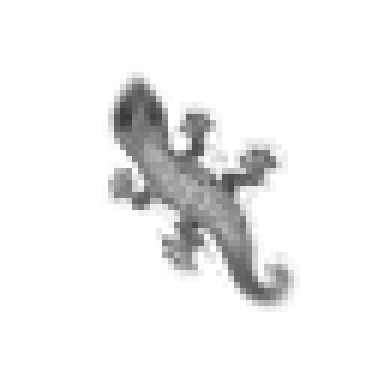

Training Steps Completed: 359
Loss:
0.00256005
(64, 64, 16)


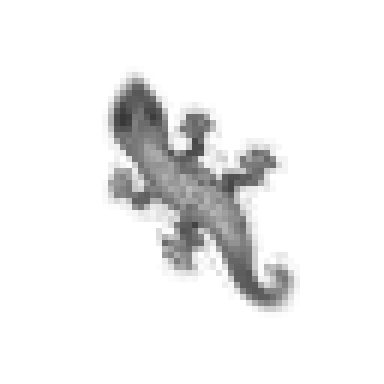

Training Steps Completed: 360
Loss:
0.00180634228
(64, 64, 16)


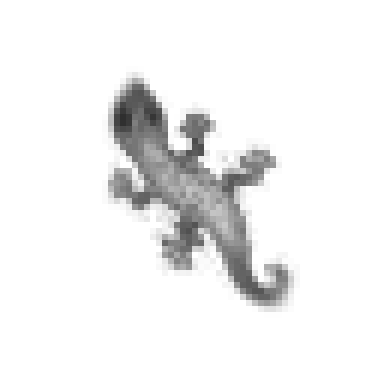

Training Steps Completed: 361
Loss:
0.00220508128
(64, 64, 16)


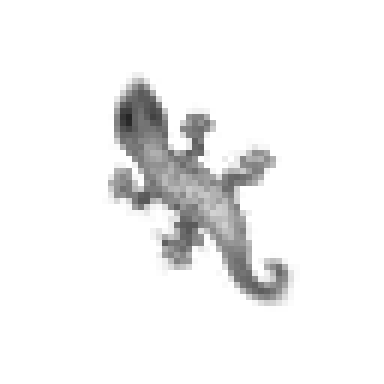

Training Steps Completed: 362
Loss:
0.00199267827
(64, 64, 16)


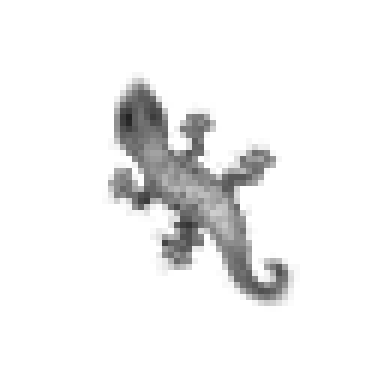

Training Steps Completed: 363
Loss:
0.00145460176
(64, 64, 16)


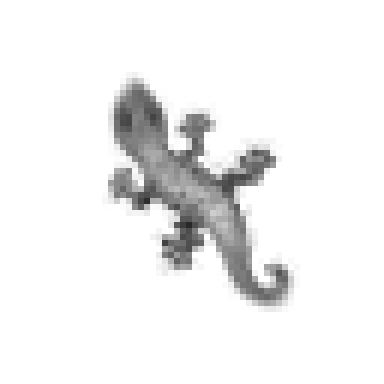

Training Steps Completed: 364
Loss:
0.00148655777
(64, 64, 16)


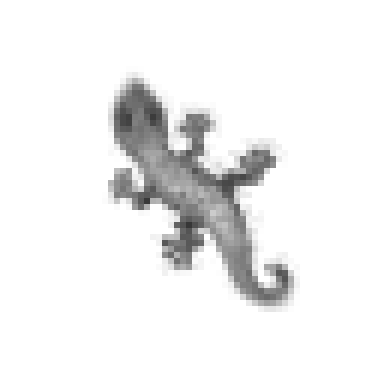

Training Steps Completed: 365
Loss:
0.00173346023
(64, 64, 16)


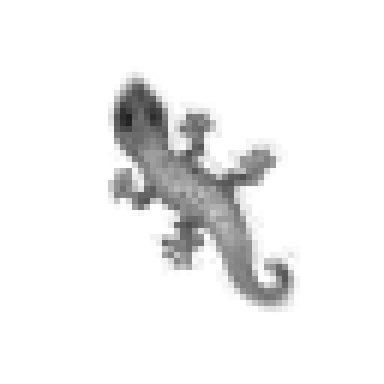

Training Steps Completed: 366
Loss:
0.00164012215
(64, 64, 16)


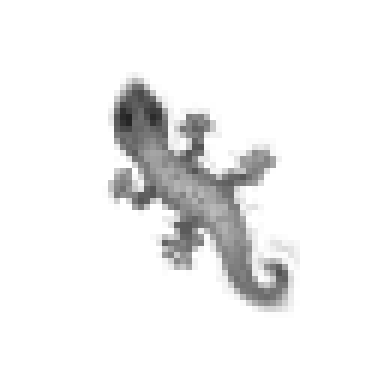

Training Steps Completed: 367
Loss:
0.0020877819
(64, 64, 16)


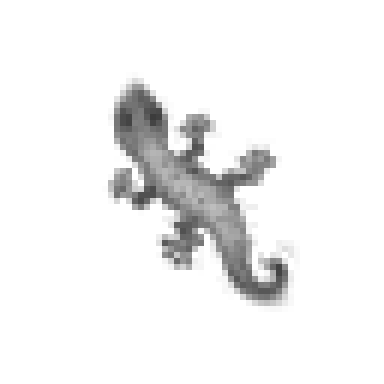

Training Steps Completed: 368
Loss:
0.00255733891
(64, 64, 16)


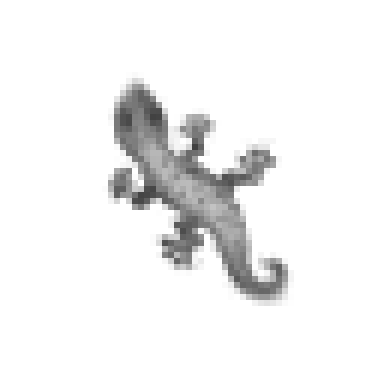

Training Steps Completed: 369
Loss:
0.00210687541
(64, 64, 16)


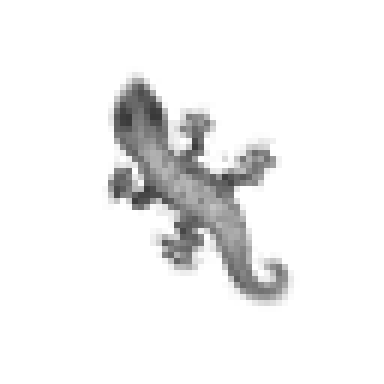

Training Steps Completed: 370
Loss:
0.00247072126
(64, 64, 16)


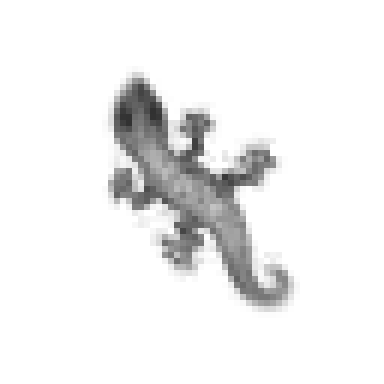

Training Steps Completed: 371
Loss:
0.00345926173
(64, 64, 16)


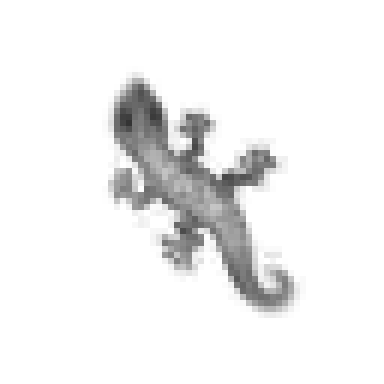

Training Steps Completed: 372
Loss:
0.00338124274
(64, 64, 16)


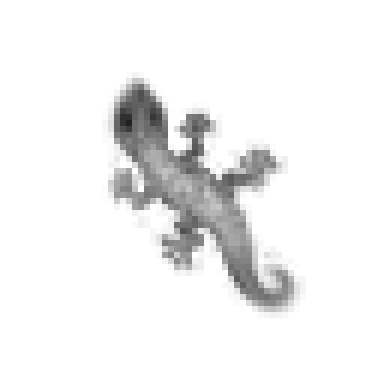

Training Steps Completed: 373
Loss:
0.00224983133
(64, 64, 16)


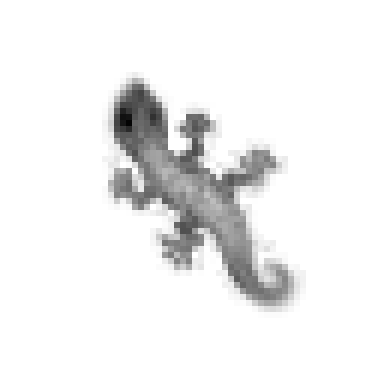

Training Steps Completed: 374
Loss:
0.00159771834
(64, 64, 16)


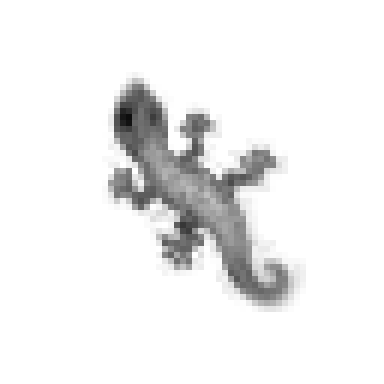

Training Steps Completed: 375
Loss:
0.00306140585
(64, 64, 16)


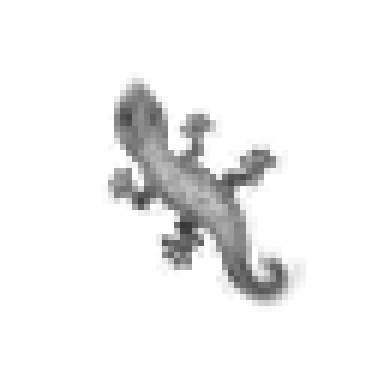

Training Steps Completed: 376
Loss:
0.00492995232
(64, 64, 16)


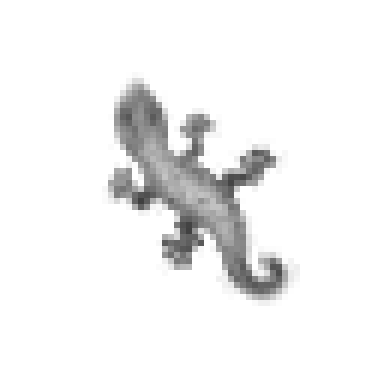

Training Steps Completed: 377
Loss:
0.00454643881
(64, 64, 16)


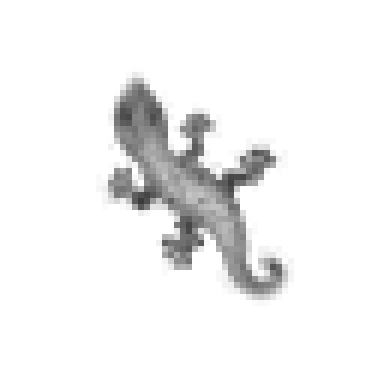

Training Steps Completed: 378
Loss:
0.00427875482
(64, 64, 16)


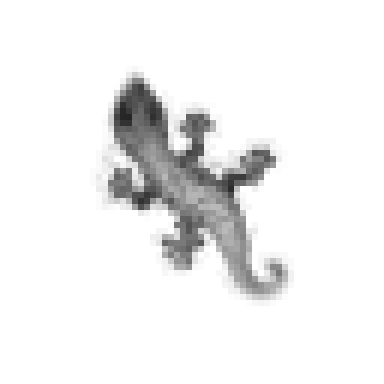

Training Steps Completed: 379
Loss:
0.00424825773
(64, 64, 16)


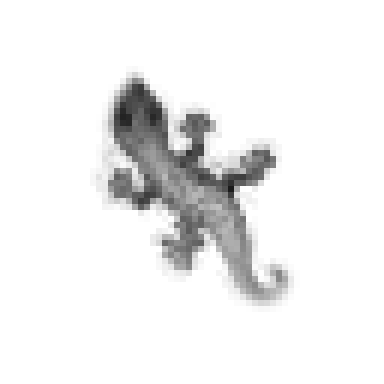

Training Steps Completed: 380
Loss:
0.00437089615
(64, 64, 16)


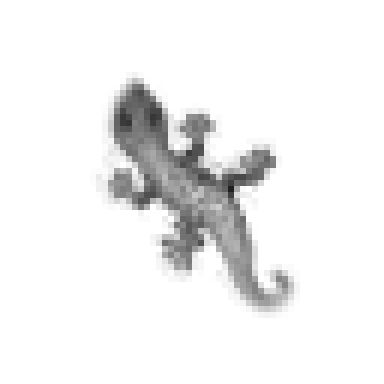

Training Steps Completed: 381
Loss:
0.00587136298
(64, 64, 16)


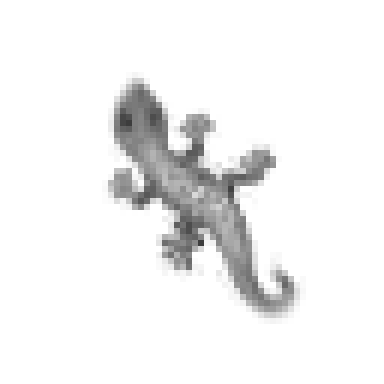

Training Steps Completed: 382
Loss:
0.00596001931
(64, 64, 16)


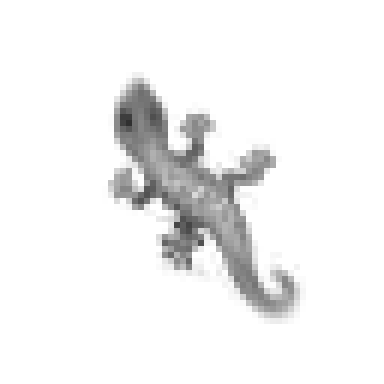

Training Steps Completed: 383
Loss:
0.00511918077
(64, 64, 16)


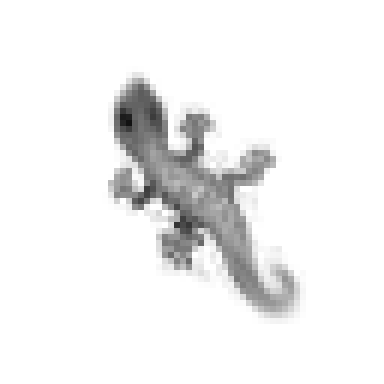

Training Steps Completed: 384
Loss:
0.00521276519
(64, 64, 16)


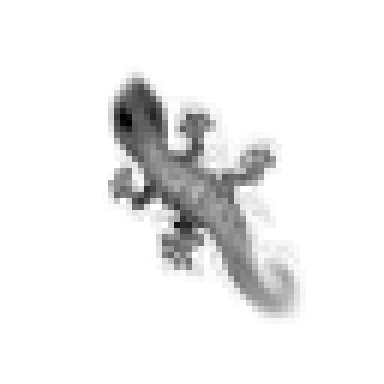

Training Steps Completed: 385
Loss:
0.00465794792
(64, 64, 16)


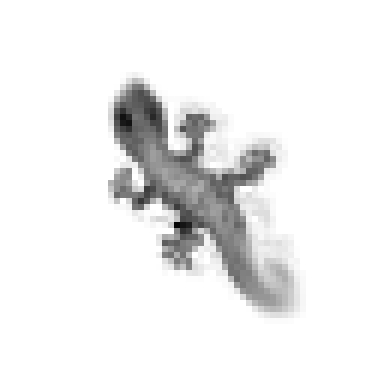

Training Steps Completed: 386
Loss:
0.00440402329
(64, 64, 16)


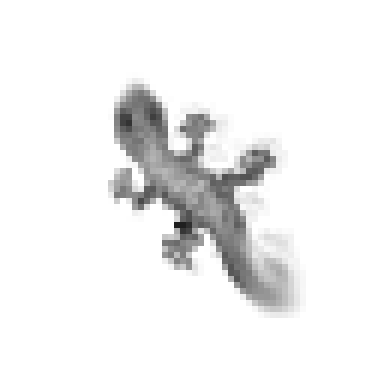

Training Steps Completed: 387
Loss:
0.00449908338
(64, 64, 16)


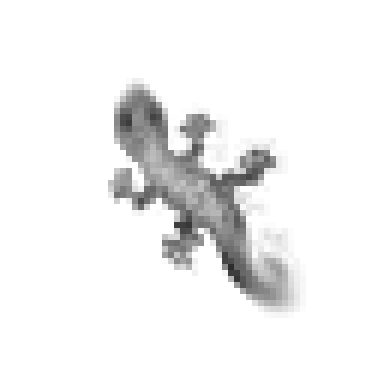

Training Steps Completed: 388
Loss:
0.00361337047
(64, 64, 16)


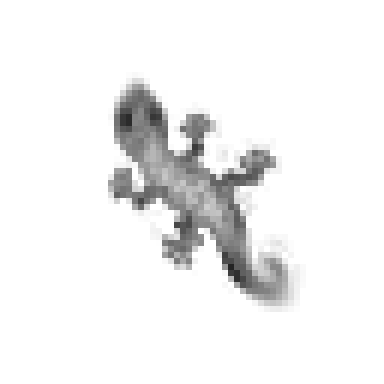

Training Steps Completed: 389
Loss:
0.00370188477
(64, 64, 16)


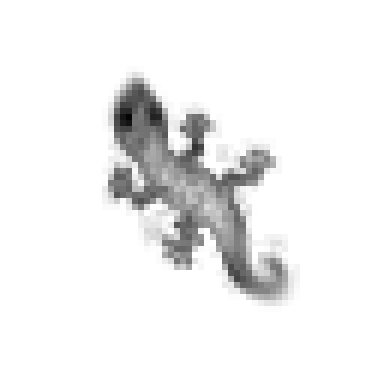

Training Steps Completed: 390
Loss:
0.00381968822
(64, 64, 16)


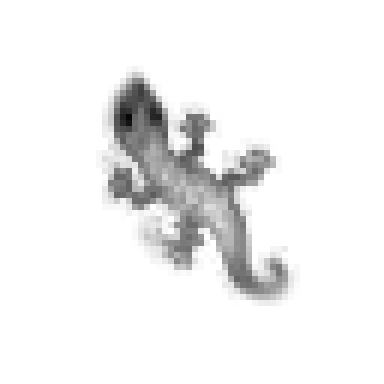

Training Steps Completed: 391
Loss:
0.00270401081
(64, 64, 16)


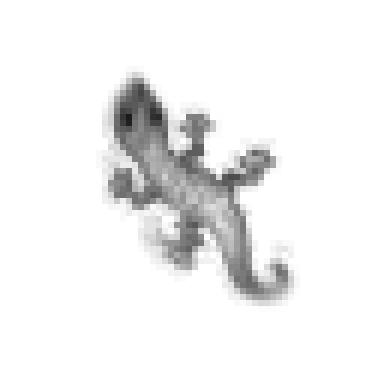

Training Steps Completed: 392
Loss:
0.00315132225
(64, 64, 16)


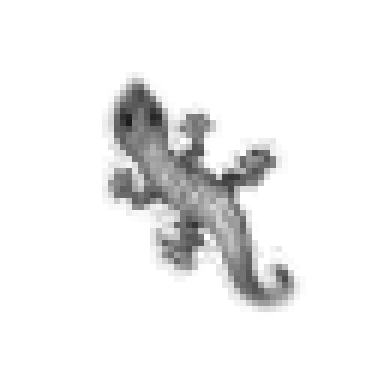

Training Steps Completed: 393
Loss:
0.00343402615
(64, 64, 16)


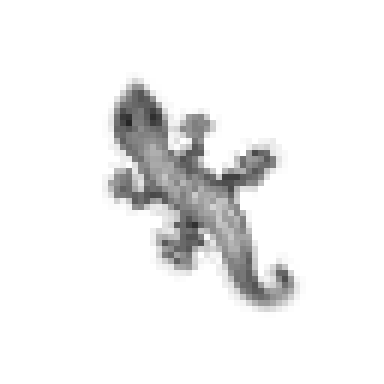

Training Steps Completed: 394
Loss:
0.0025912039
(64, 64, 16)


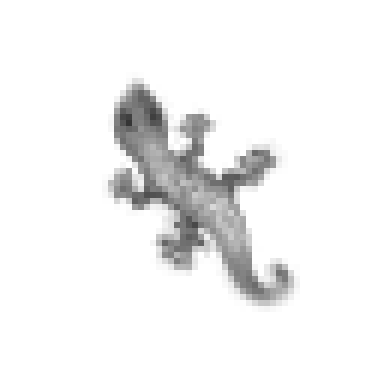

Training Steps Completed: 395
Loss:
0.00208771811
(64, 64, 16)


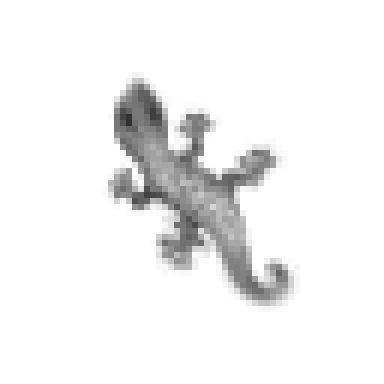

Training Steps Completed: 396
Loss:
0.00255060615
(64, 64, 16)


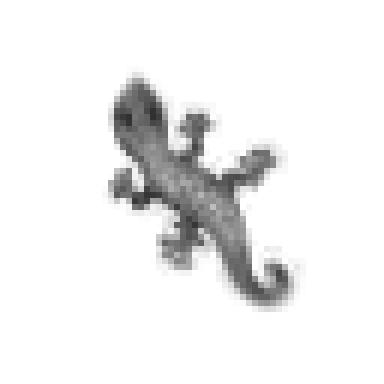

Training Steps Completed: 397
Loss:
0.00239230949
(64, 64, 16)


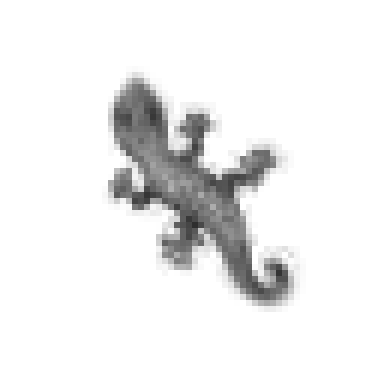

Training Steps Completed: 398
Loss:
0.00303340657
(64, 64, 16)


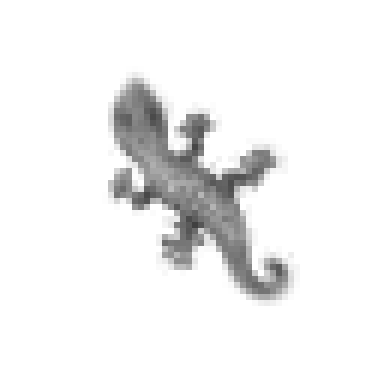

Training Steps Completed: 399
Loss:
0.00246859784
(64, 64, 16)


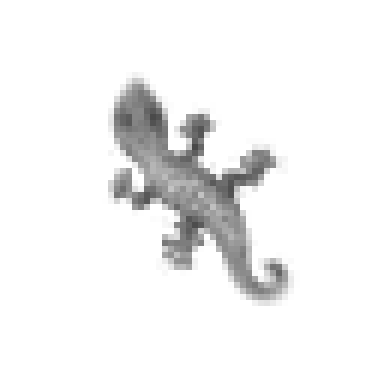

Training Steps Completed: 400
Loss:
0.00288268179
(64, 64, 16)


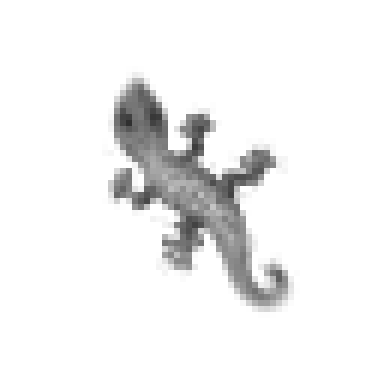

Training Steps Completed: 401
Loss:
0.00341148837
(64, 64, 16)


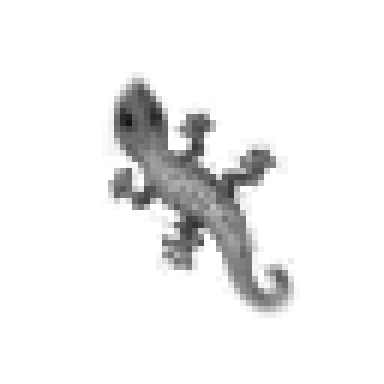

Training Steps Completed: 402
Loss:
0.00209565787
(64, 64, 16)


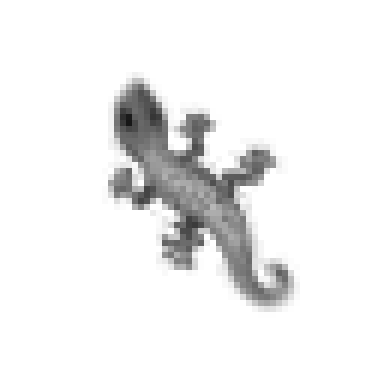

Training Steps Completed: 403
Loss:
0.00179509469
(64, 64, 16)


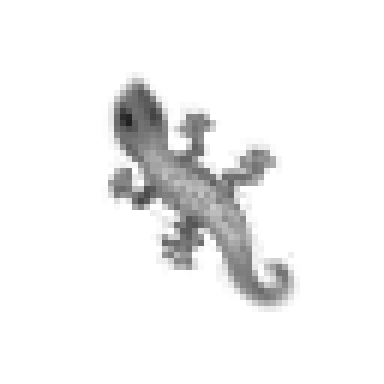

Training Steps Completed: 404
Loss:
0.00215685321
(64, 64, 16)


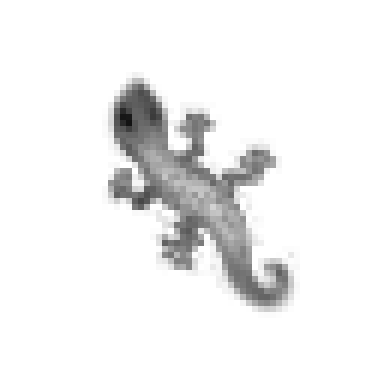

Training Steps Completed: 405
Loss:
0.00205806619
(64, 64, 16)


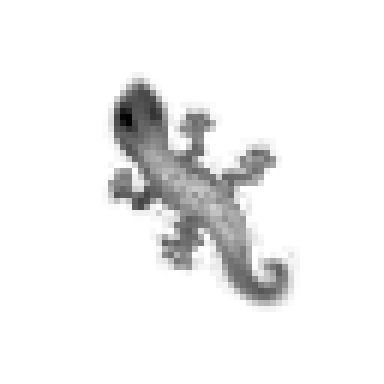

Training Steps Completed: 406
Loss:
0.00375318853
(64, 64, 16)


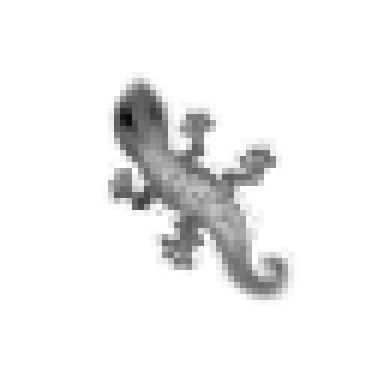

Training Steps Completed: 407
Loss:
0.00377626368
(64, 64, 16)


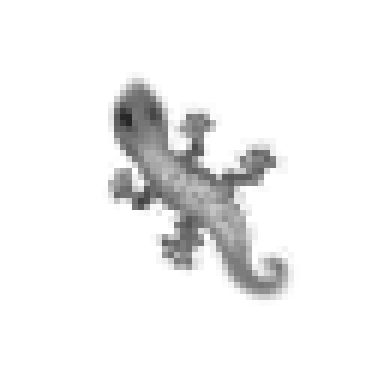

Training Steps Completed: 408
Loss:
0.00172280811
(64, 64, 16)


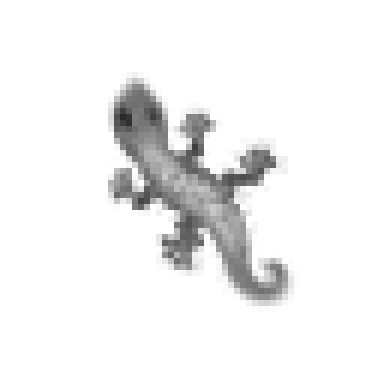

Training Steps Completed: 409
Loss:
0.00324402377
(64, 64, 16)


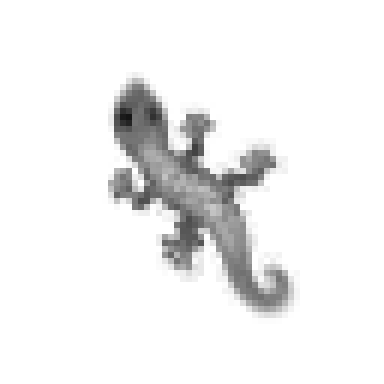

Training Steps Completed: 410
Loss:
0.00387768145
(64, 64, 16)


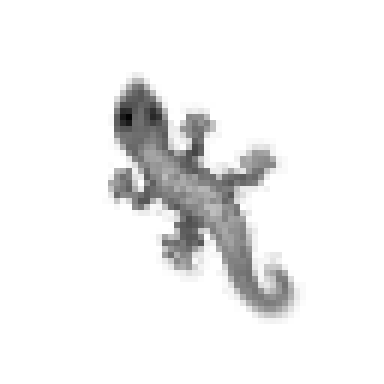

Training Steps Completed: 411
Loss:
0.00314356945
(64, 64, 16)


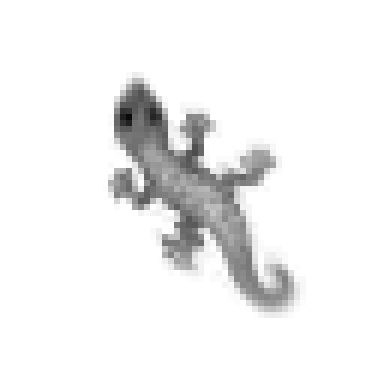

Training Steps Completed: 412
Loss:
0.00237199431
(64, 64, 16)


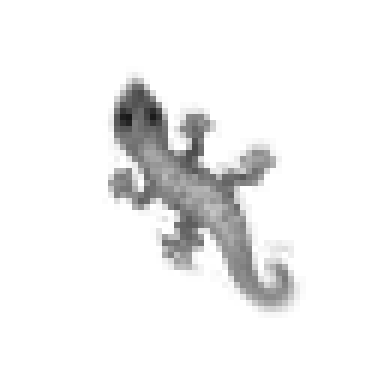

Training Steps Completed: 413
Loss:
0.00206676498
(64, 64, 16)


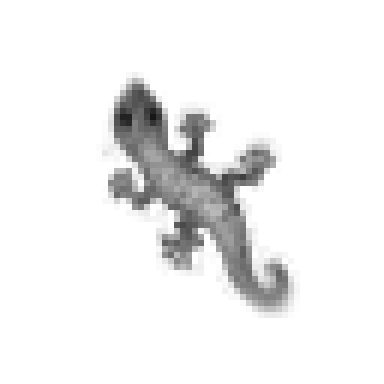

Training Steps Completed: 414
Loss:
0.00192622421
(64, 64, 16)


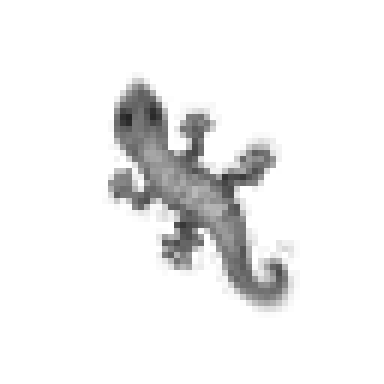

Training Steps Completed: 415
Loss:
0.00324108475
(64, 64, 16)


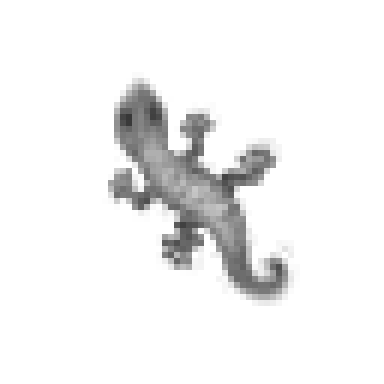

Training Steps Completed: 416
Loss:
0.00364515185
(64, 64, 16)


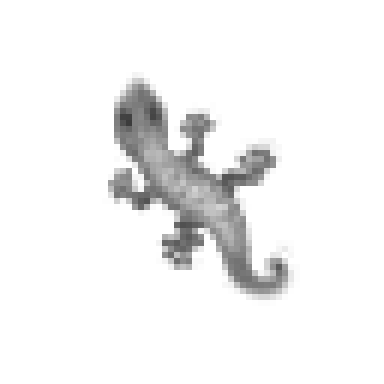

Training Steps Completed: 417
Loss:
0.00282086455
(64, 64, 16)


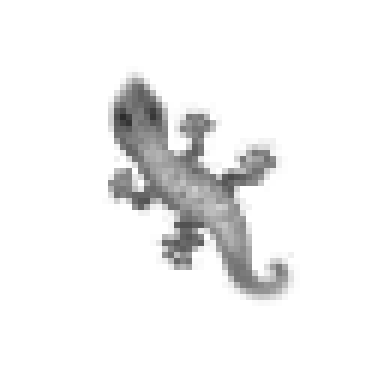

Training Steps Completed: 418
Loss:
0.0024074954
(64, 64, 16)


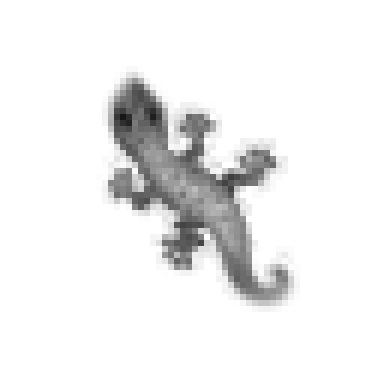

Training Steps Completed: 419
Loss:
0.00333181536
(64, 64, 16)


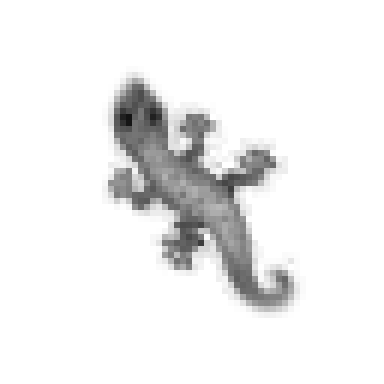

Training Steps Completed: 420
Loss:
0.00372878741
(64, 64, 16)


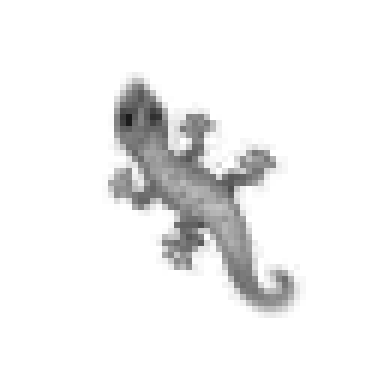

Training Steps Completed: 421
Loss:
0.00278223492
(64, 64, 16)


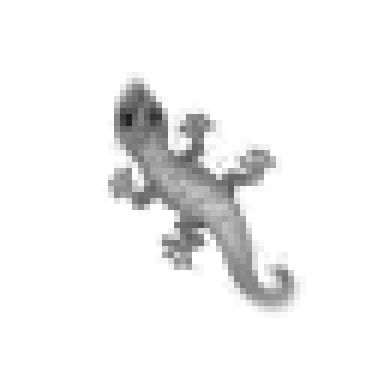

Training Steps Completed: 422
Loss:
0.00195958
(64, 64, 16)


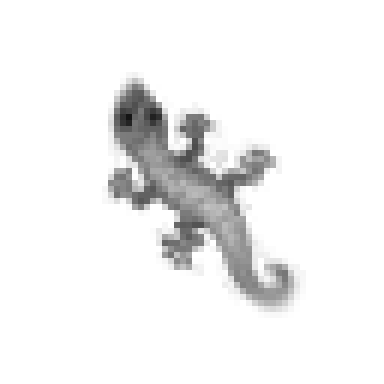

Training Steps Completed: 423
Loss:
0.00188186811
(64, 64, 16)


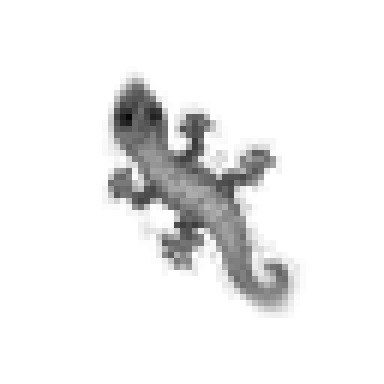

Training Steps Completed: 424
Loss:
0.00232145982
(64, 64, 16)


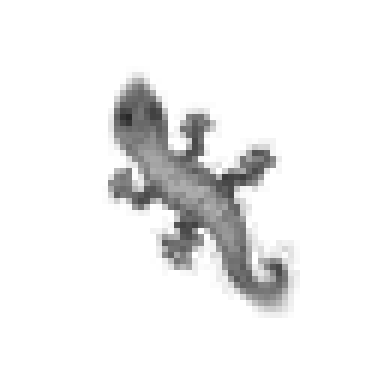

Training Steps Completed: 425
Loss:
0.00294542313
(64, 64, 16)


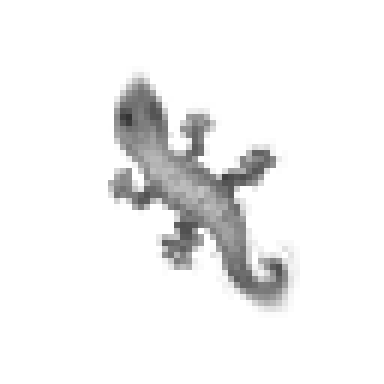

Training Steps Completed: 426
Loss:
0.00253155595
(64, 64, 16)


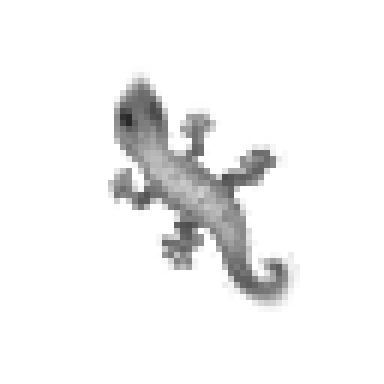

Training Steps Completed: 427
Loss:
0.00153057929
(64, 64, 16)


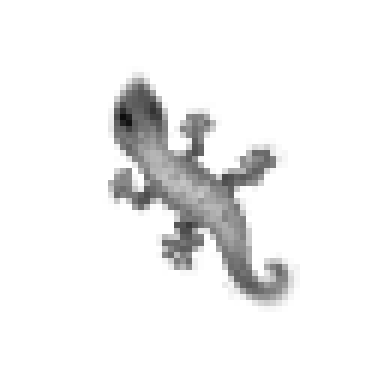

Training Steps Completed: 428
Loss:
0.00189474132
(64, 64, 16)


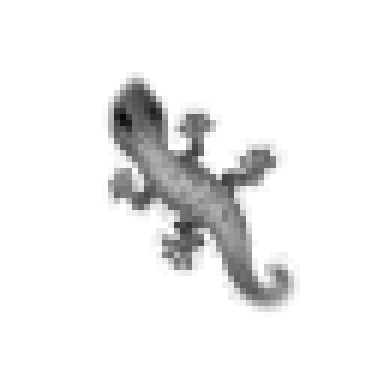

Training Steps Completed: 429
Loss:
0.00280000805
(64, 64, 16)


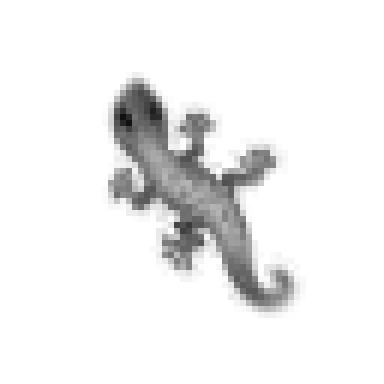

Training Steps Completed: 430
Loss:
0.00294139609
(64, 64, 16)


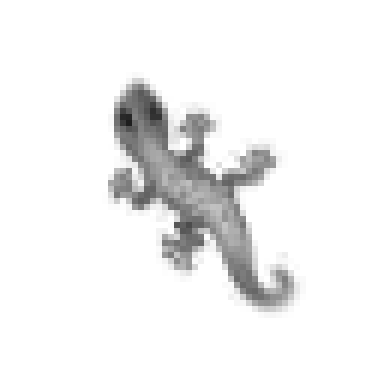

Training Steps Completed: 431
Loss:
0.0020112237
(64, 64, 16)


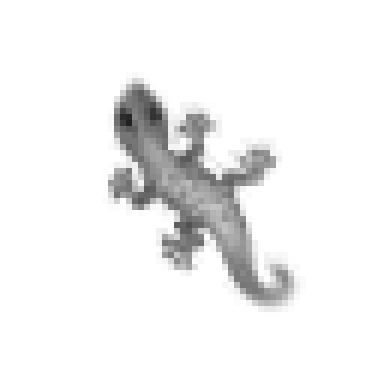

Training Steps Completed: 432
Loss:
0.0013331275
(64, 64, 16)


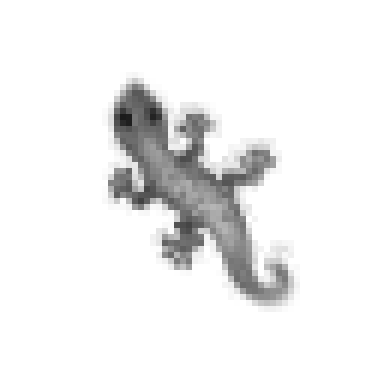

Training Steps Completed: 433
Loss:
0.001307945
(64, 64, 16)


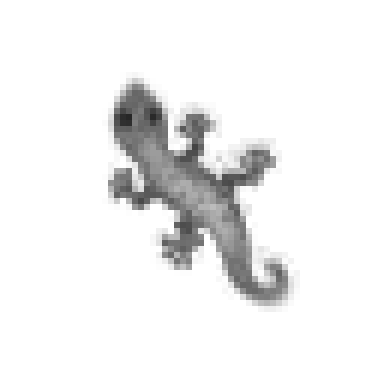

Training Steps Completed: 434
Loss:
0.00166709302
(64, 64, 16)


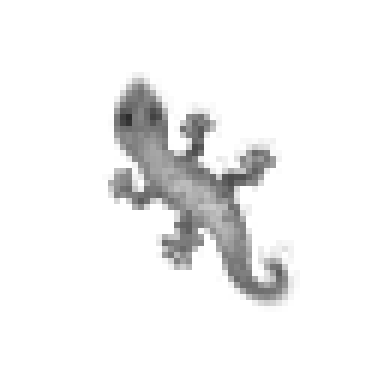

Training Steps Completed: 435
Loss:
0.0020411
(64, 64, 16)


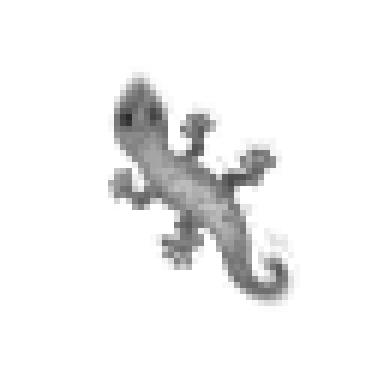

Training Steps Completed: 436
Loss:
0.00139395392
(64, 64, 16)


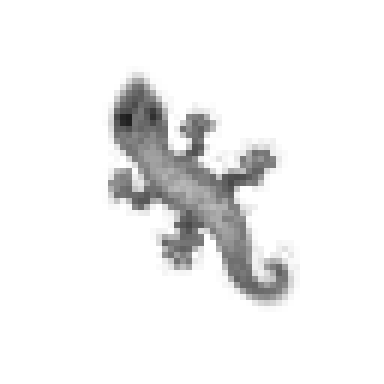

Training Steps Completed: 437
Loss:
0.00163599686
(64, 64, 16)


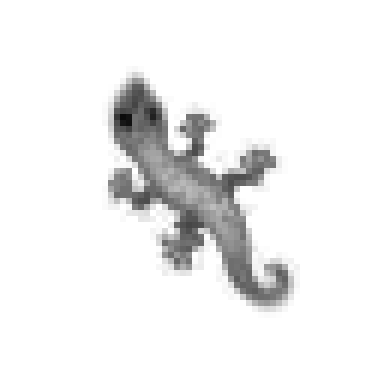

Training Steps Completed: 438
Loss:
0.00148335495
(64, 64, 16)


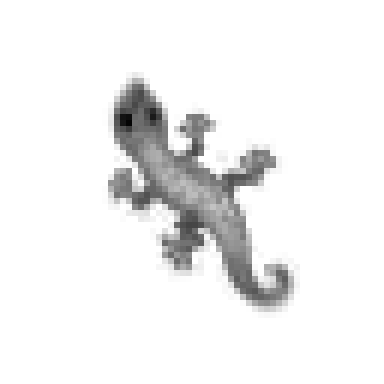

Training Steps Completed: 439
Loss:
0.00144913478
(64, 64, 16)


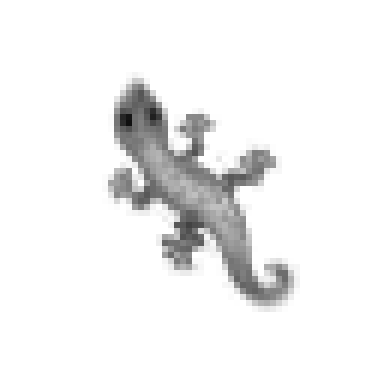

Training Steps Completed: 440
Loss:
0.00140598428
(64, 64, 16)


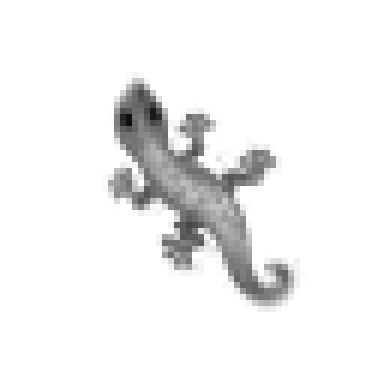

Training Steps Completed: 441
Loss:
0.00119769189
(64, 64, 16)


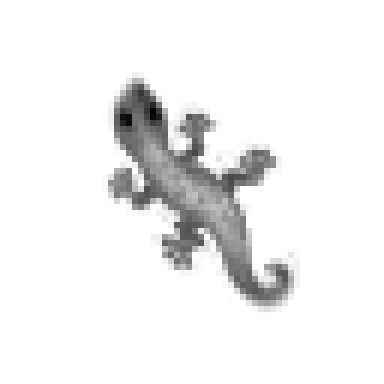

Training Steps Completed: 442
Loss:
0.00117933599
(64, 64, 16)


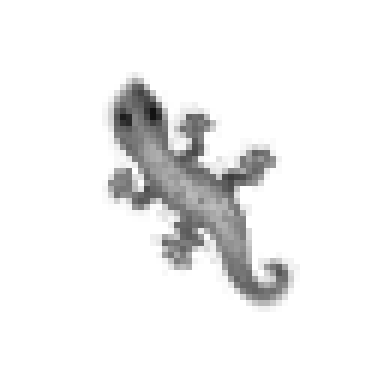

Training Steps Completed: 443
Loss:
0.00180096494
(64, 64, 16)


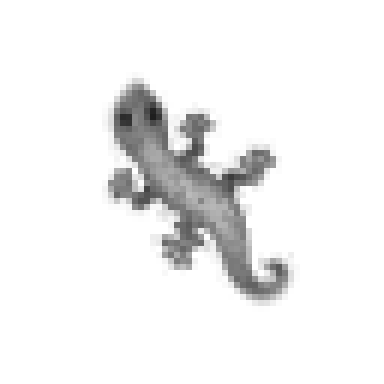

Training Steps Completed: 444
Loss:
0.0015124667
(64, 64, 16)


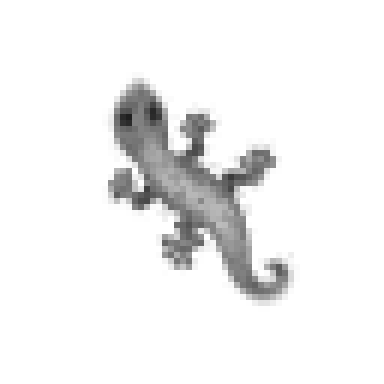

Training Steps Completed: 445
Loss:
0.00112536026
(64, 64, 16)


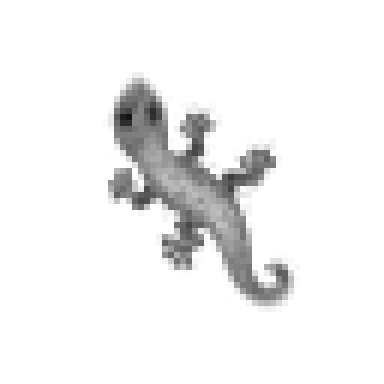

Training Steps Completed: 446
Loss:
0.00139805884
(64, 64, 16)


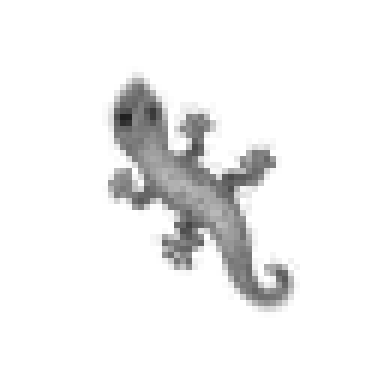

Training Steps Completed: 447
Loss:
0.00159405661
(64, 64, 16)


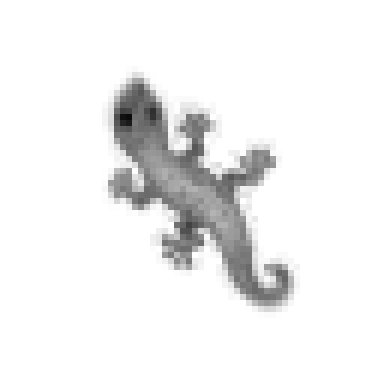

Training Steps Completed: 448
Loss:
0.00177253282
(64, 64, 16)


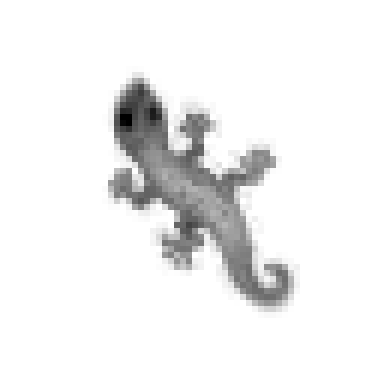

Training Steps Completed: 449
Loss:
0.00149076234
(64, 64, 16)


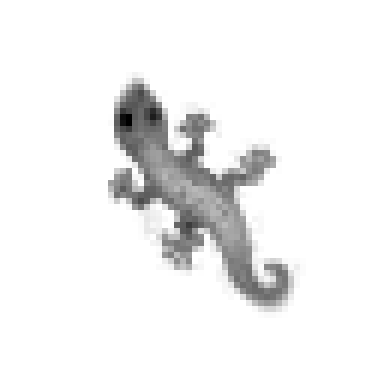

Training Steps Completed: 450
Loss:
0.00174817315
(64, 64, 16)


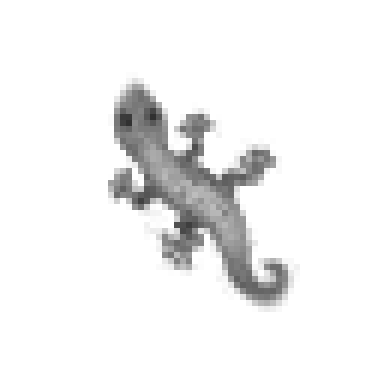

Training Steps Completed: 451
Loss:
0.00274162414
(64, 64, 16)


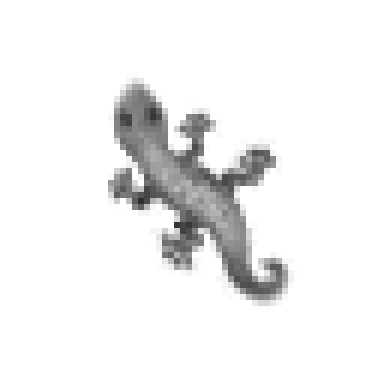

Training Steps Completed: 452
Loss:
0.00286249537
(64, 64, 16)


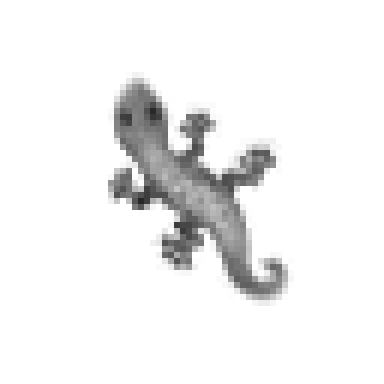

Training Steps Completed: 453
Loss:
0.0027620655
(64, 64, 16)


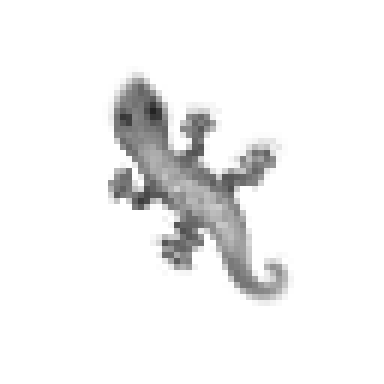

Training Steps Completed: 454
Loss:
0.00212998805
(64, 64, 16)


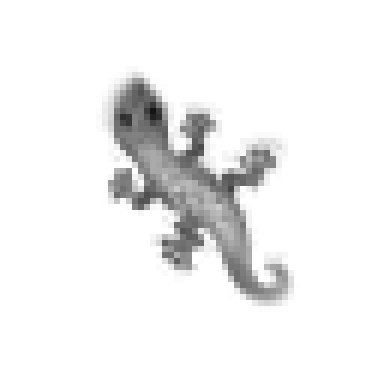

Training Steps Completed: 455
Loss:
0.00283530774
(64, 64, 16)


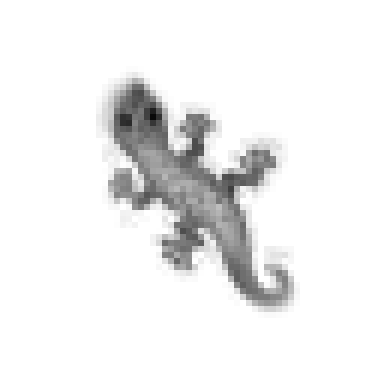

Training Steps Completed: 456
Loss:
0.00372772594
(64, 64, 16)


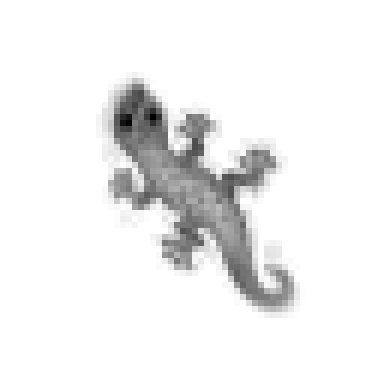

Training Steps Completed: 457
Loss:
0.00316756638
(64, 64, 16)


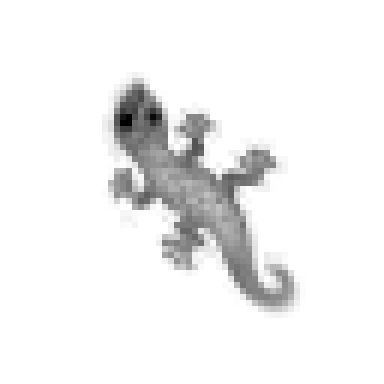

Training Steps Completed: 458
Loss:
0.00229619537
(64, 64, 16)


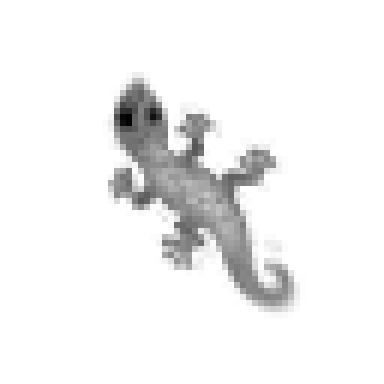

Training Steps Completed: 459
Loss:
0.00161965867
(64, 64, 16)


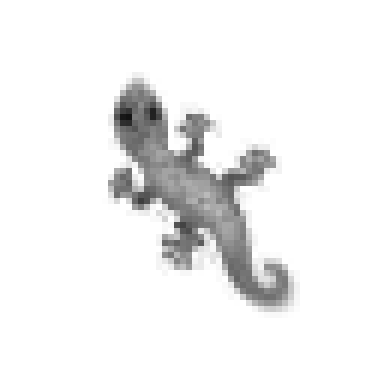

Training Steps Completed: 460
Loss:
0.00152823224
(64, 64, 16)


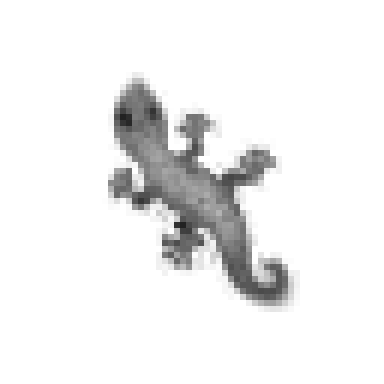

Training Steps Completed: 461
Loss:
0.00317219622
(64, 64, 16)


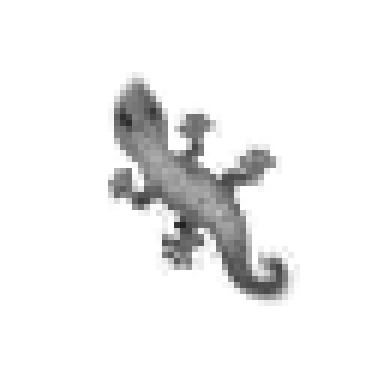

Training Steps Completed: 462
Loss:
0.00521258637
(64, 64, 16)


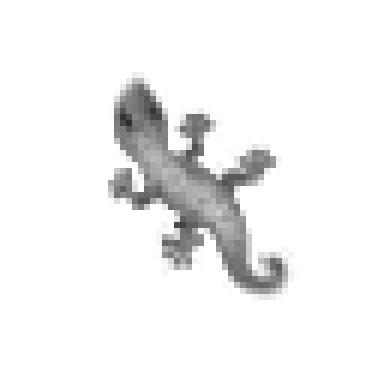

Training Steps Completed: 463
Loss:
0.00622587185
(64, 64, 16)


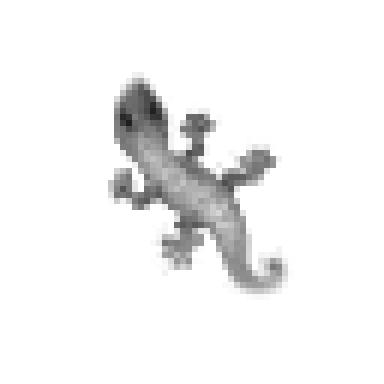

Training Steps Completed: 464
Loss:
0.00661302637
(64, 64, 16)


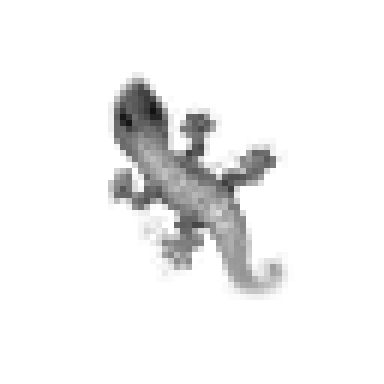

Training Steps Completed: 465
Loss:
0.0055213403
(64, 64, 16)


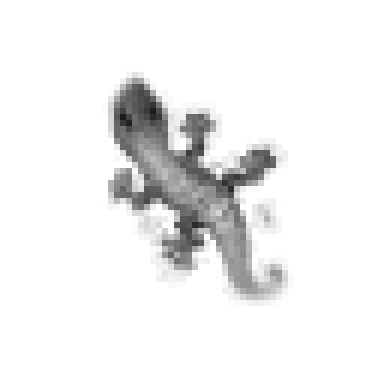

Training Steps Completed: 466
Loss:
0.00440813322
(64, 64, 16)


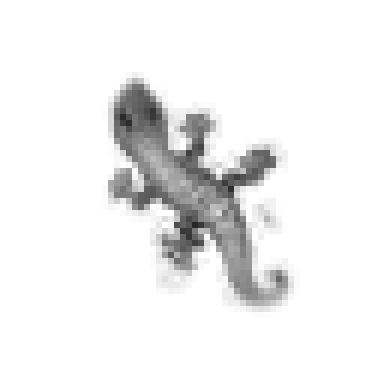

Training Steps Completed: 467
Loss:
0.00488303415
(64, 64, 16)


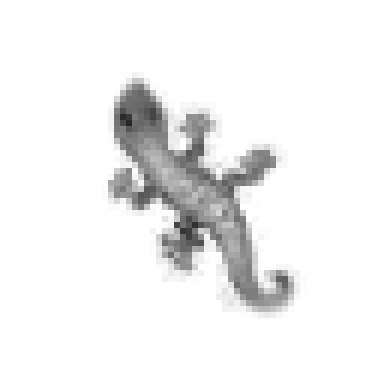

Training Steps Completed: 468
Loss:
0.00504780281
(64, 64, 16)


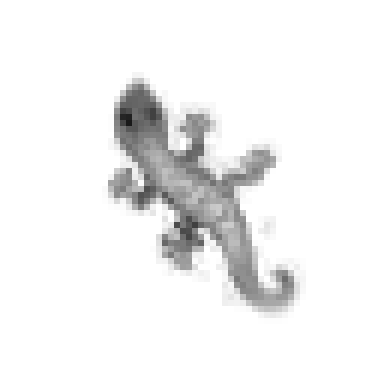

Training Steps Completed: 469
Loss:
0.00466281269
(64, 64, 16)


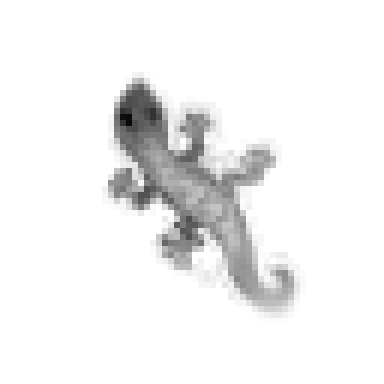

Training Steps Completed: 470
Loss:
0.004556756
(64, 64, 16)


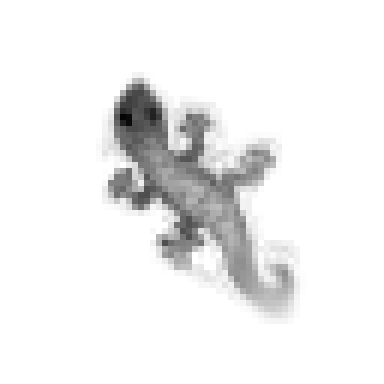

Training Steps Completed: 471
Loss:
0.00394521747
(64, 64, 16)


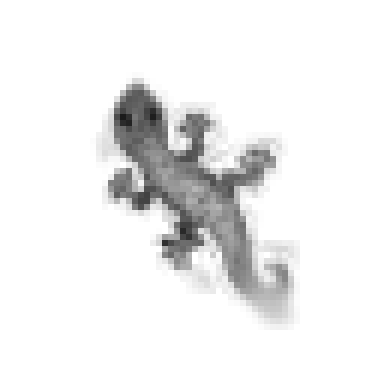

Training Steps Completed: 472
Loss:
0.00387466932
(64, 64, 16)


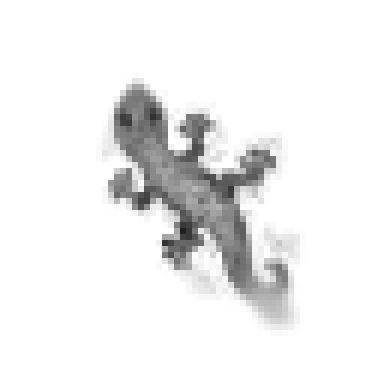

Training Steps Completed: 473
Loss:
0.00393482856
(64, 64, 16)


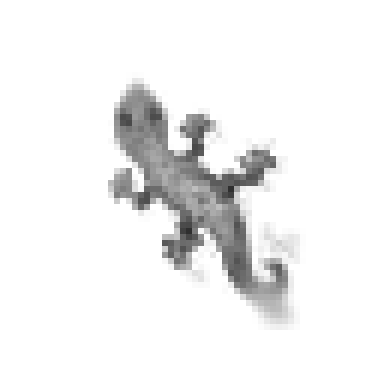

Training Steps Completed: 474
Loss:
0.00415713945
(64, 64, 16)


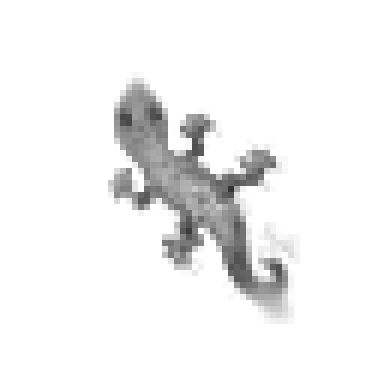

Training Steps Completed: 475
Loss:
0.00336965593
(64, 64, 16)


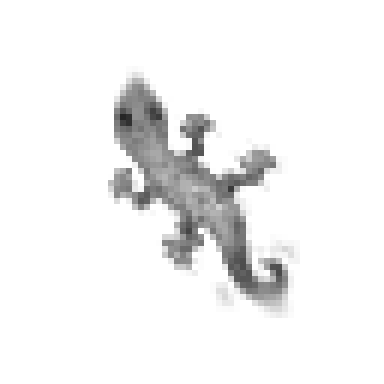

Training Steps Completed: 476
Loss:
0.00271905377
(64, 64, 16)


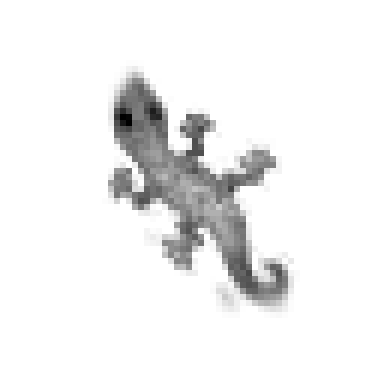

Training Steps Completed: 477
Loss:
0.00303747877
(64, 64, 16)


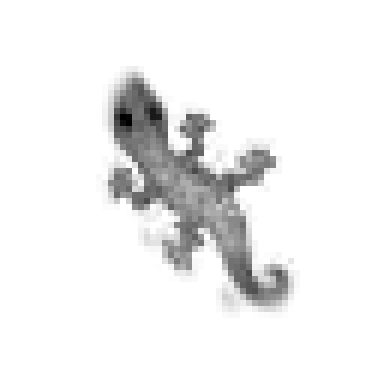

Training Steps Completed: 478
Loss:
0.00296537764
(64, 64, 16)


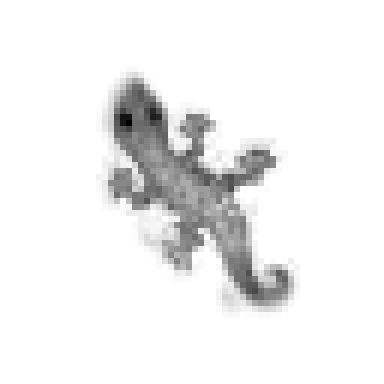

Training Steps Completed: 479
Loss:
0.00260920031
(64, 64, 16)


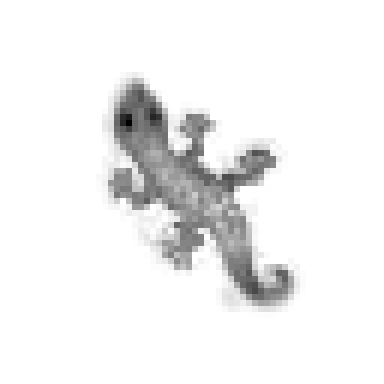

Training Steps Completed: 480
Loss:
0.00181407901
(64, 64, 16)


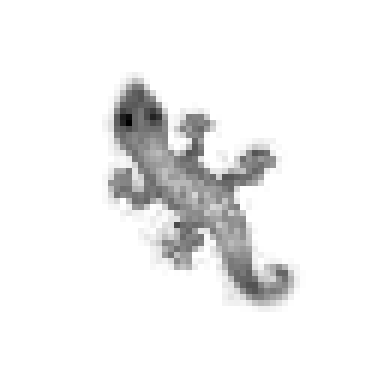

Training Steps Completed: 481
Loss:
0.0017303247
(64, 64, 16)


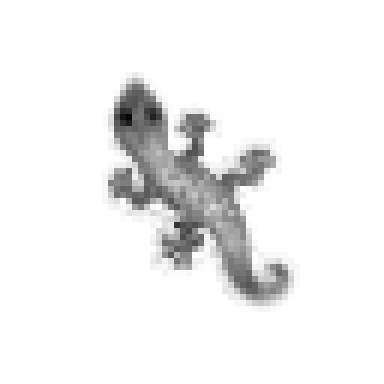

Training Steps Completed: 482
Loss:
0.00201939745
(64, 64, 16)


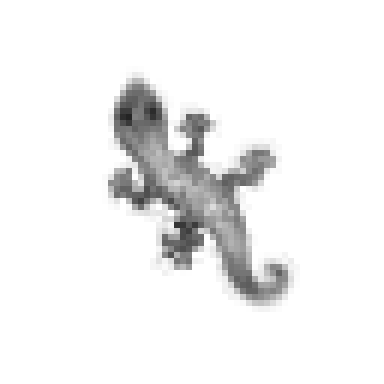

Training Steps Completed: 483
Loss:
0.00165674486
(64, 64, 16)


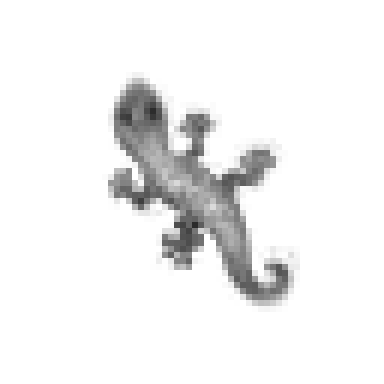

Training Steps Completed: 484
Loss:
0.00156399561
(64, 64, 16)


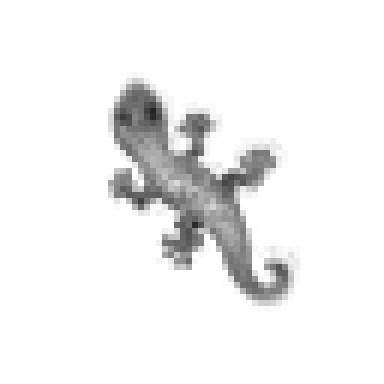

Training Steps Completed: 485
Loss:
0.00177866919
(64, 64, 16)


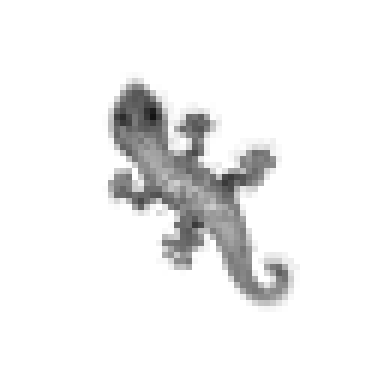

Training Steps Completed: 486
Loss:
0.00178435072
(64, 64, 16)


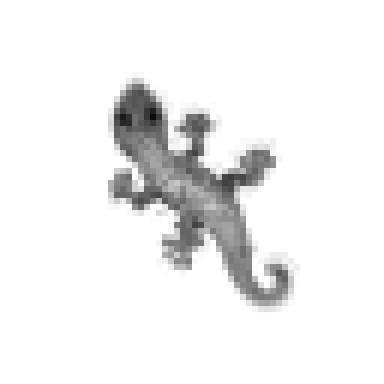

Training Steps Completed: 487
Loss:
0.00179194612
(64, 64, 16)


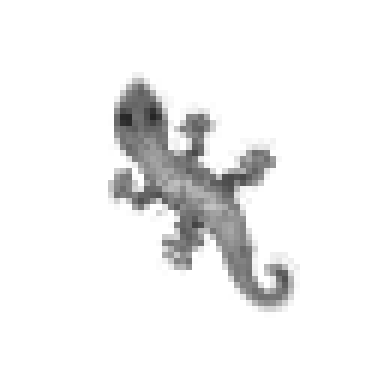

Training Steps Completed: 488
Loss:
0.00172334374
(64, 64, 16)


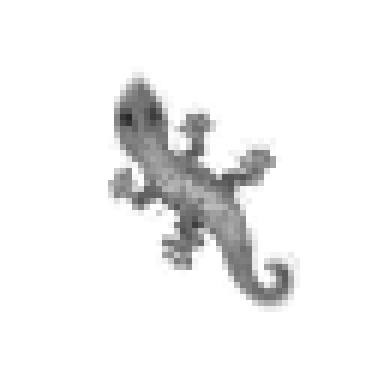

Training Steps Completed: 489
Loss:
0.00140638719
(64, 64, 16)


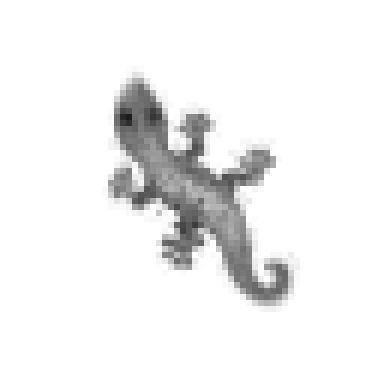

Training Steps Completed: 490
Loss:
0.00165619445
(64, 64, 16)


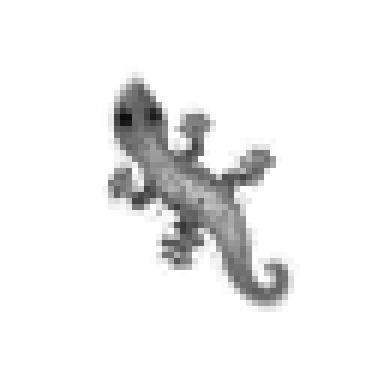

Training Steps Completed: 491
Loss:
0.00175196654
(64, 64, 16)


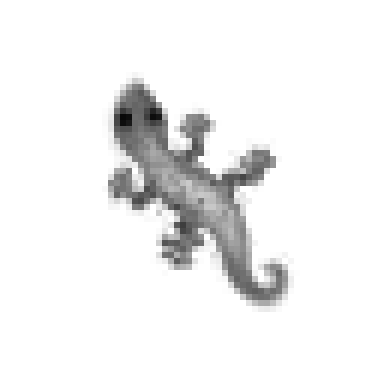

Training Steps Completed: 492
Loss:
0.00161180319
(64, 64, 16)


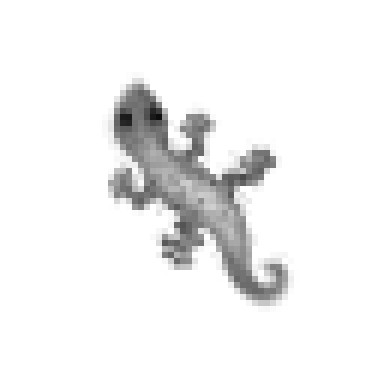

Training Steps Completed: 493
Loss:
0.00139985944
(64, 64, 16)


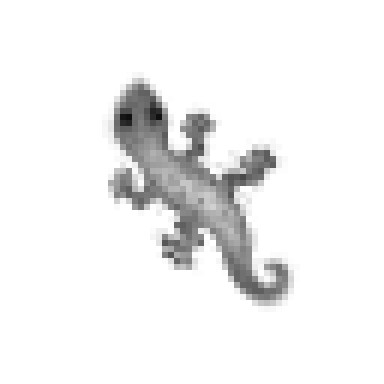

Training Steps Completed: 494
Loss:
0.00112768717
(64, 64, 16)


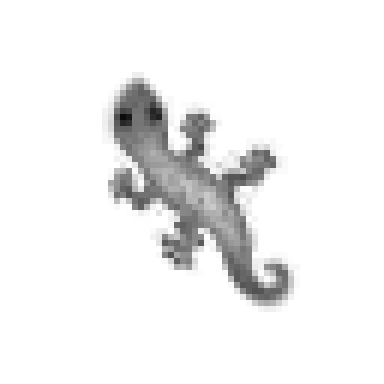

Training Steps Completed: 495
Loss:
0.00142258848
(64, 64, 16)


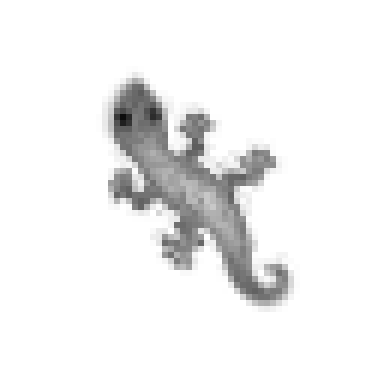

Training Steps Completed: 496
Loss:
0.00144369295
(64, 64, 16)


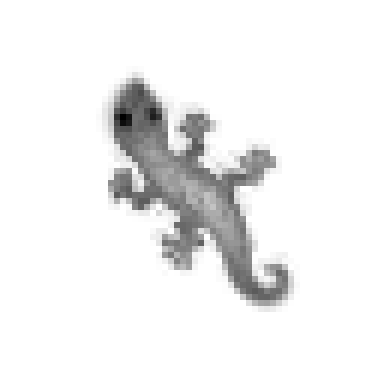

Training Steps Completed: 497
Loss:
0.00110008626
(64, 64, 16)


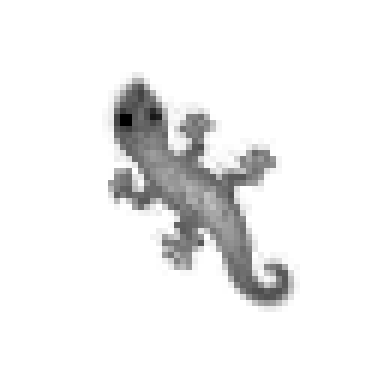

Training Steps Completed: 498
Loss:
0.00133893685
(64, 64, 16)


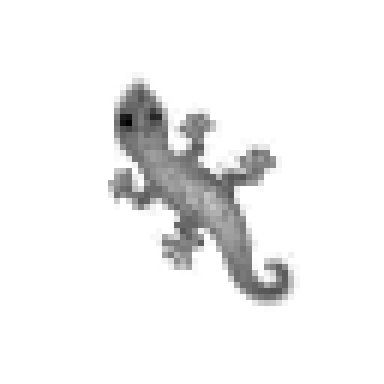

Training Steps Completed: 499
Loss:
0.00163156993
(64, 64, 16)


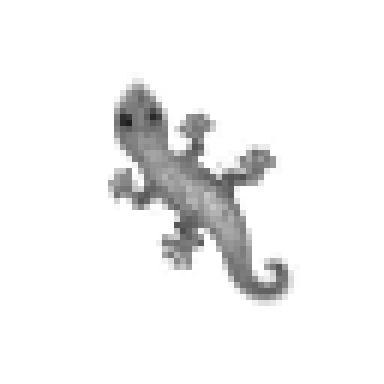

Training Steps Completed: 500
Loss:
0.00140670012
(64, 64, 16)


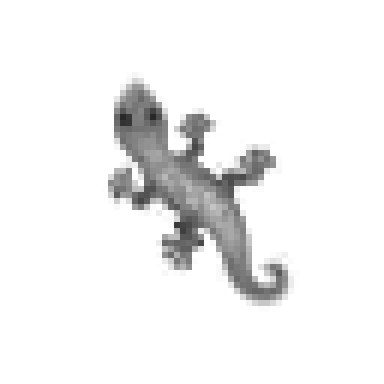

In [ ]:
grid.train(500)

Watch it grow for n steps:<br>(If you use a number > 100, you will see the instability when it grows past the number of steps it was trained for)

In [ ]:
grid.grow(100)

To save weights:

In [ ]:
model_step.save_weights('put name here')

To load past weights:<br>
Click the folder icon and upload the weights file to colab. Insert the path below.

In [ ]:
grid = CA(target_img)
model_step.load_weights('/content/Gray_lizard_500.h5') # <- put your path here

Seed and target initialized


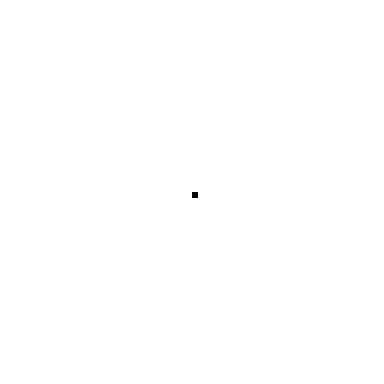

Time step  1


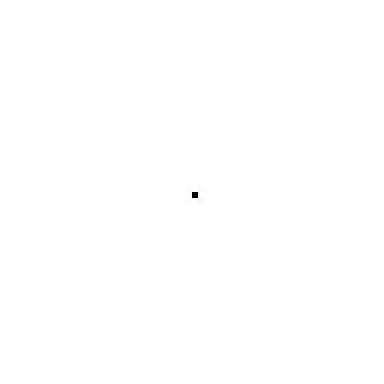

Time step  2


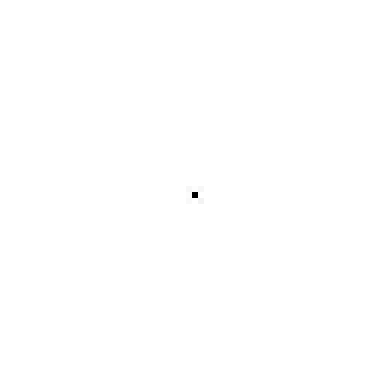

Time step  3


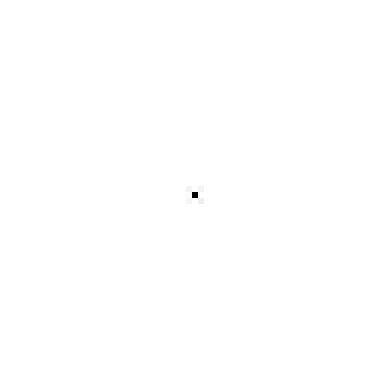

Time step  4


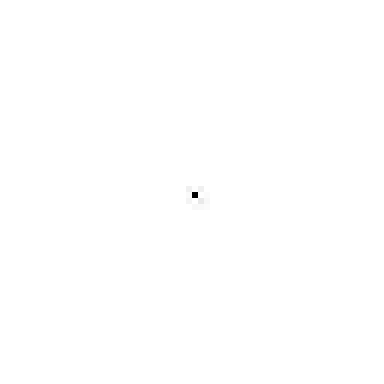

Time step  5


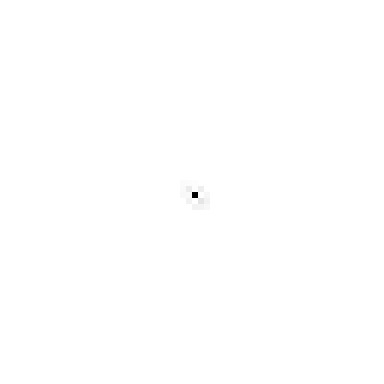

Time step  6


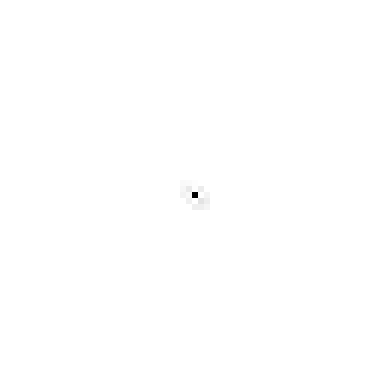

Time step  7


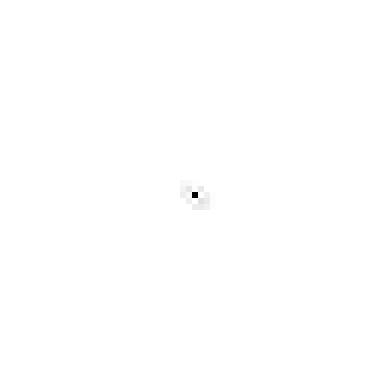

Time step  8


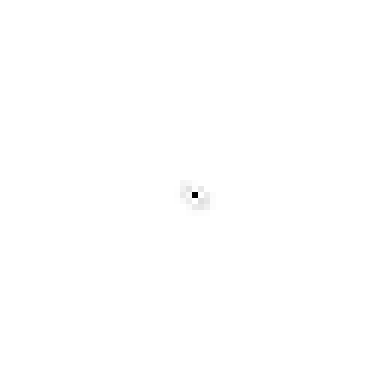

Time step  9


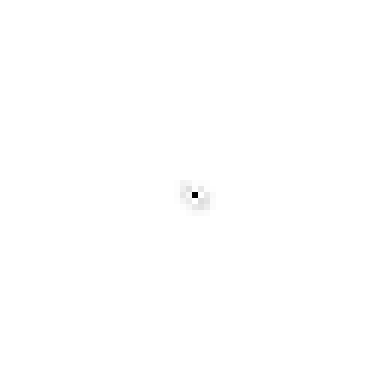

Time step  10


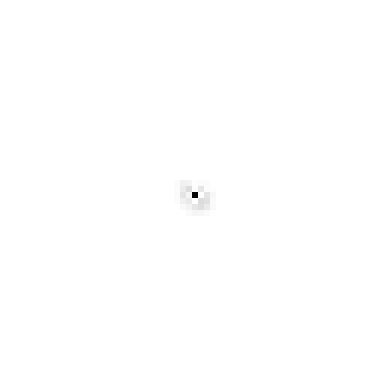

Time step  11


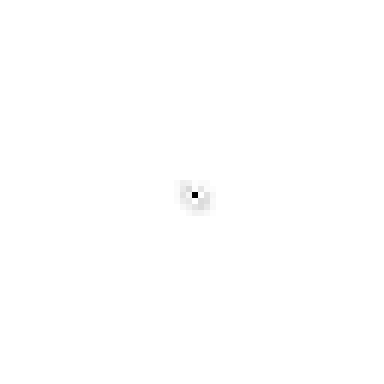

Time step  12


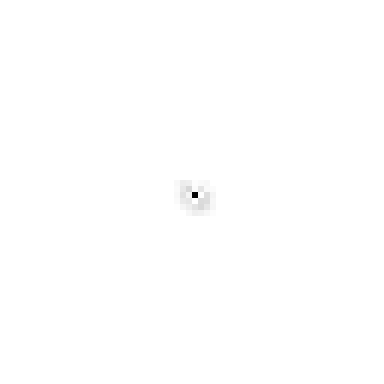

Time step  13


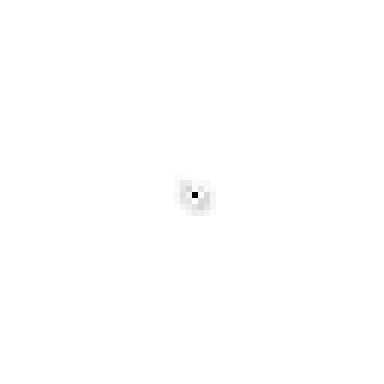

Time step  14


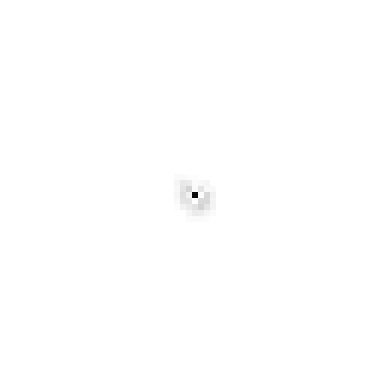

Time step  15


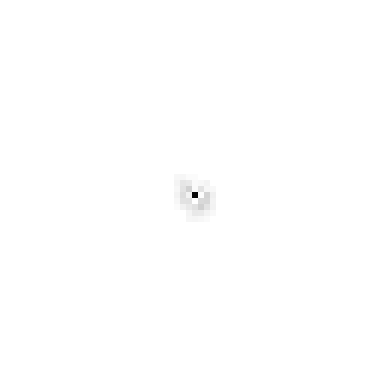

Time step  16


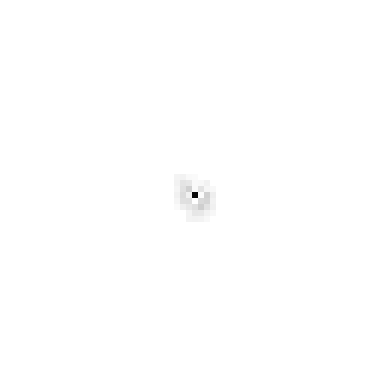

Time step  17


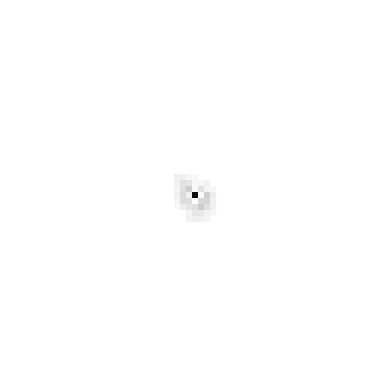

Time step  18


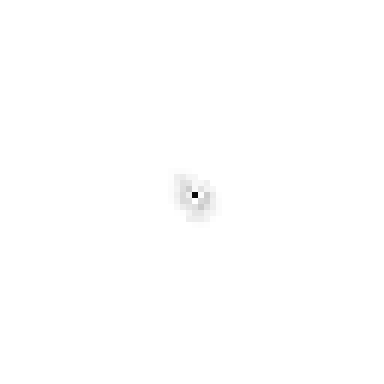

Time step  19


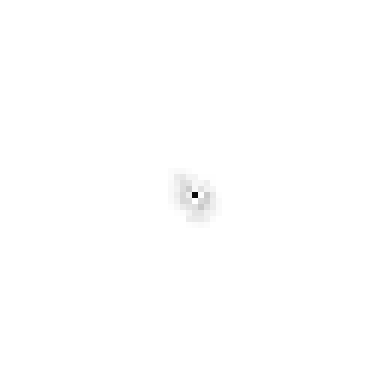

Time step  20


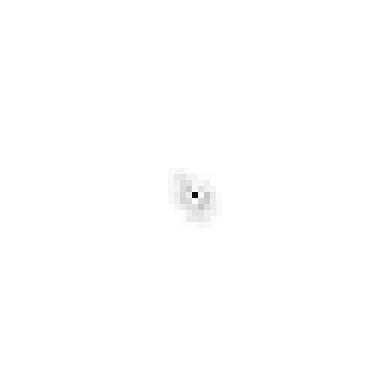

Time step  21


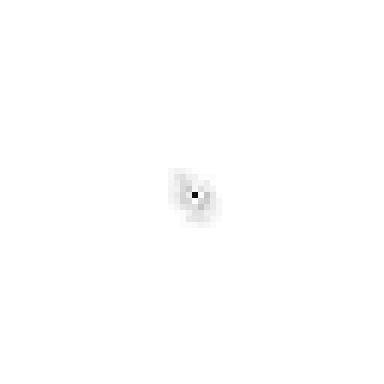

Time step  22


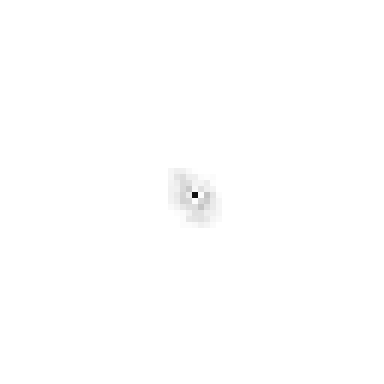

Time step  23


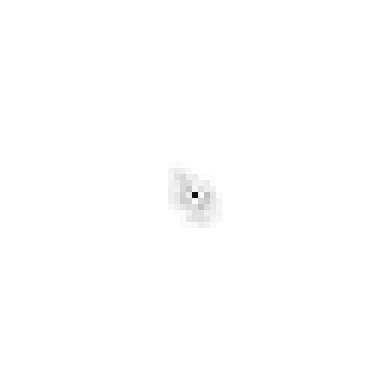

Time step  24


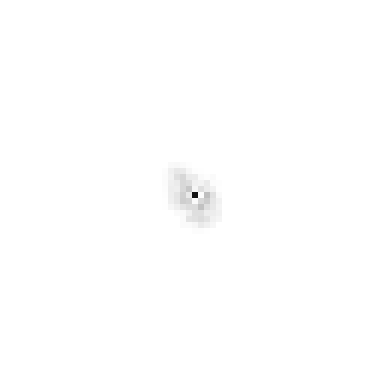

Time step  25


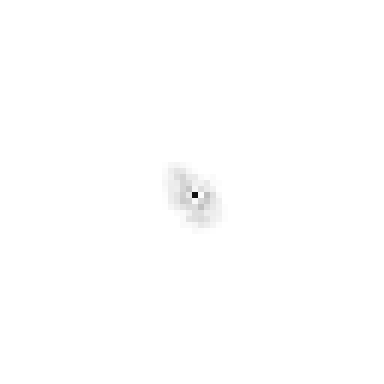

Time step  26


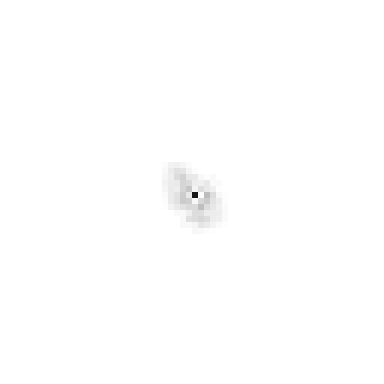

Time step  27


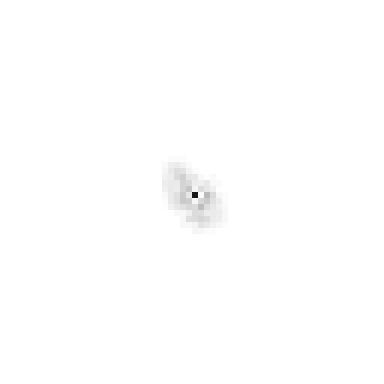

Time step  28


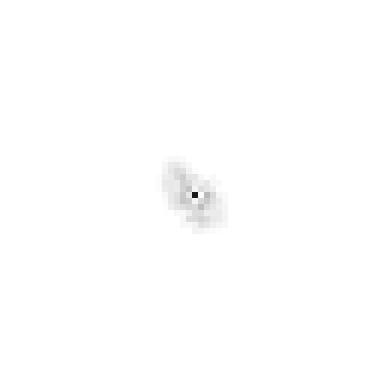

Time step  29


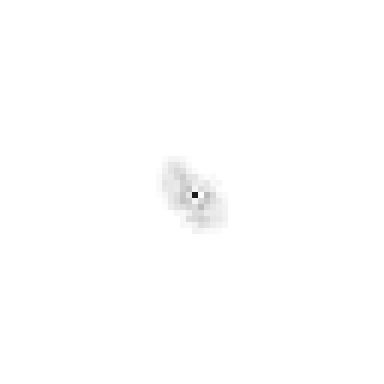

Time step  30


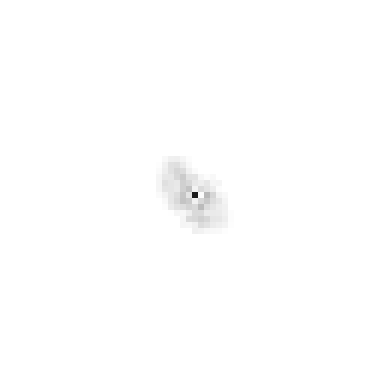

Time step  31


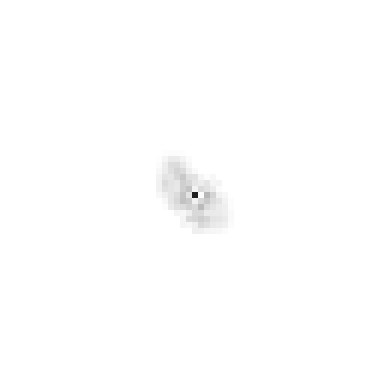

Time step  32


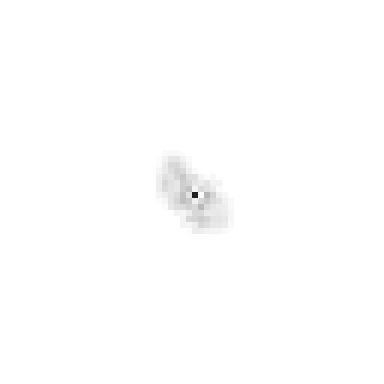

Time step  33


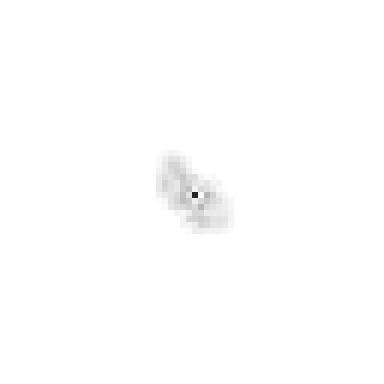

Time step  34


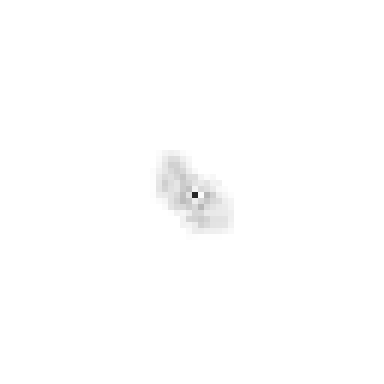

Time step  35


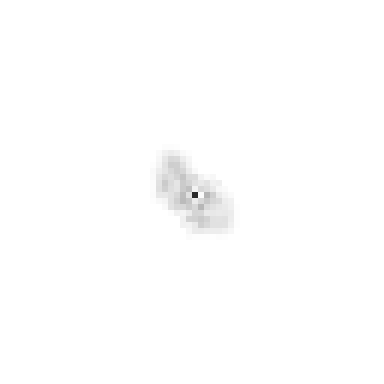

Time step  36


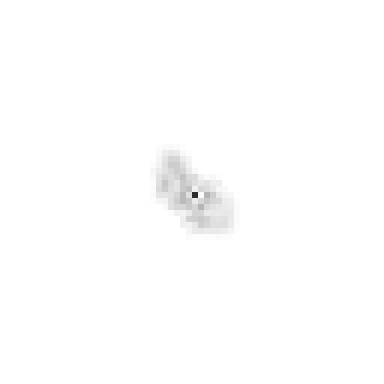

Time step  37


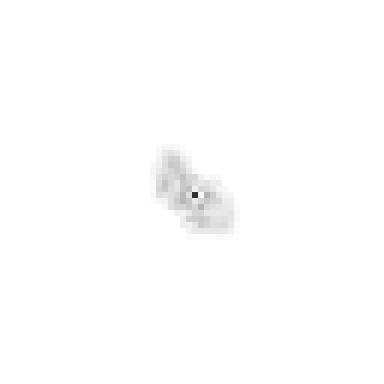

Time step  38


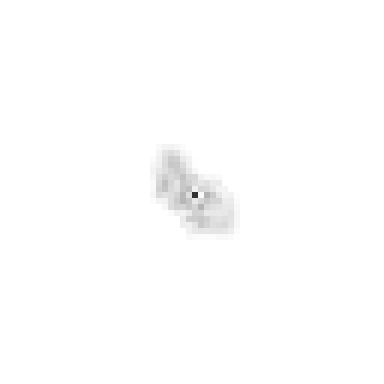

Time step  39


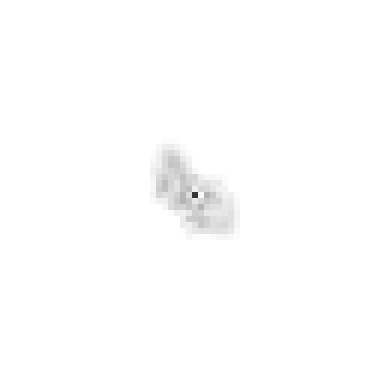

Time step  40


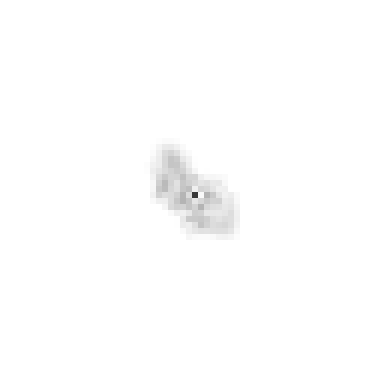

Time step  41


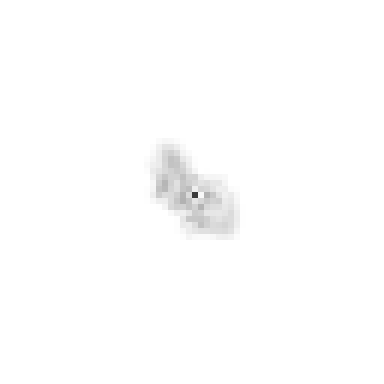

Time step  42


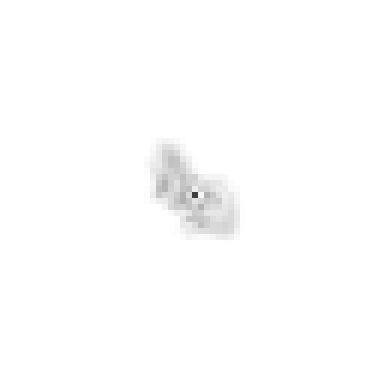

Time step  43


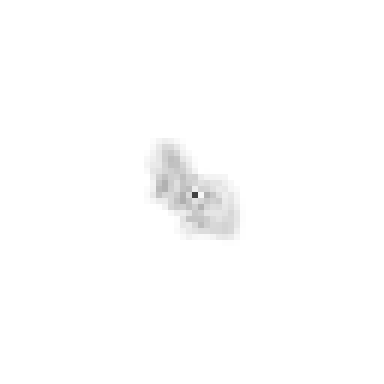

Time step  44


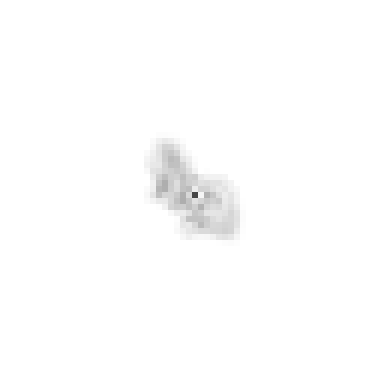

Time step  45


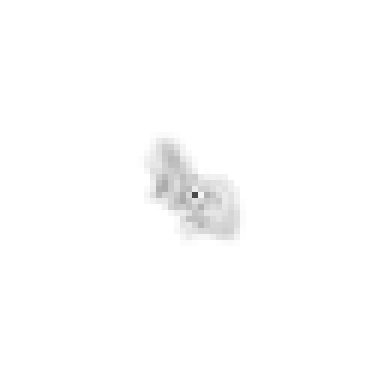

Time step  46


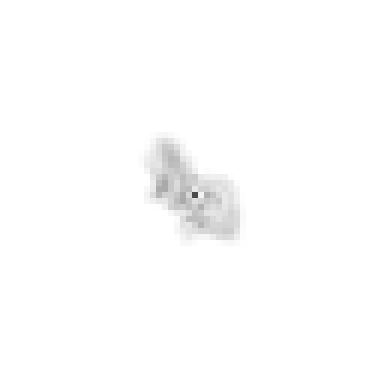

Time step  47


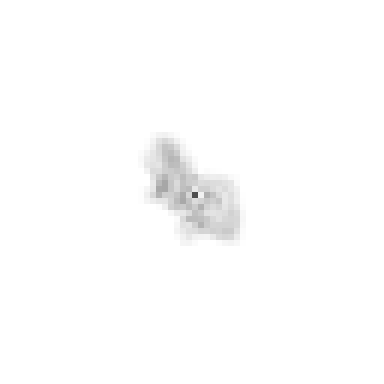

Time step  48


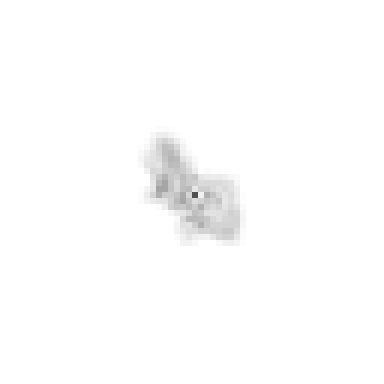

Time step  49


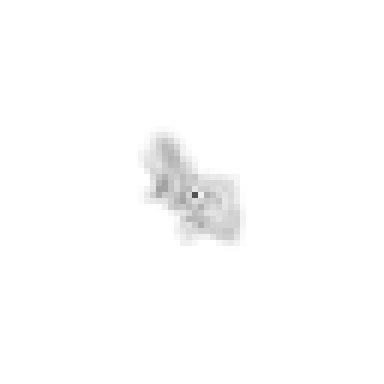

Time step  50


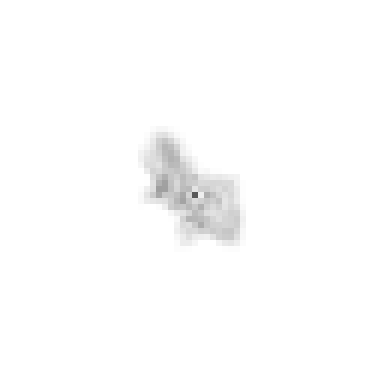

Time step  51


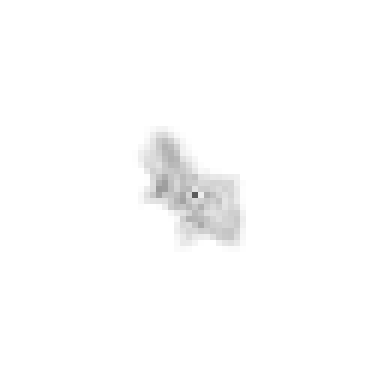

Time step  52


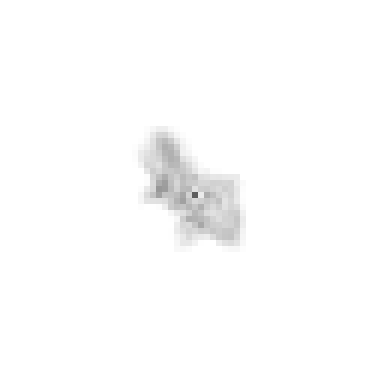

Time step  53


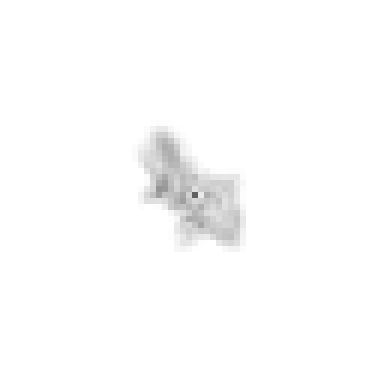

Time step  54


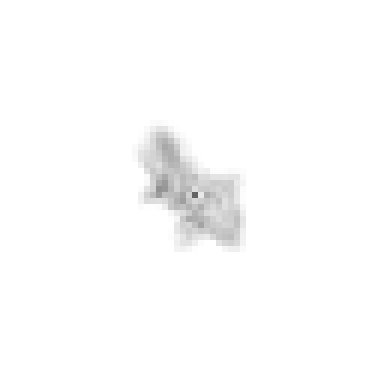

Time step  55


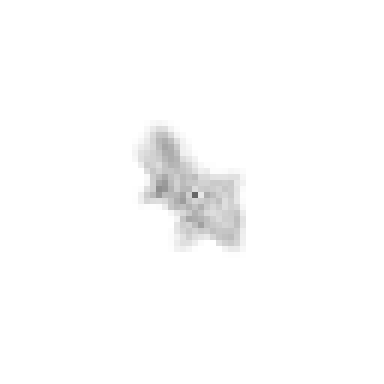

Time step  56


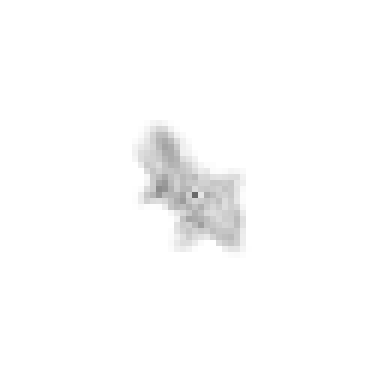

Time step  57


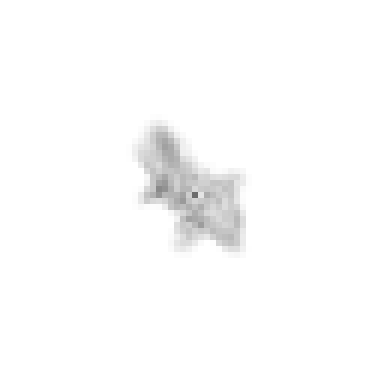

Time step  58


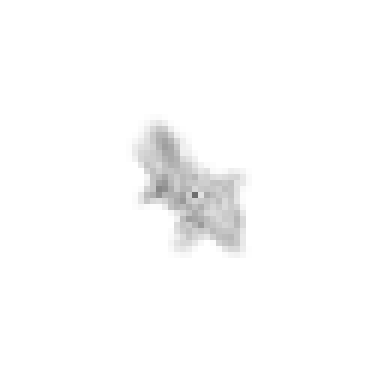

Time step  59


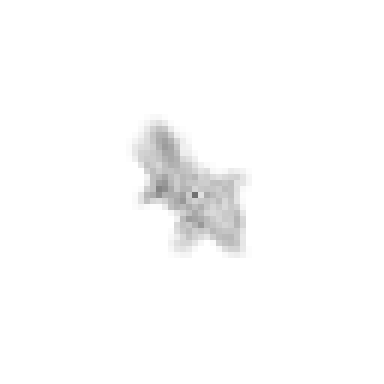

Time step  60


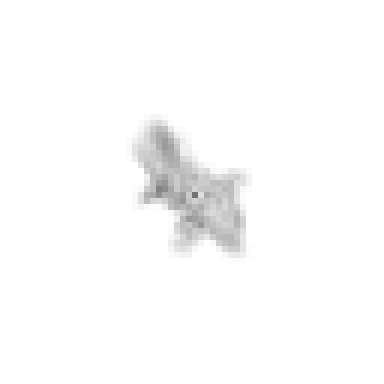

Time step  61


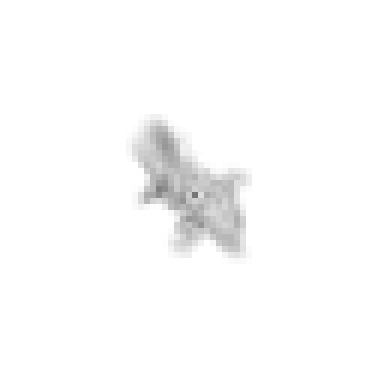

Time step  62


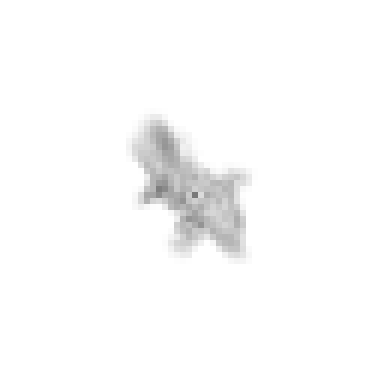

Time step  63


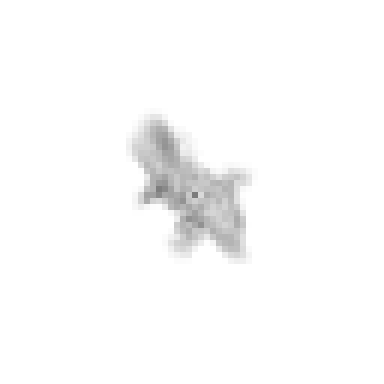

Time step  64


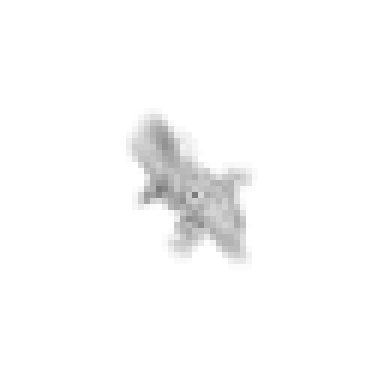

Time step  65


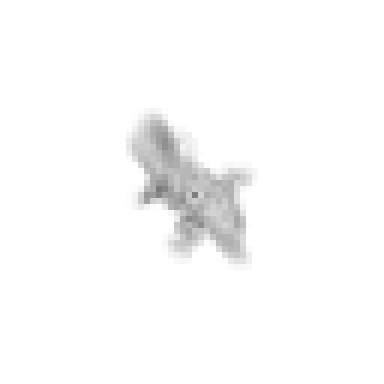

Time step  66


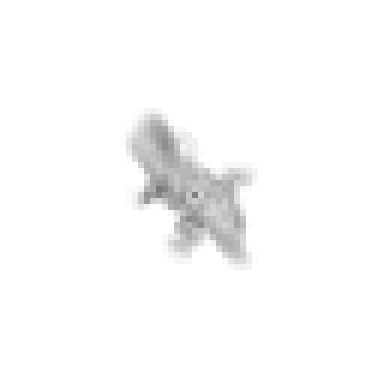

Time step  67


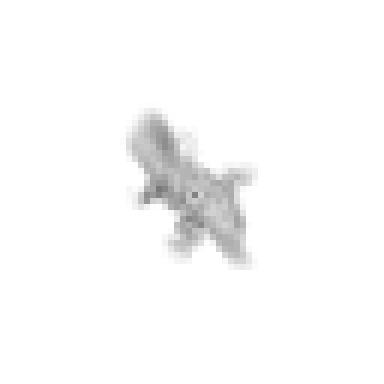

Time step  68


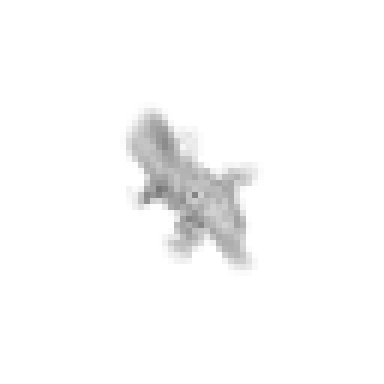

Time step  69


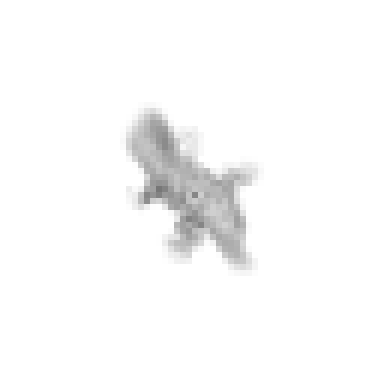

Time step  70


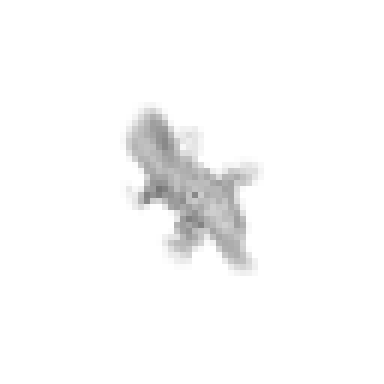

Time step  71


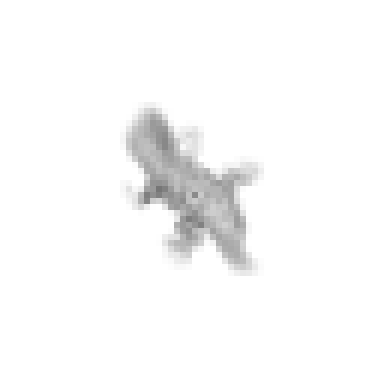

Time step  72


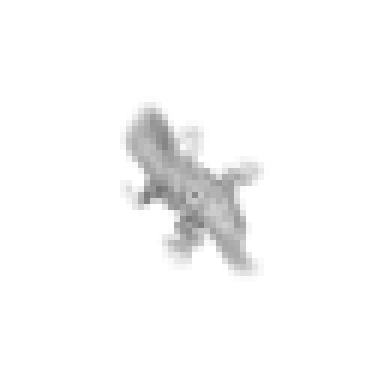

Time step  73


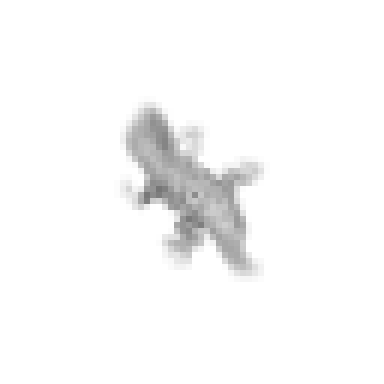

Time step  74


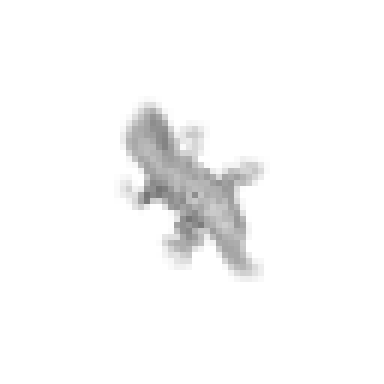

Time step  75


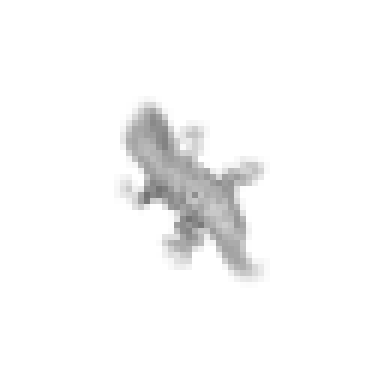

Time step  76


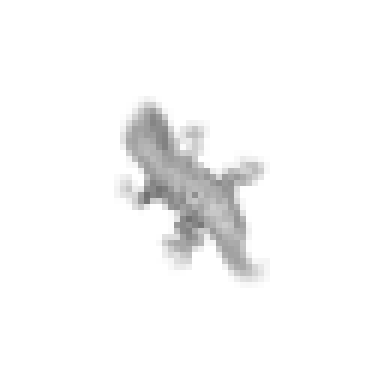

Time step  77


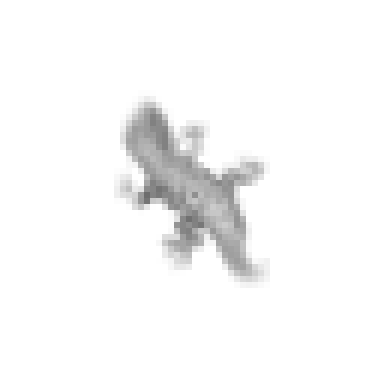

Time step  78


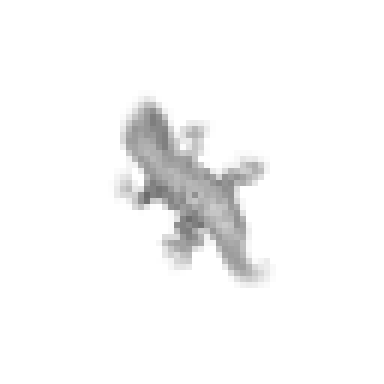

Time step  79


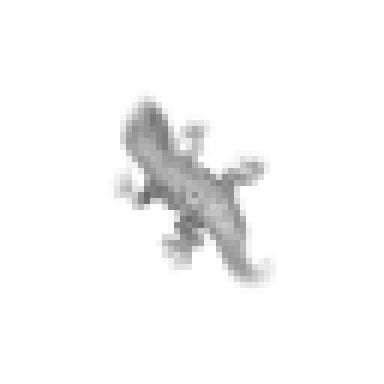

Time step  80


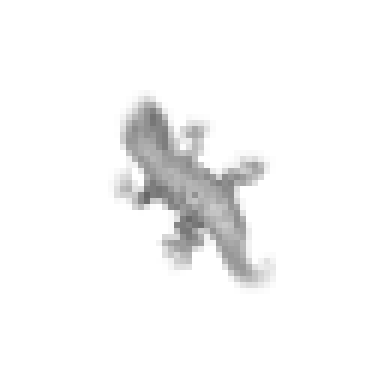

Time step  81


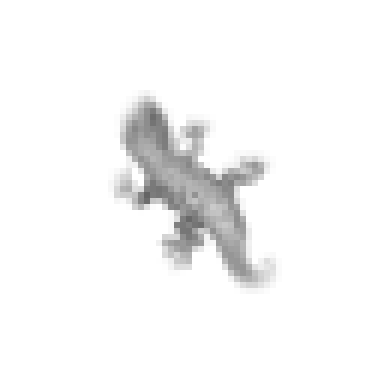

Time step  82


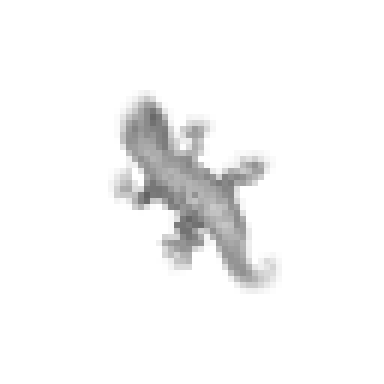

Time step  83


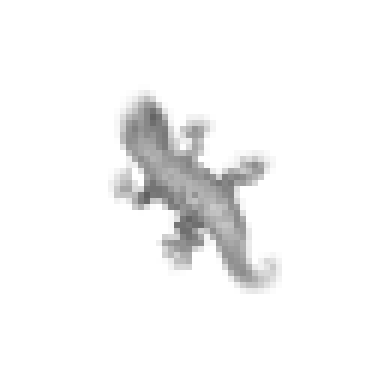

Time step  84


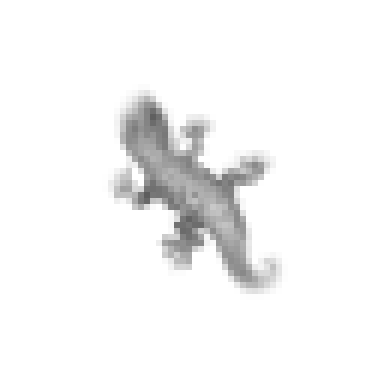

Time step  85


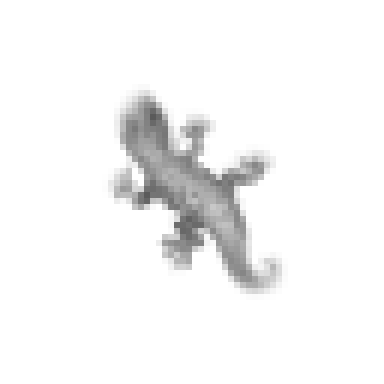

Time step  86


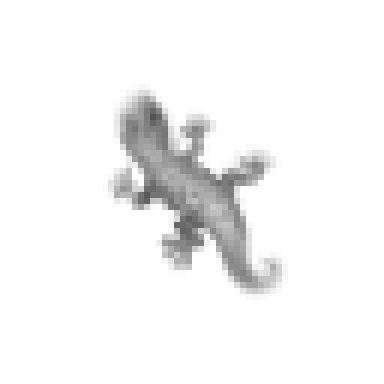

Time step  87


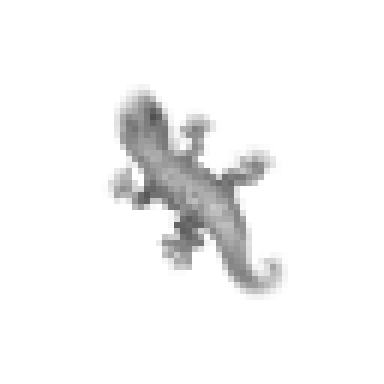

Time step  88


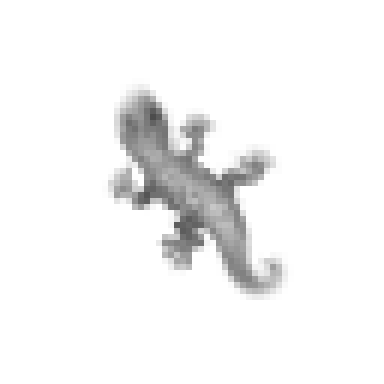

Time step  89


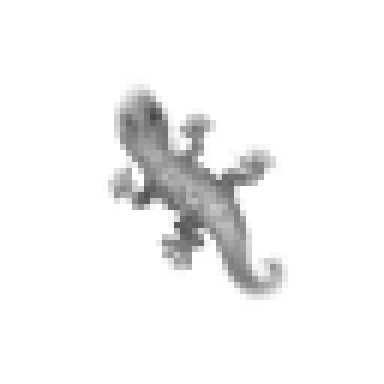

Time step  90


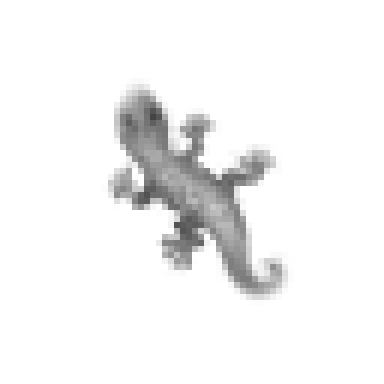

Time step  91


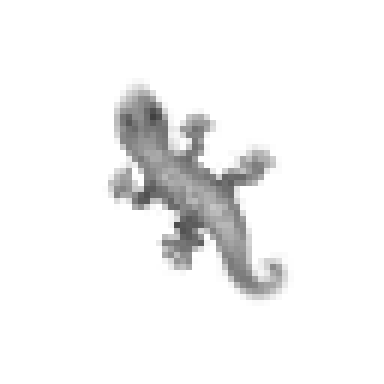

Time step  92


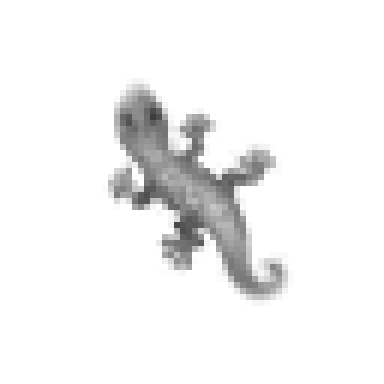

Time step  93


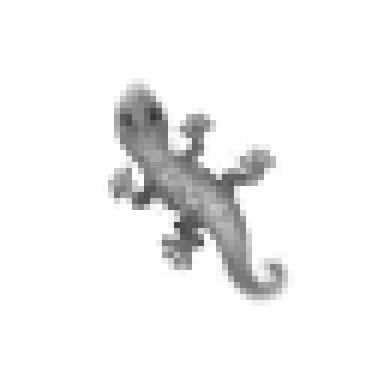

Time step  94


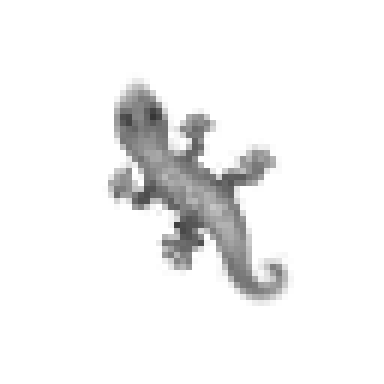

Time step  95


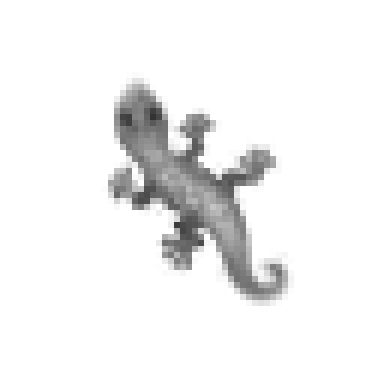

Time step  96


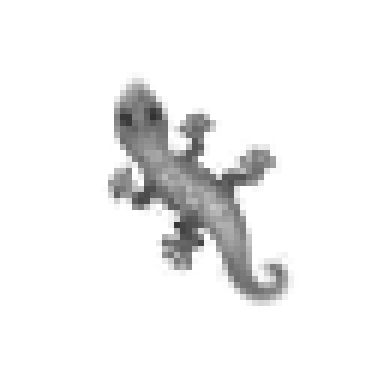

Time step  97


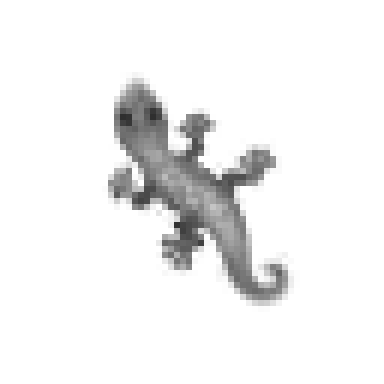

Time step  98


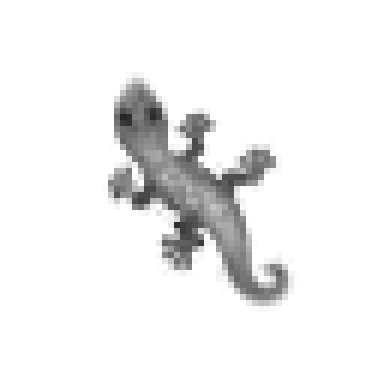

Time step  99


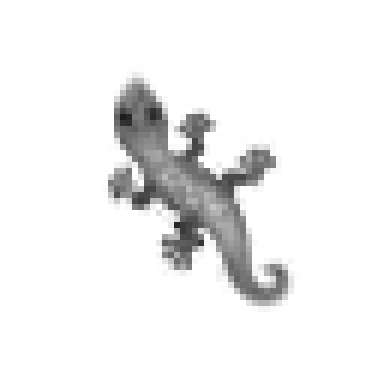

Time step  100


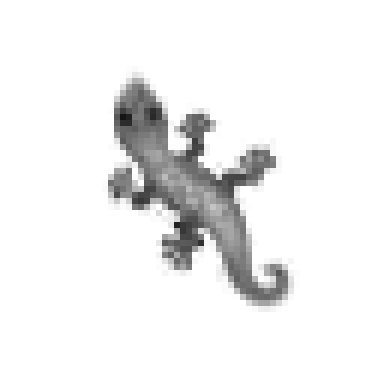

Current Loss:  0.0017265003


In [ ]:
grid.grow(100)